In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.optim import Adam
import json
from torchsummary import summary

from autoencoder.autoencoder import *
from PARCv1.differentiator import *
from PARCtorch.integrator.rk4 import *
from PARCtorch.integrator.numintegrator import *
from LatentPARC_model import *

##### Update version of PARCtorch

download file below from github, upload to home directory, then run code below

!pip install /home/pdy2bw/PARCtorch-0.3.0-py3-none-any.whl

In [3]:
def set_seed(seed: int):
    # Set the seed for Python's built-in random module
    random.seed(seed)
    
    # Set the seed for NumPy
    np.random.seed(seed)
    
    # Set the seed for PyTorch (CPU)
    torch.manual_seed(seed)
    
    # Set the seed for PyTorch (GPU), if CUDA is available
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
    
    # Ensure deterministic behavior in certain cases
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # This can be set to True for non-deterministic algorithms (faster on some hardware)


set_seed(42)

# Load in Data and Normalize

In [4]:
# get PARCtorch path
path = os.path.abspath(os.path.join(os.getcwd(), "..")) 
print(path)

/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch


In [5]:
# Add the root directory (PARCTorch) to the system path
sys.path.append(path)
from data.normalization import compute_min_max

In [6]:
# Get single void HMX data
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/HMX/train",
    "/project/vil_baek/data/physics/PARCTorch/HMX/test",
]
output_file = path + "/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC
Total files to process: 133
Processed 100/133 files.
Processed 133/133 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, -1995.0012, -5521.5503]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7184.0073, 5215.695]
Min and max values saved to '/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


# Create Data Loader for Training

In [7]:
import os
import torch
from torch.utils.data import DataLoader, random_split
import logging
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/HMX/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/HMX/test"  # Replace with your actual test directory path
future_steps = 1
# Path to the min_max.json file
min_max_path = os.path.join(path, "data", "hmx_min_max.json")  # Correct path
batch_size = 32
validation_split = 0.2  # 20% for validation

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Calculate the size of the validation set
validation_size = int(len(train_dataset) * validation_split)
train_size = len(train_dataset) - validation_size

# Perform the split
train_subset, val_subset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoader for training and validation datasets
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2025-04-13 21:50:33,404 [INFO] Starting data validation...
2025-04-13 21:50:33,406 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:01<00:00, 99.78it/s]
2025-04-13 21:50:34,415 [INFO] Data validation completed successfully.
2025-04-13 21:50:34,416 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 470.58it/s]
2025-04-13 21:50:34,633 [INFO] Total samples in dataset: 1400


# Define LatentPARC Architecture + Training

In [7]:
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes_TP = [2, 4]
latent_dim_TP = 8
layer_sizes_M = [1, 2]
latent_dim_M = 4

layer_sizes_decoder = [3, 8]
latent_dim = latent_dim_TP + latent_dim_M # 12

encoder_TP = Encoder(layers=layer_sizes_TP, latent_dim=latent_dim_TP).to(device)
encoder_M = Encoder(layers=layer_sizes_M, latent_dim=latent_dim_M).to(device)
decoder = Decoder(layers=layer_sizes_decoder, latent_dim=latent_dim).to(device)
differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)  # step size may be hyper-param of interest

# Initialize LatentPARC
model_init = lp_model_2plus1_1decoder(encoder_TP, encoder_M, decoder, differentiator, integrator).to(device)

#Loss Function
criterion = torch.nn.L1Loss().to(device)
# criterion = nn.MSELoss()
# criterion = LpLoss(p=10).cuda()

# #### BEGIN PERCEPTUAL LOSS BLOCK
# # Initialize Perceptual Loss
# feature_extractor = FeatureExtractor().to(device)
# perceptual_loss = PerceptualLoss(feature_extractor).to(device)

# # Perceptual Loss + L1 Combined Criterion
# def combined_loss(output, target):
#     l1_loss = criterion(output, target)  # Existing L1 loss
#     # Check if the number of channels is 3 before computing perceptual loss
#     if target.shape[1] == 3:  
#         p_loss = perceptual_loss(output, target)  # Perceptual loss
#     else:
#         p_loss = 0  # No perceptual loss for latent space data (more than 3 channels)
#     total_loss = l1_loss + 0.1 * p_loss  # Weight perceptual loss (adjust 0.1 as needed)
#     return total_loss
# #### END PERCEPTUAL LOSS BLOCK

# Define Optimizer
optimizer = Adam(model_init.parameters(), lr=1e-3)

# Define learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

/home/pdy2bw/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/5


Validating: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s]


Epoch 1: Training Loss: 0.3357 | Validation Loss: 0.1758

Epoch 2/5


Validating: 100%|██████████| 9/9 [00:01<00:00,  8.83it/s]


Epoch 2: Training Loss: 0.1316 | Validation Loss: 0.0998

Epoch 3/5


Validating: 100%|██████████| 9/9 [00:01<00:00,  8.48it/s]


Epoch 3: Training Loss: 0.0930 | Validation Loss: 0.1018

Epoch 4/5


Validating: 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]


Epoch 4: Training Loss: 0.0780 | Validation Loss: 0.0879

Epoch 5/5


Validating: 100%|██████████| 9/9 [00:01<00:00,  8.92it/s]

Epoch 5: Training Loss: 0.0719 | Validation Loss: 0.0843
Model and logs saved to /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC


In [ ]:
# where to save weights
save_path="/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC"
weights_name="test"

#  training model
model = LatentPARC(model_init, optimizer, save_path, weights_name)

log_dict = model.train(loss_function=criterion, epochs=50, image_size = [128, 256], n_channels=3, device=device, 
                       train_loader=train_loader, val_loader=val_loader, scheduler=scheduler,
                       noise_fn=add_random_noise, initial_max_noise=0.16, n_reduce_factor=0.5, 
                       ms_reduce_factor=0, reduce_on=3, loss_weights=[1.0,10.0,1.0])

# Load in weights

In [14]:
# define model
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes_TP = [2, 4]
latent_dim_TP = 8
layer_sizes_M = [1, 2]
latent_dim_M = 4

layer_sizes_decoder = [3, 8]
latent_dim = latent_dim_TP + latent_dim_M # 12

encoder_TP = Encoder(layers=layer_sizes_TP, latent_dim=latent_dim_TP).to(device)
encoder_M = Encoder(layers=layer_sizes_M, latent_dim=latent_dim_M).to(device)
decoder = Decoder(layers=layer_sizes_decoder, latent_dim=latent_dim).to(device)
differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)  # step size may be hyper-param of interest

# Initialize LatentPARC
model_init = lp_model_2plus1_1decoder(encoder_TP, encoder_M, decoder, differentiator, integrator).to(device)

#Loss Function
criterion = torch.nn.L1Loss().to(device)
# criterion = LpLoss(p=10).cuda()

# criterion = nn.MSELoss()
optimizer = Adam(model_init.parameters(), lr=1e-3)

#  training model
model = LatentPARC(model_init, optimizer)

In [15]:
# load weights into model
weights_path = "weights_arch_experiment/LP_2plus1_1decoder_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_nts1_3000.pth"

model.network.load_state_dict(torch.load(weights_path))
model.network.eval()  # Set to evaluation mode

/tmp/ipykernel_3225/2096164395.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.network.load_state_dict(torch.load(weights_path))


lp_model_2plus1_1decoder(
  (encoderTP): Encoder(
    (net): Sequential(
      (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (encoderM): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (differentiator): Differentiator(
    (b1c1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model.network)}")

Total trainable parameters: 1264755


##### PARCv1 has 17,852,019 params total with 15,384,870 of those in the U-net shape descriptor, so PARCv1 differentiator is 2,467,149 params which is ~2x more than LatentPARC 2x version at 1,272,835

# Make Predictions

### Load in Test Data

In [16]:
# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Optionally, create DataLoader for test dataset
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

sample_id = 0
ic = test_dataset[sample_id][0]
seq = test_dataset[sample_id][-1]
print(ic.shape, seq.shape)
X = torch.concat((ic.unsqueeze(0), seq))[:, :n_channels,:,:]
print(X.shape)

2025-04-13 21:54:10,040 [INFO] Starting data validation...
2025-04-13 21:54:10,043 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 58.05it/s]
2025-04-13 21:54:10,614 [INFO] Data validation completed successfully.
2025-04-13 21:54:10,616 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 486.71it/s]
2025-04-13 21:54:10,688 [INFO] Total samples in dataset: 33


torch.Size([5, 128, 256]) torch.Size([14, 5, 128, 256])
torch.Size([15, 3, 128, 256])


# Single ts preds

In [17]:
just_AE_reconstruction_pred = []
single_ts_Zhat = []
single_ts_full_reconstruction_pred = []

for i in range(n_ts-1): #!!! test
    IC = X[i, ...].unsqueeze(0).to(device)
    target = X[i+1, ...].unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Reconstructing test images
        _, x_bar = model.network(IC, n_ts=0) # just AE
        z_hat, x_hat = model.network(IC, n_ts=1) # AE + dynamics
        
    # Sending reconstructed and original images to CPU and accumulating in lists
    just_AE_reconstruction_pred.append(x_bar.cpu())
    single_ts_Zhat.append(z_hat.cpu())
    single_ts_full_reconstruction_pred.append(x_hat.cpu())

# Concatenate all batches to create single tensors
just_AE_reconstruction_pred = torch.cat(just_AE_reconstruction_pred, dim=0)

single_ts_Zhat = torch.cat(single_ts_Zhat, dim=0)  # Shape: (total_images, n_channels, height, width)

single_ts_full_reconstruction_pred = torch.cat(single_ts_full_reconstruction_pred, dim=0)
single_ts_full_reconstruction_pred = torch.concat([X[0, ...].unsqueeze(0), single_ts_full_reconstruction_pred])

In [18]:
single_ts_full_reconstruction_pred.shape, just_AE_reconstruction_pred.shape, single_ts_Zhat.shape

(torch.Size([15, 3, 128, 256]),
 torch.Size([14, 3, 128, 256]),
 torch.Size([14, 12, 32, 64]))

### AE Reconstruction Evaluation

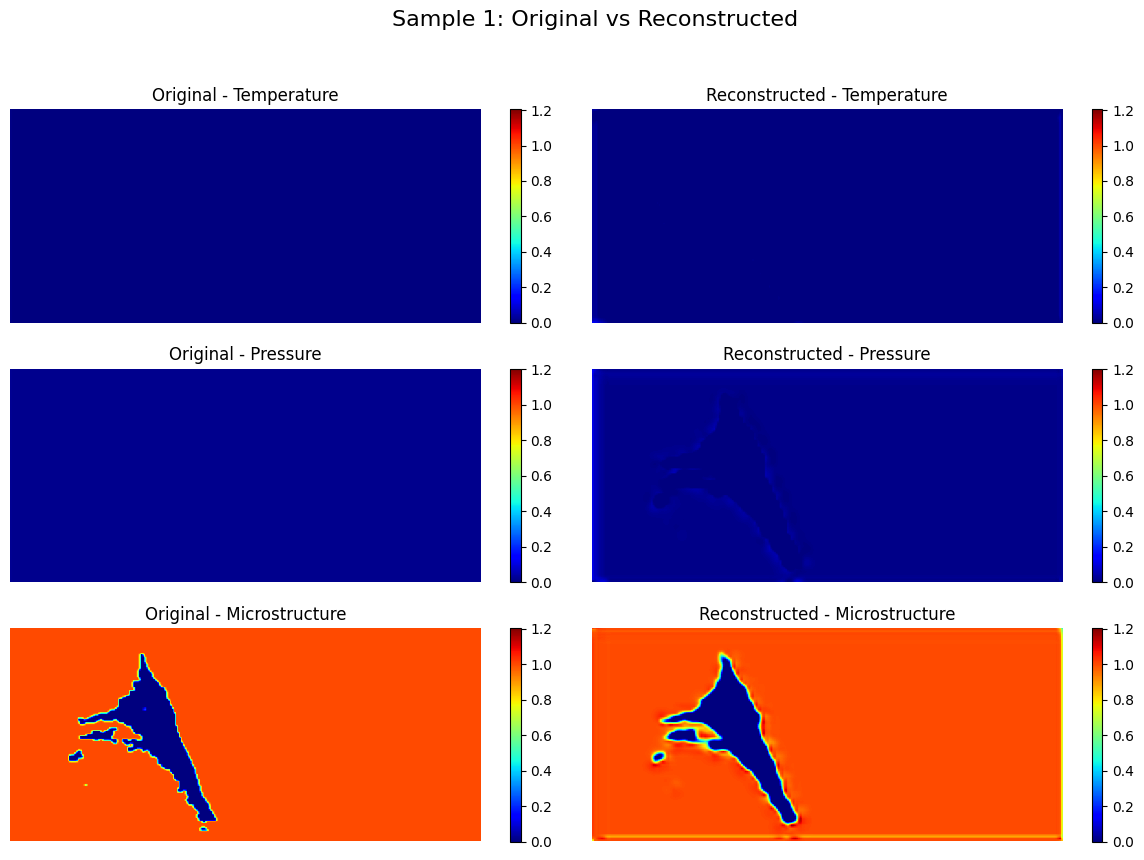

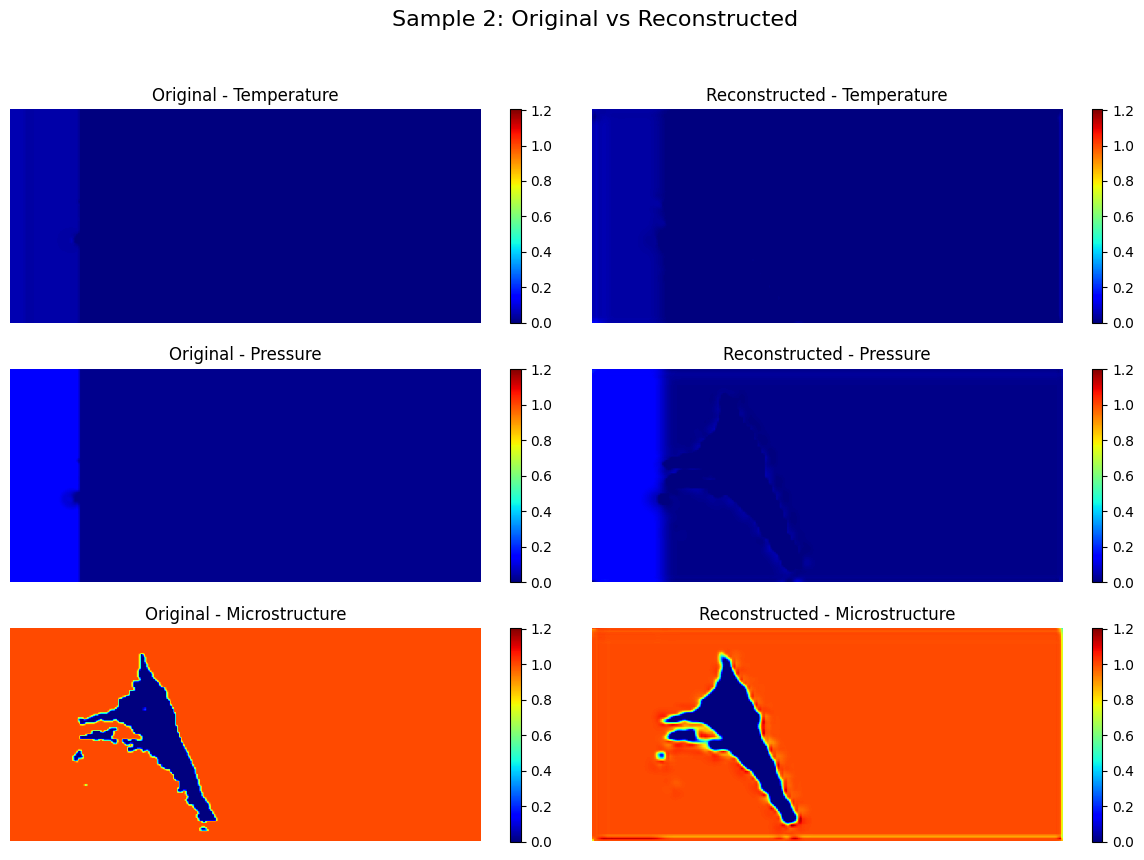

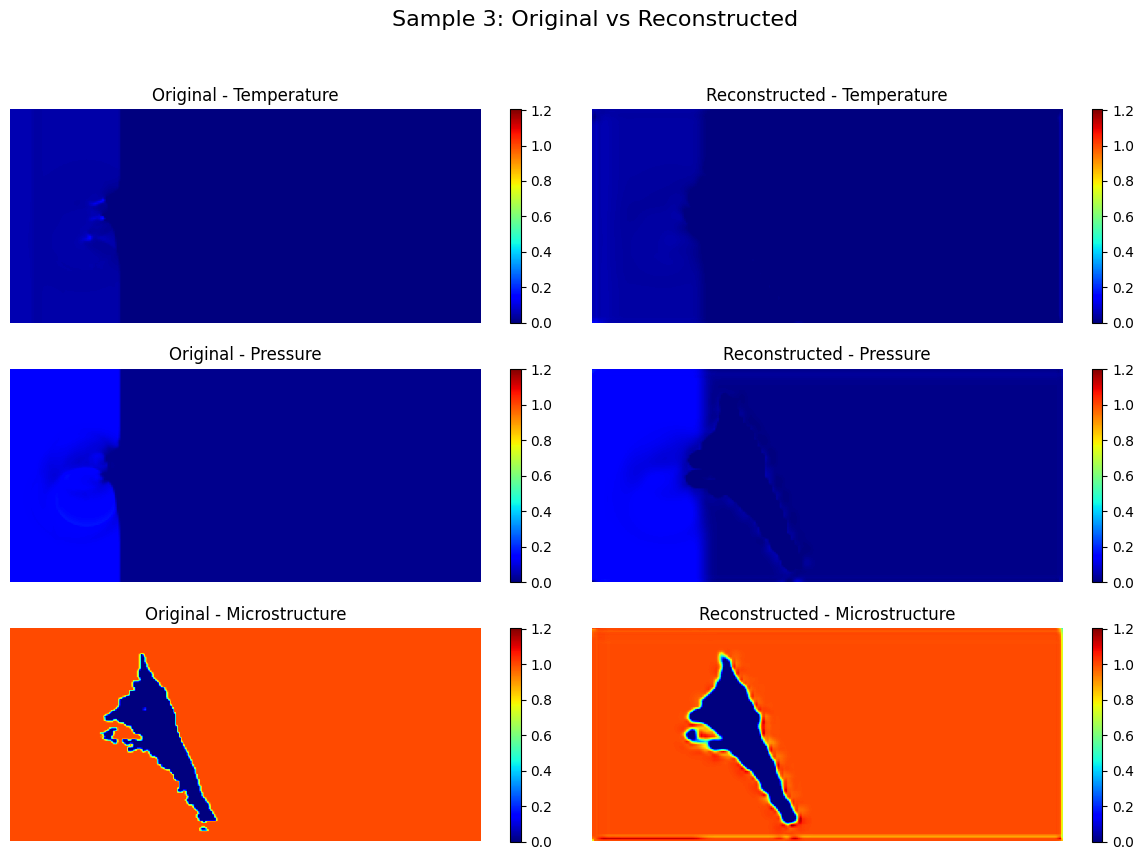

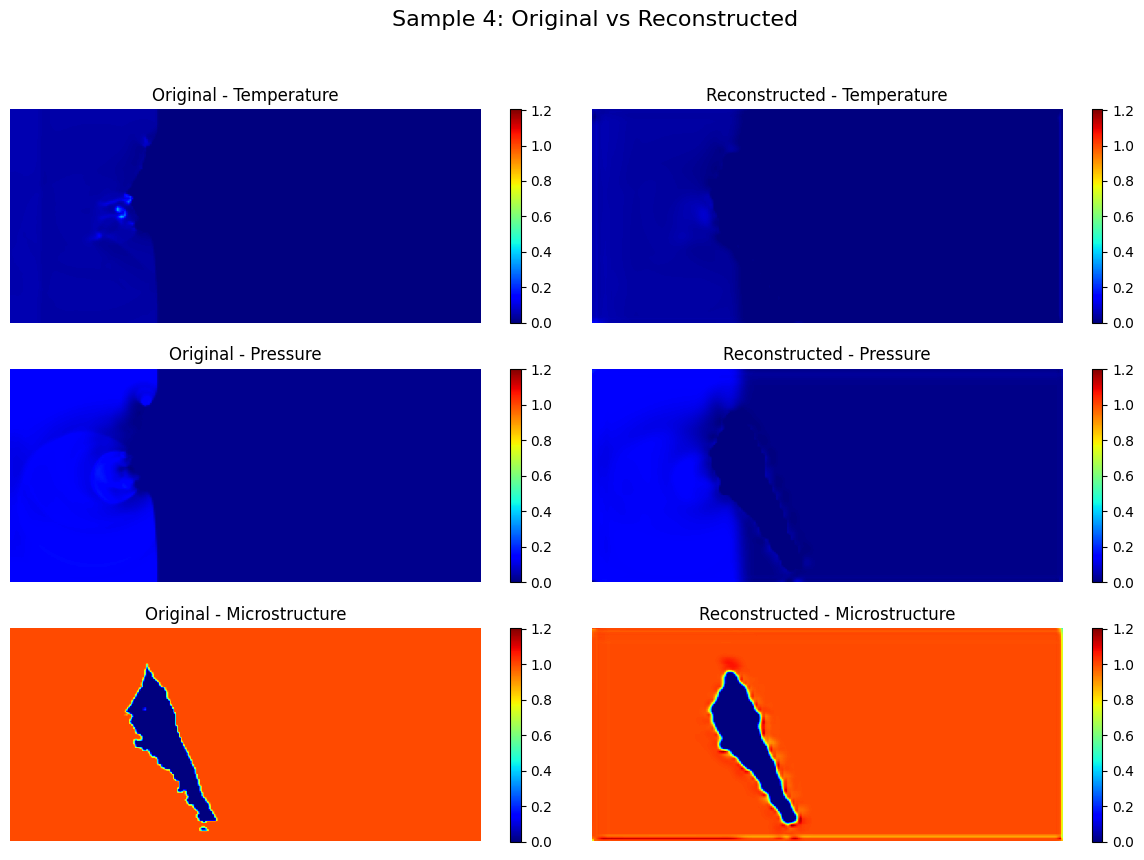

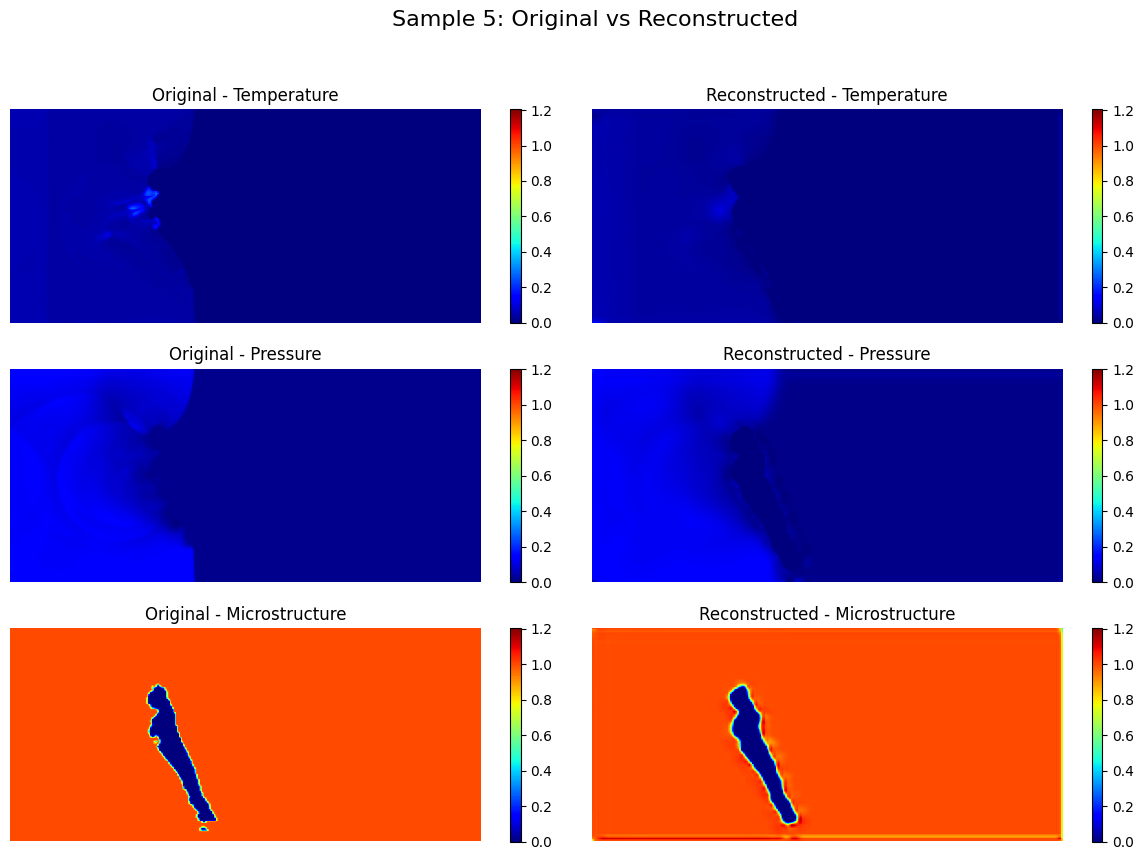

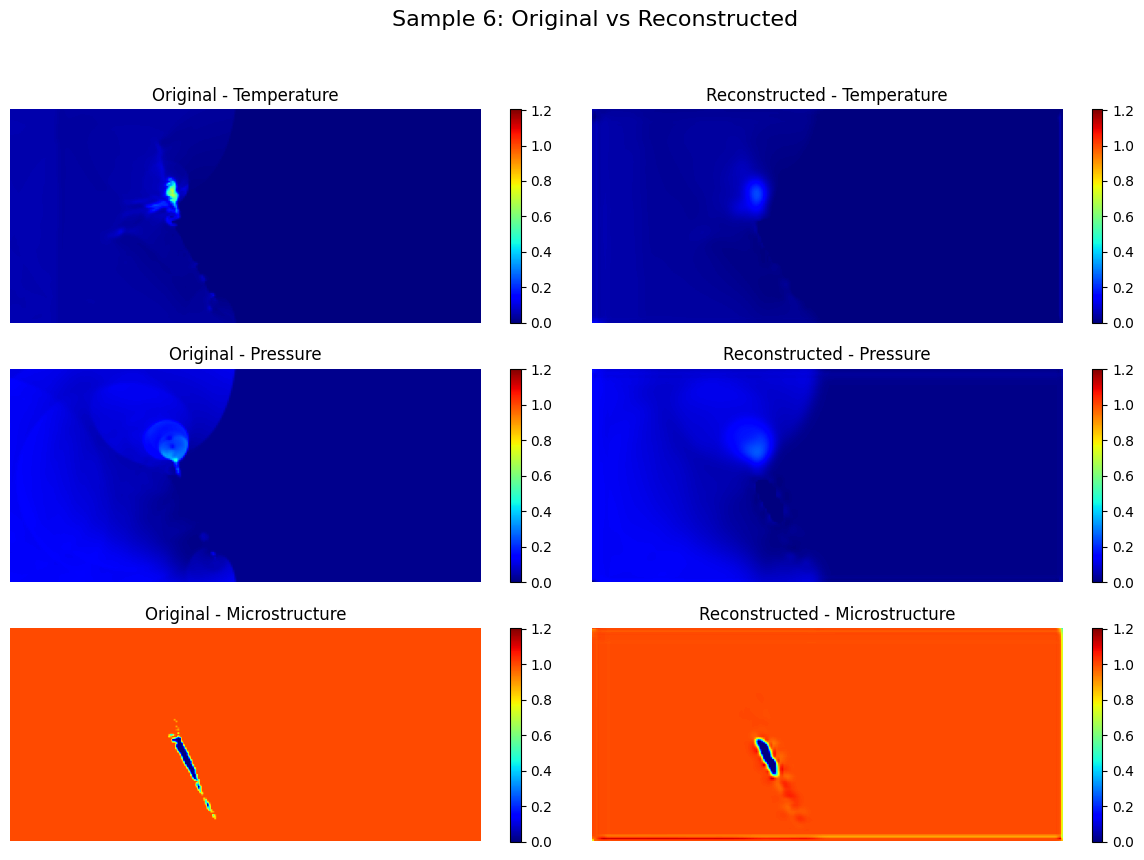

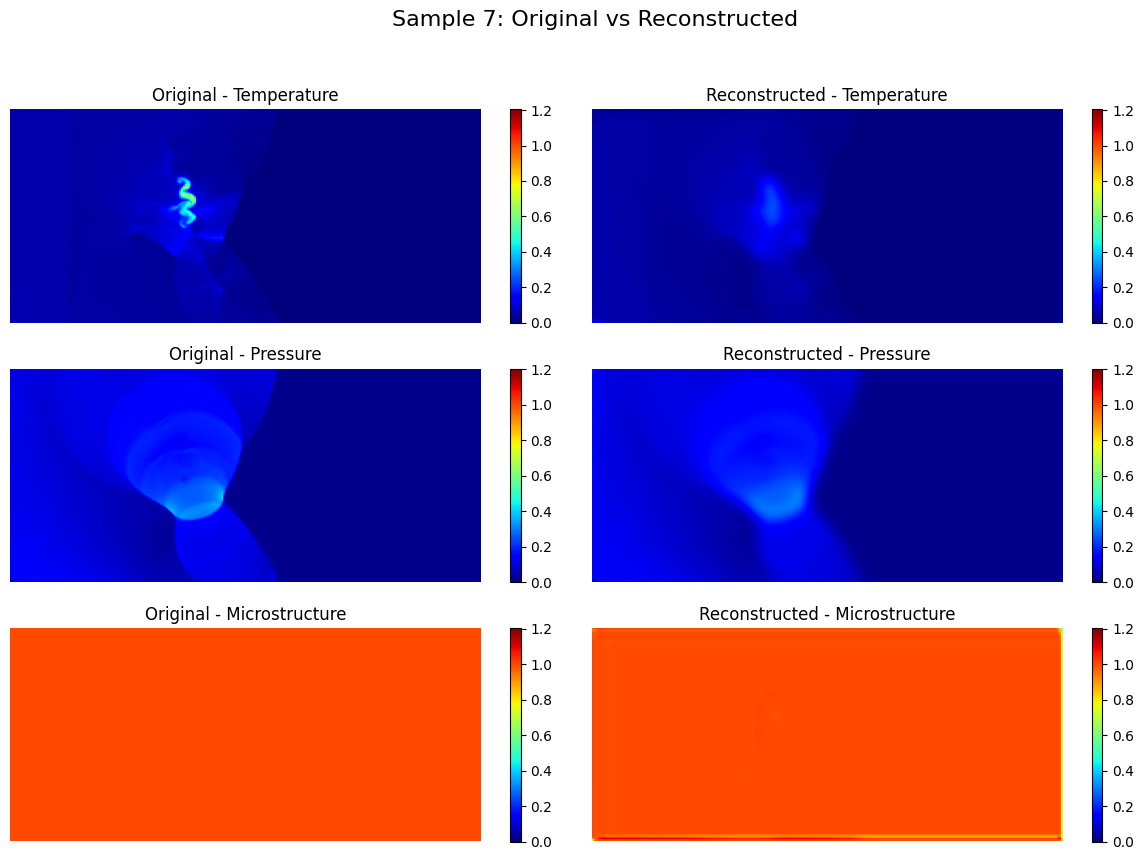

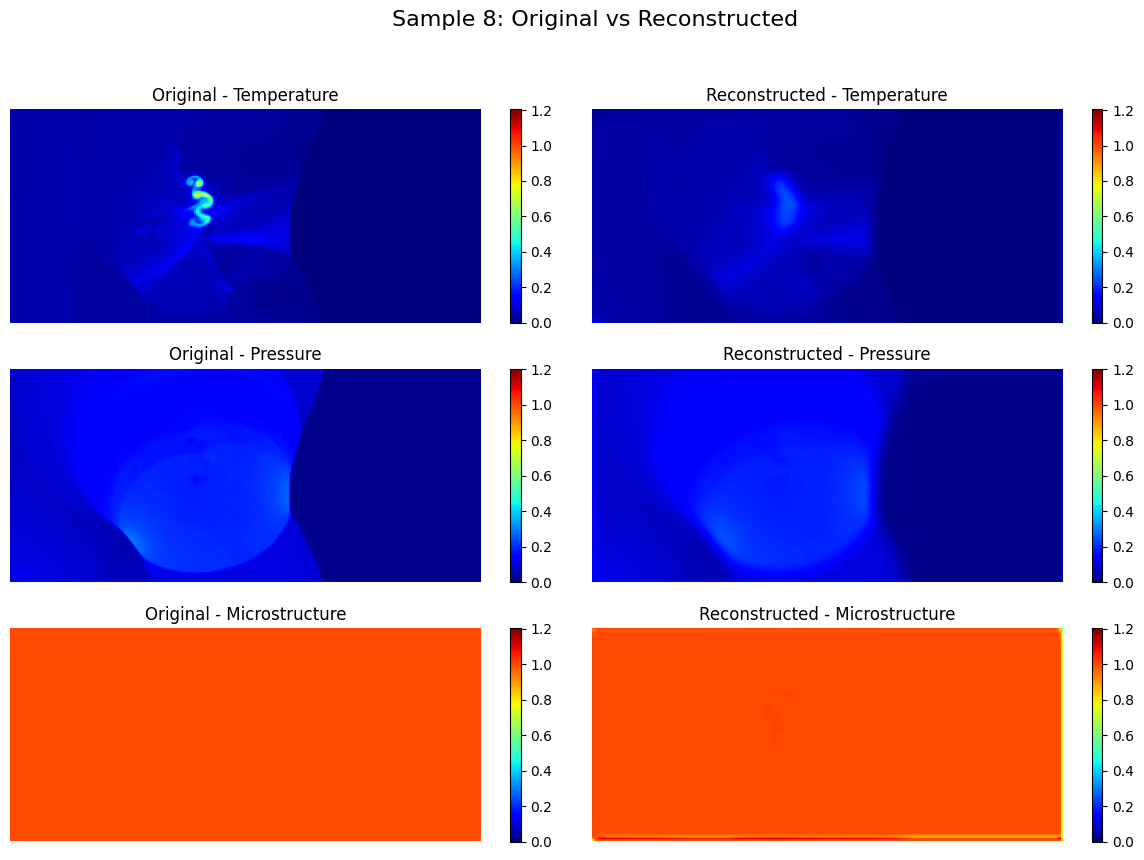

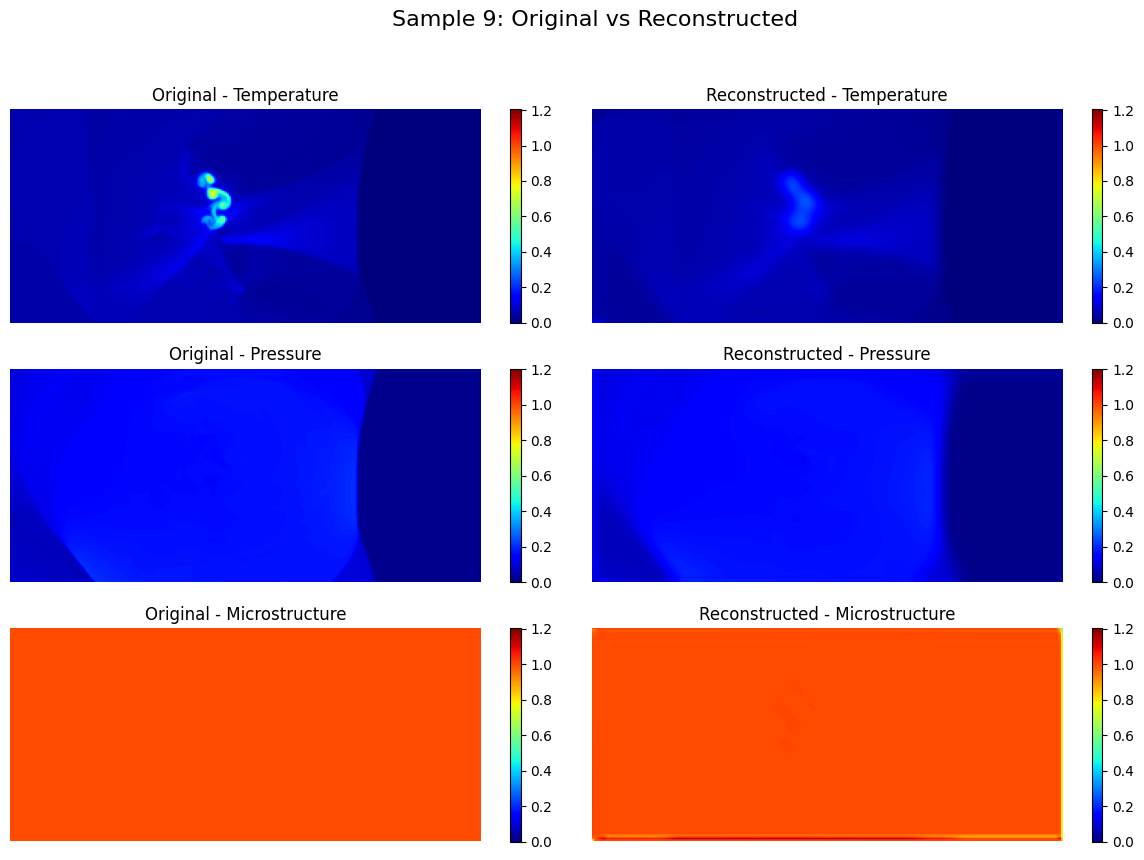

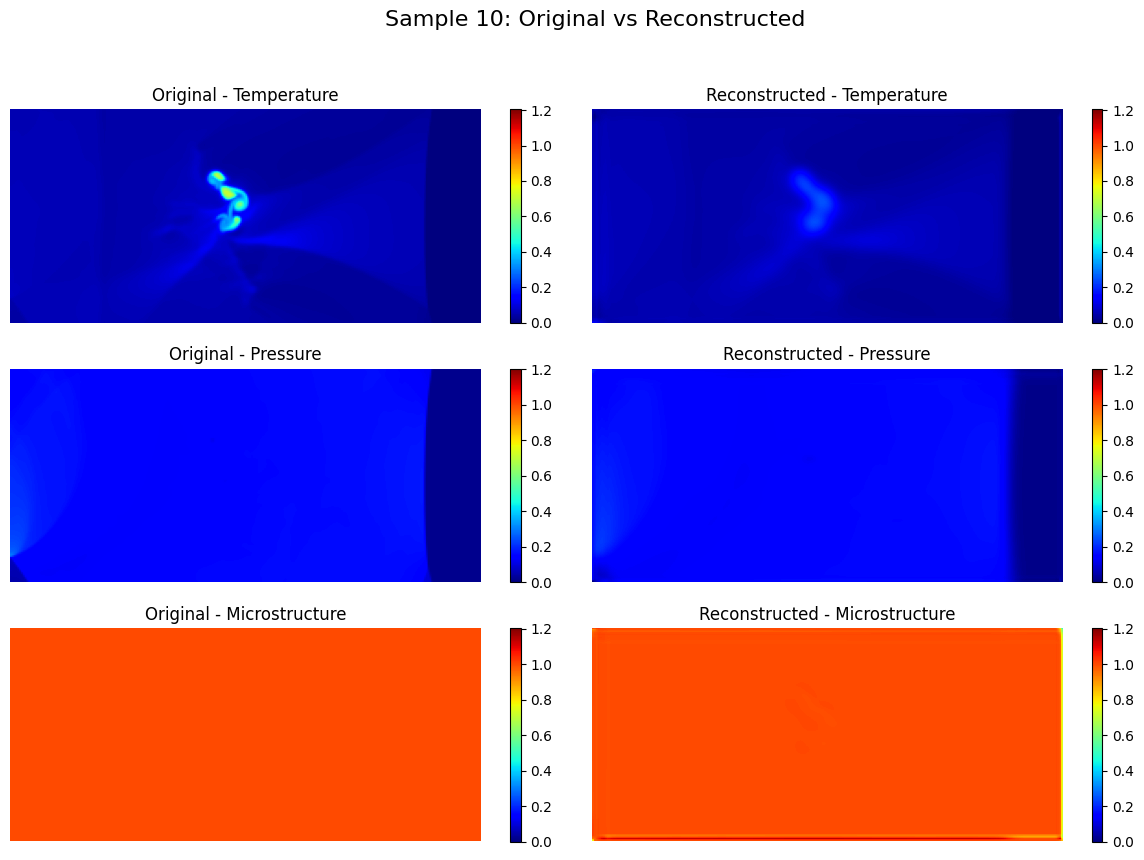

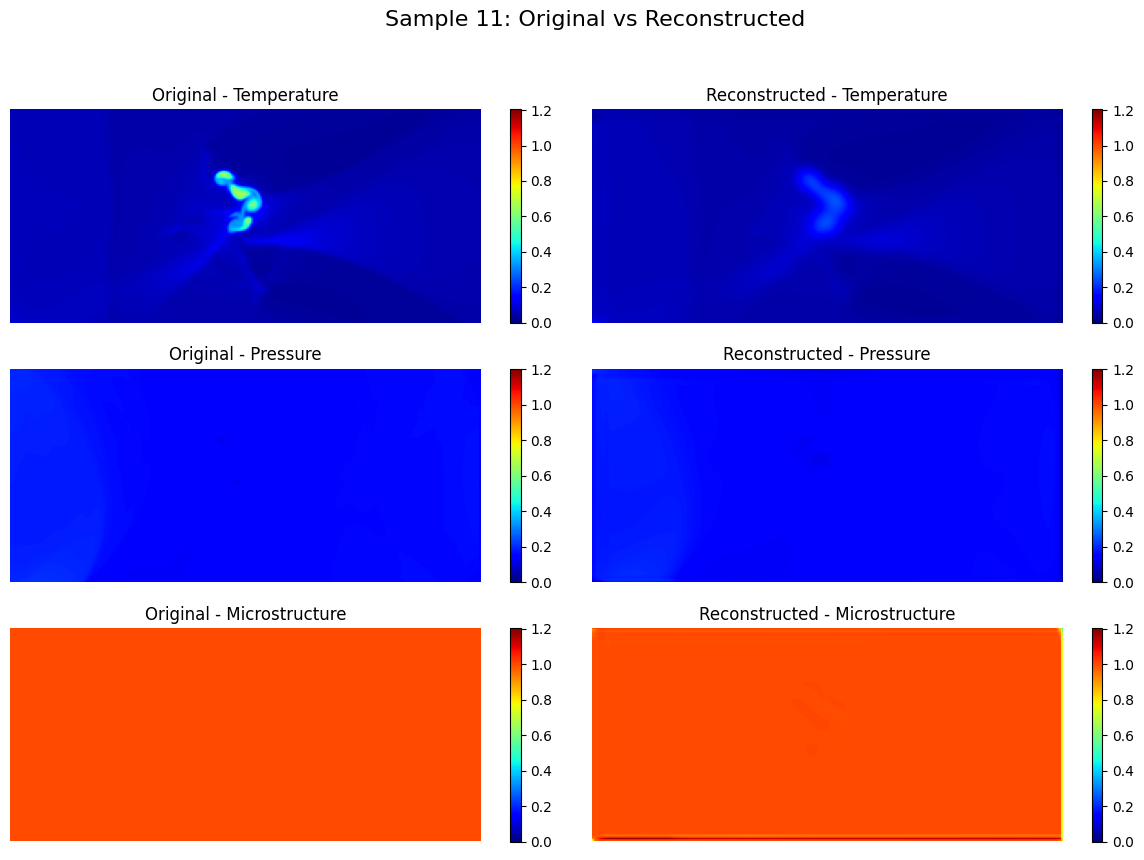

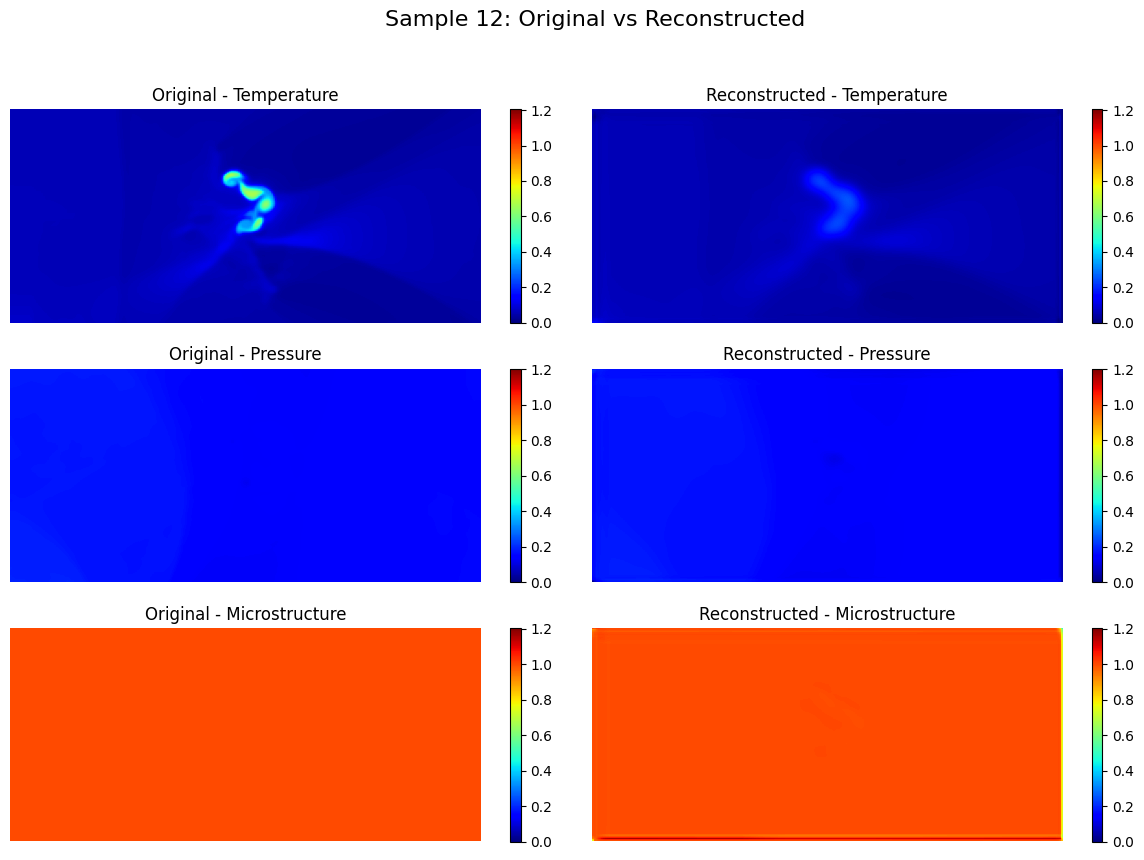

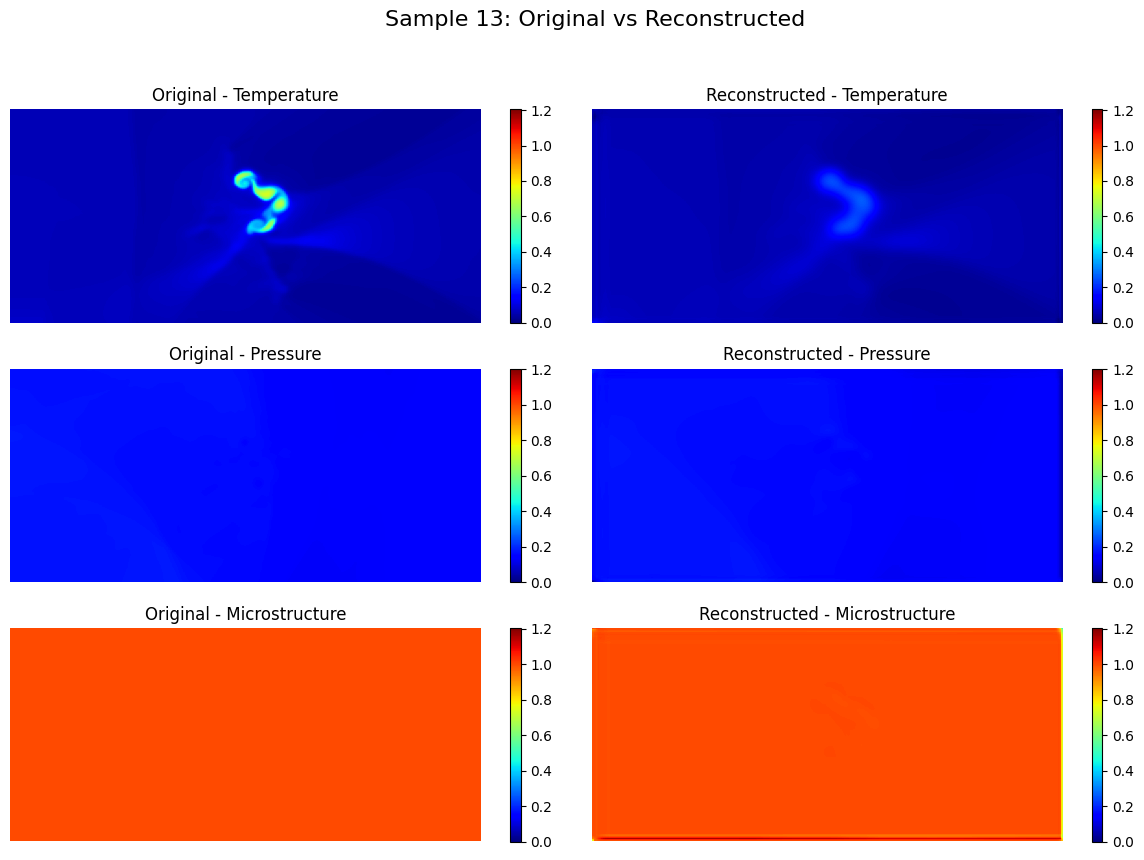

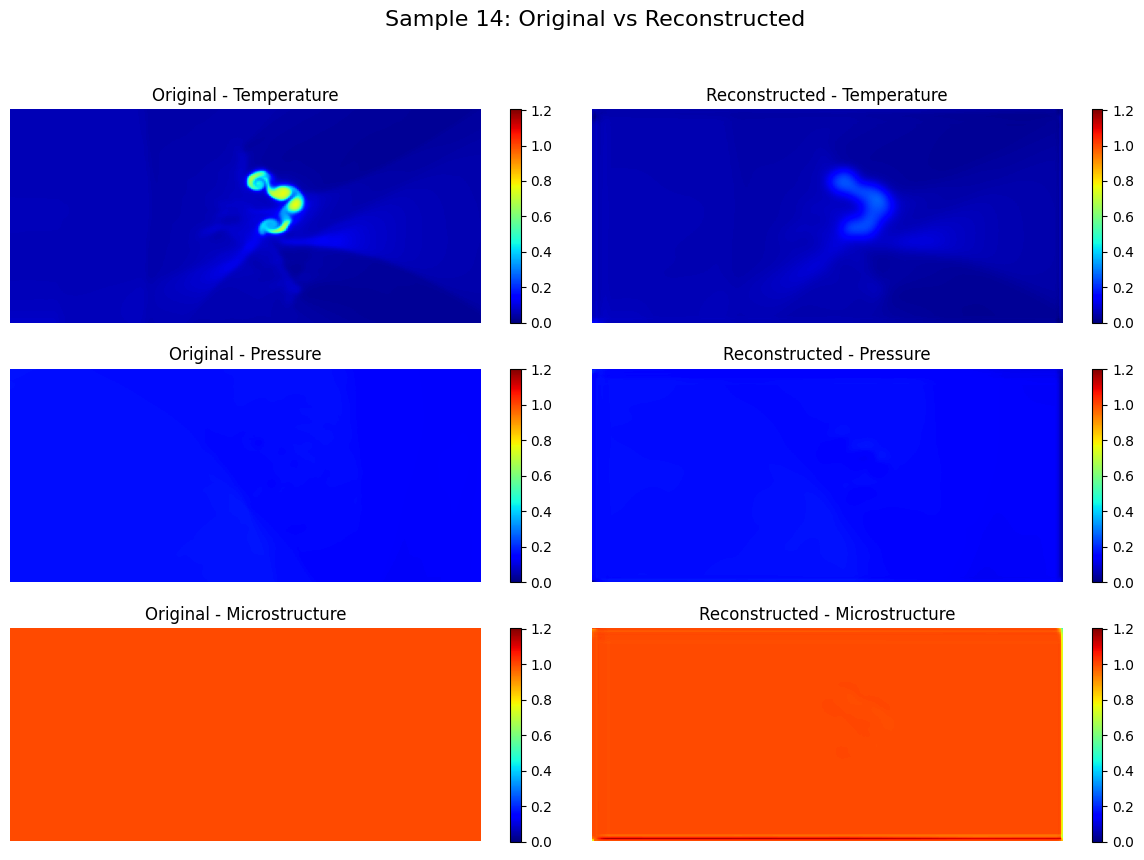

In [19]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (14ts each)
num_samples = n_ts-1  # Display up to 5 samples or fewer if dataset is smaller

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(X.min(), just_AE_reconstruction_pred.min())
global_max = max(X.max(), just_AE_reconstruction_pred.max())


# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = just_AE_reconstruction_pred[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()

### Z Hat Viz

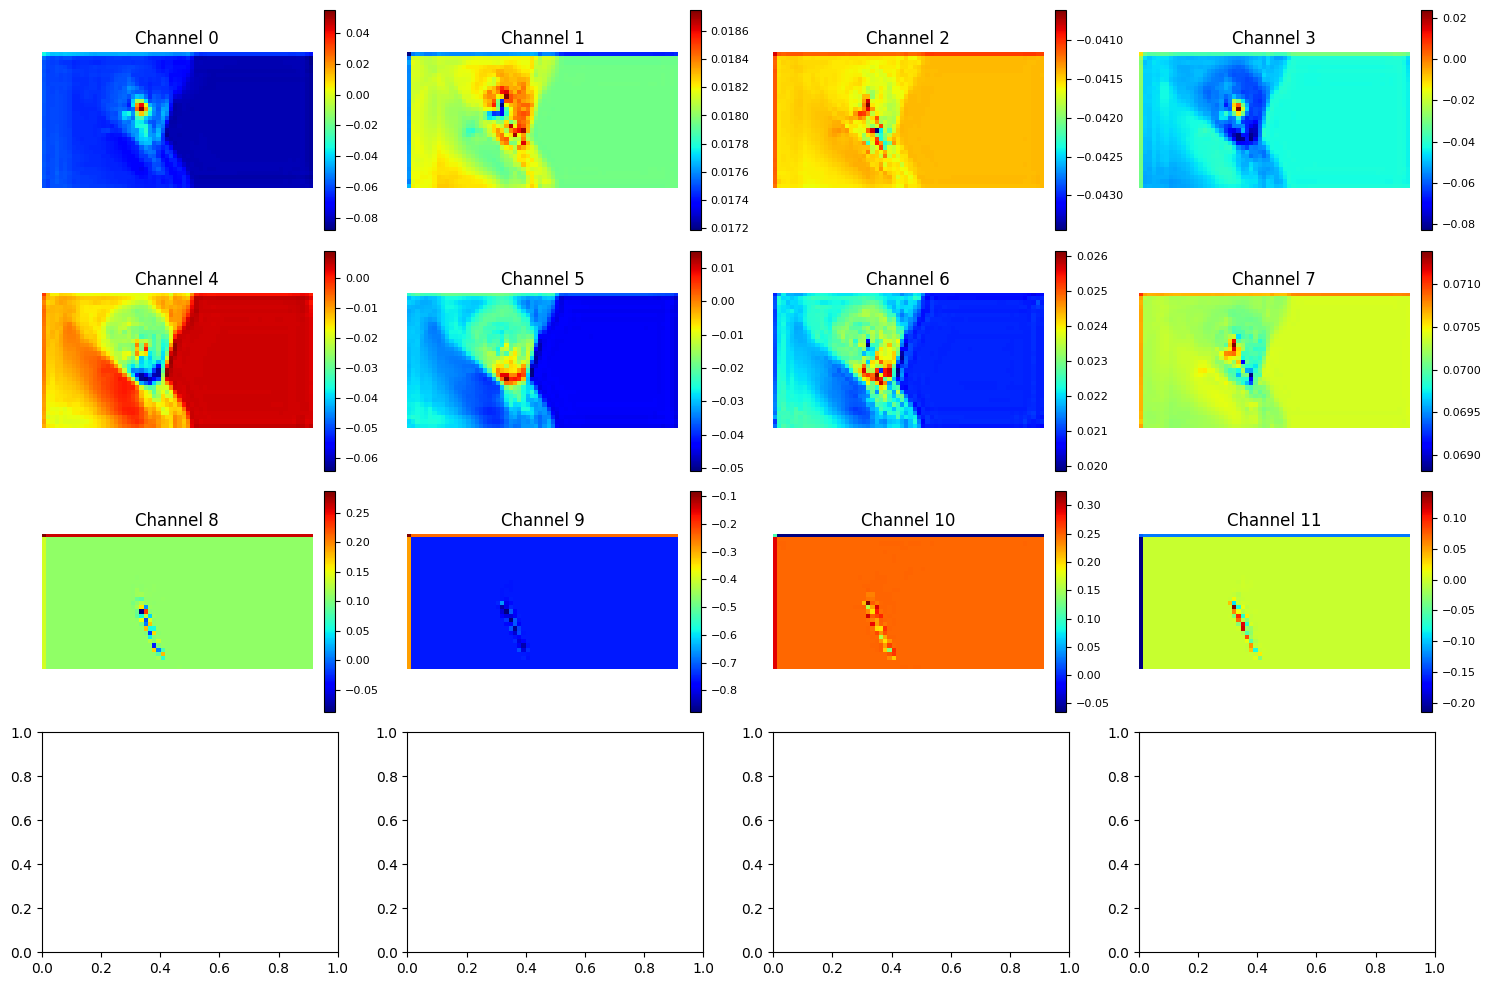

In [21]:
# select timestep to view
ts = 5
n_latent_channels = 12

# Extract the 16-channel image at timestep ts
images = single_ts_Zhat[ts, ...]

# Convert to CPU and numpy for visualization
images = images.cpu().detach().numpy()

# Plot all 16 channels in a 4x4 grid with colorbars
fig, axes = plt.subplots(4, 4, figsize=(15, 10))

for idx, ax in enumerate(axes.flat):
    if idx < n_latent_channels:
        im = ax.imshow(images[idx], cmap="jet")
        ax.set_title(f"Channel {idx}")
        ax.axis("off")

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

plt.tight_layout()
plt.show()

### Z_hat GIF

In [22]:
import imageio

n_latent_channels = 12

file_save_name = "2enc_1dec_layers_2_4_8_1_2_4_latent_12_single_ts_zhat_evolution"
frames = []

# Step 1: Compute per-channel vmin and vmax across all timesteps
all_data = single_ts_Zhat.cpu().detach().numpy()  # Shape: (timesteps, 16, H, W)
channel_vmin = all_data.min(axis=(0, 2, 3))  # Shape: (16,)
channel_vmax = all_data.max(axis=(0, 2, 3))  # Shape: (16,)

print("Per-channel vmin and vmax computed.")

# Step 2: Create GIF frames
for ts in range(n_ts - 1):
    images = all_data[ts]  # Shape: (16, H, W)

    fig, axes = plt.subplots(4, 4, figsize=(15, 10))

    for idx, ax in enumerate(axes.flat):
        if idx < n_latent_channels:
            im = ax.imshow(
                images[idx],
                cmap="jet",
                vmin=channel_vmin[idx],
                vmax=channel_vmax[idx]
            )
            ax.set_title(f"Channel {idx}")
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()

    # Save frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = frame[..., :3]  # Remove alpha channel
    frames.append(frame)

    plt.close(fig)

# Step 3: Save GIF with infinite loop and longer duration
imageio.mimsave(
    f'{file_save_name}.gif',
    frames,
    duration=500,
    loop=0
)

print(f"GIF saved as '{file_save_name}.gif'")

Per-channel vmin and vmax computed.
GIF saved as '2enc_1dec_layers_2_4_8_1_2_4_latent_12_single_ts_zhat_evolution.gif'


### AE + Dynamics Evaluation (SNAPSHOT SINGLE TS)

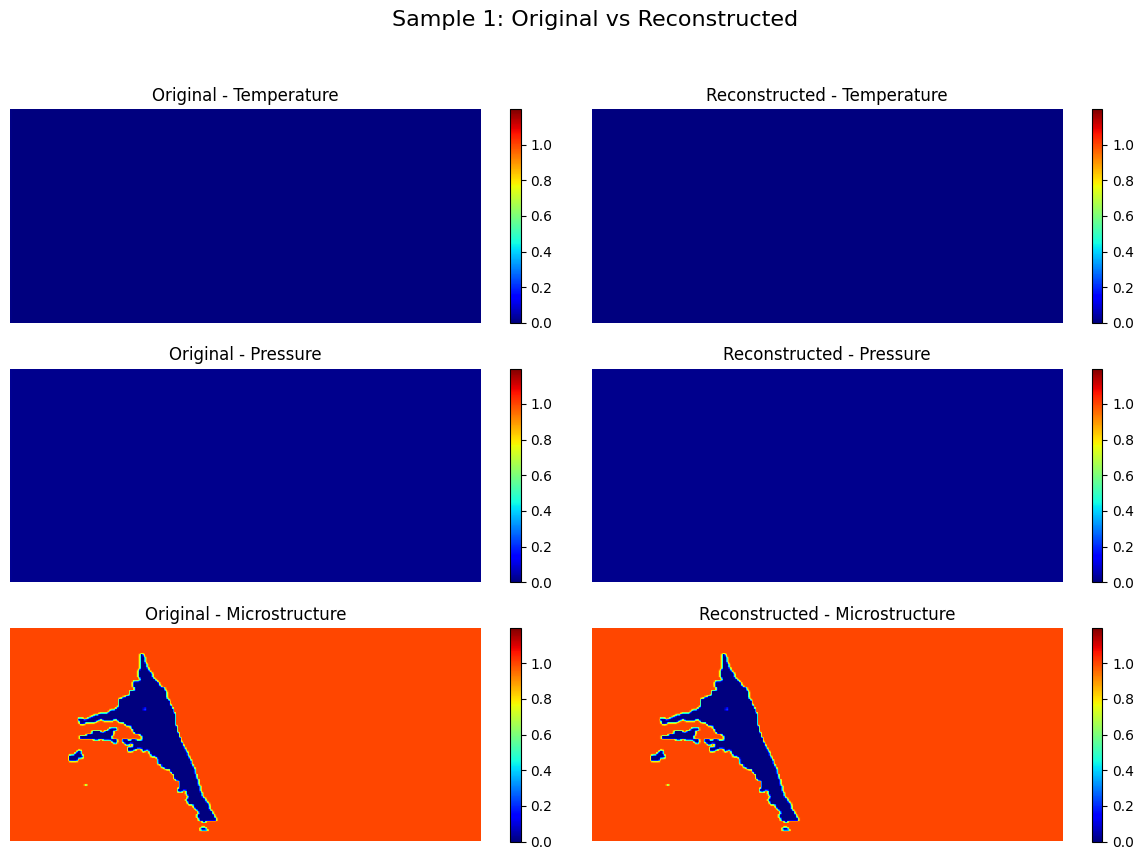

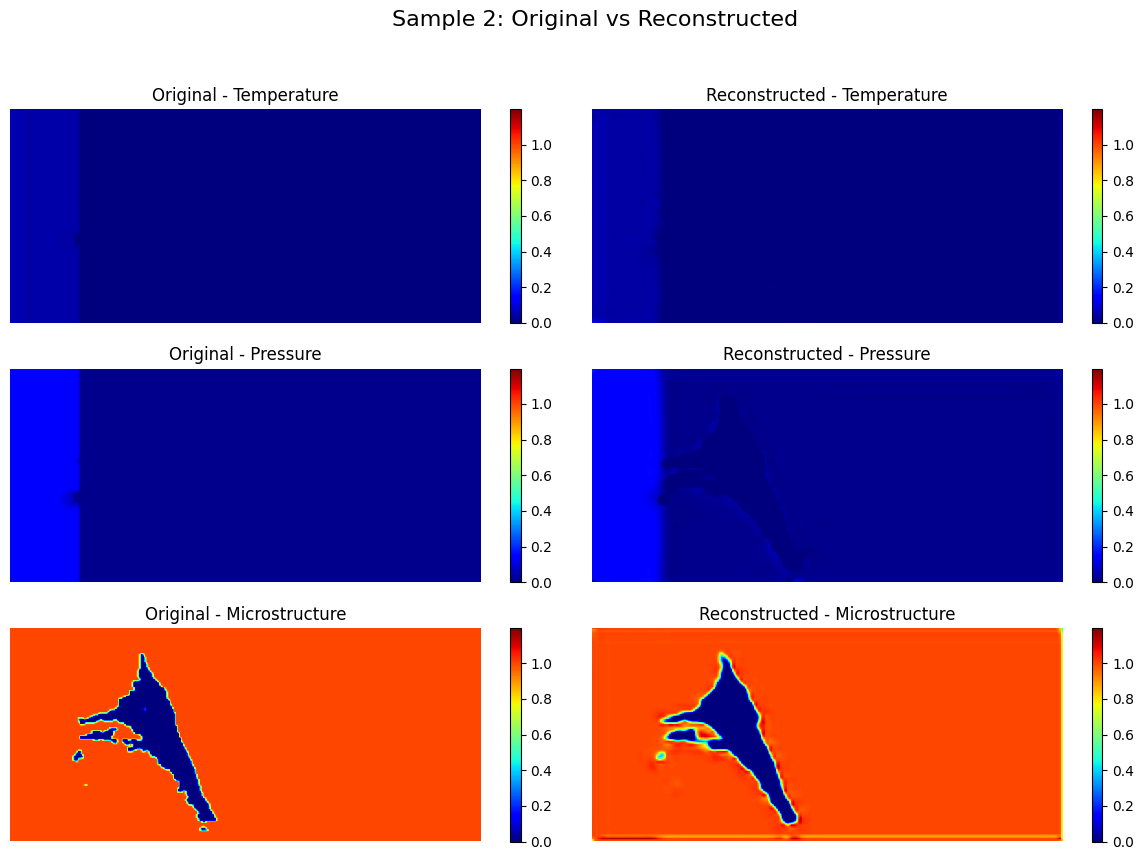

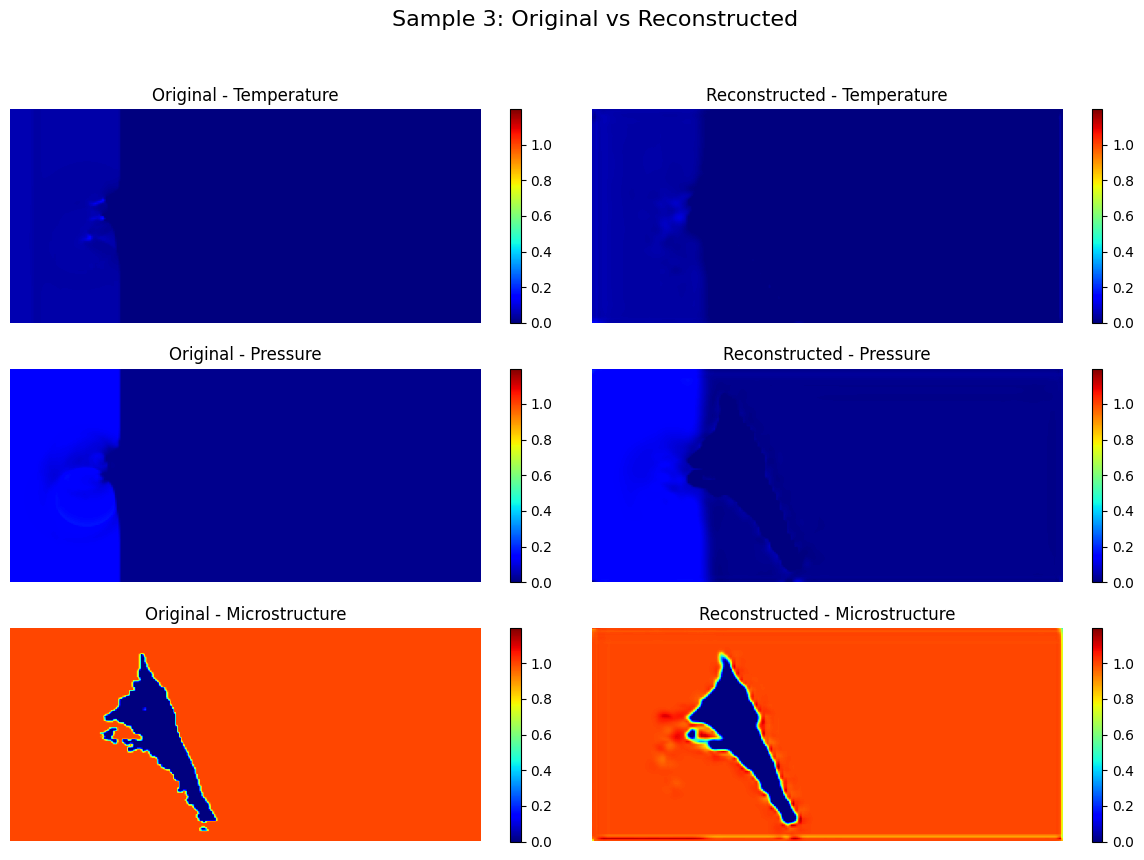

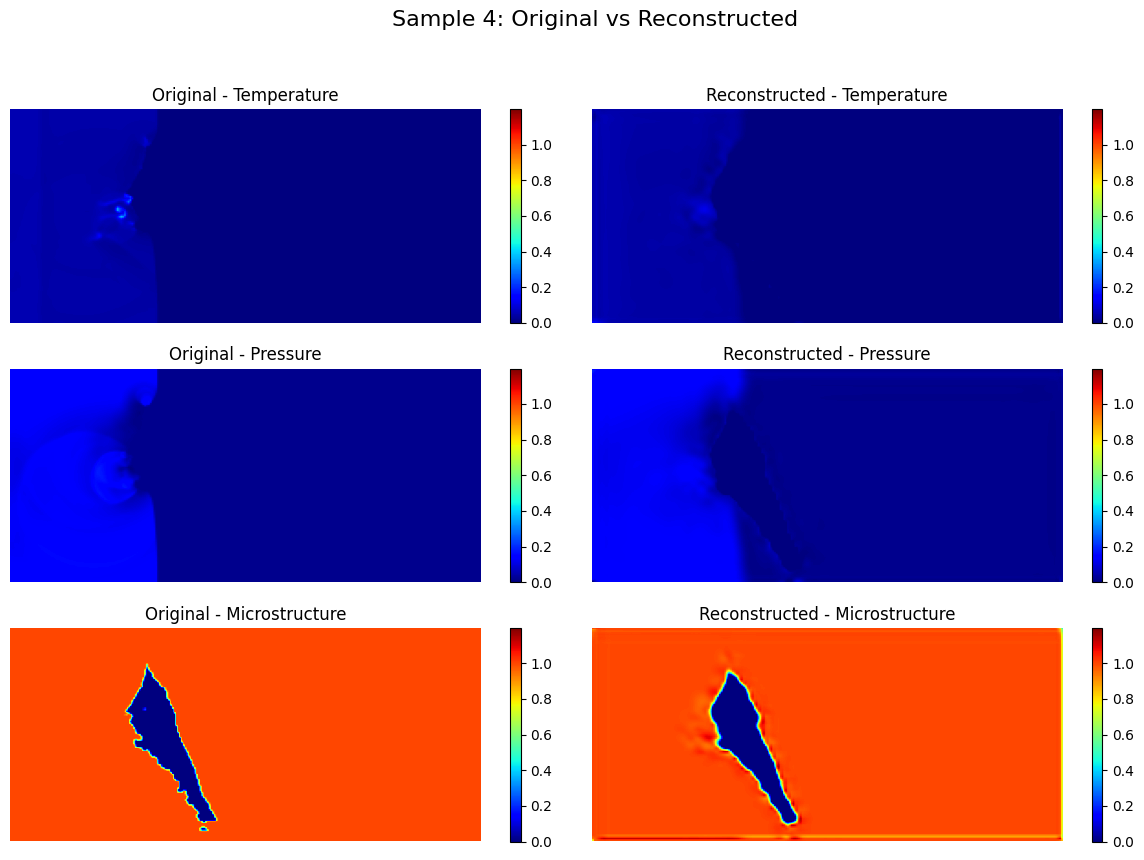

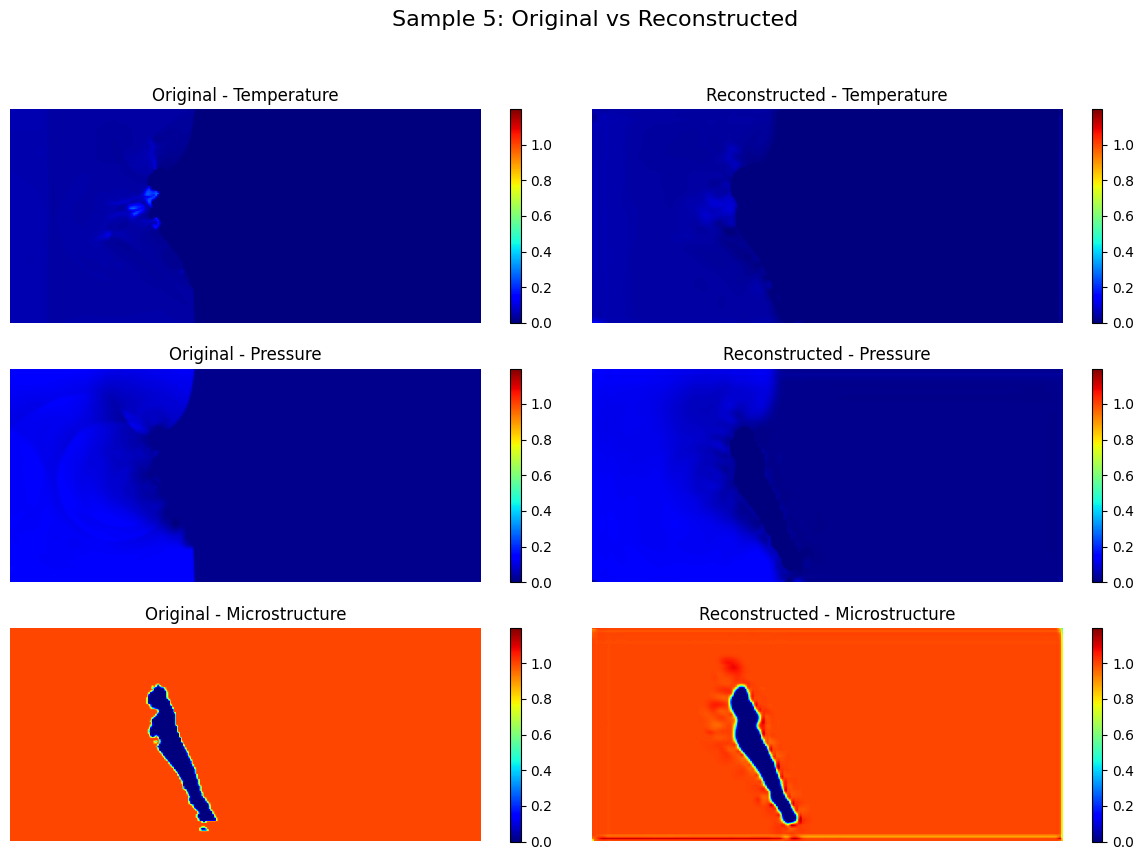

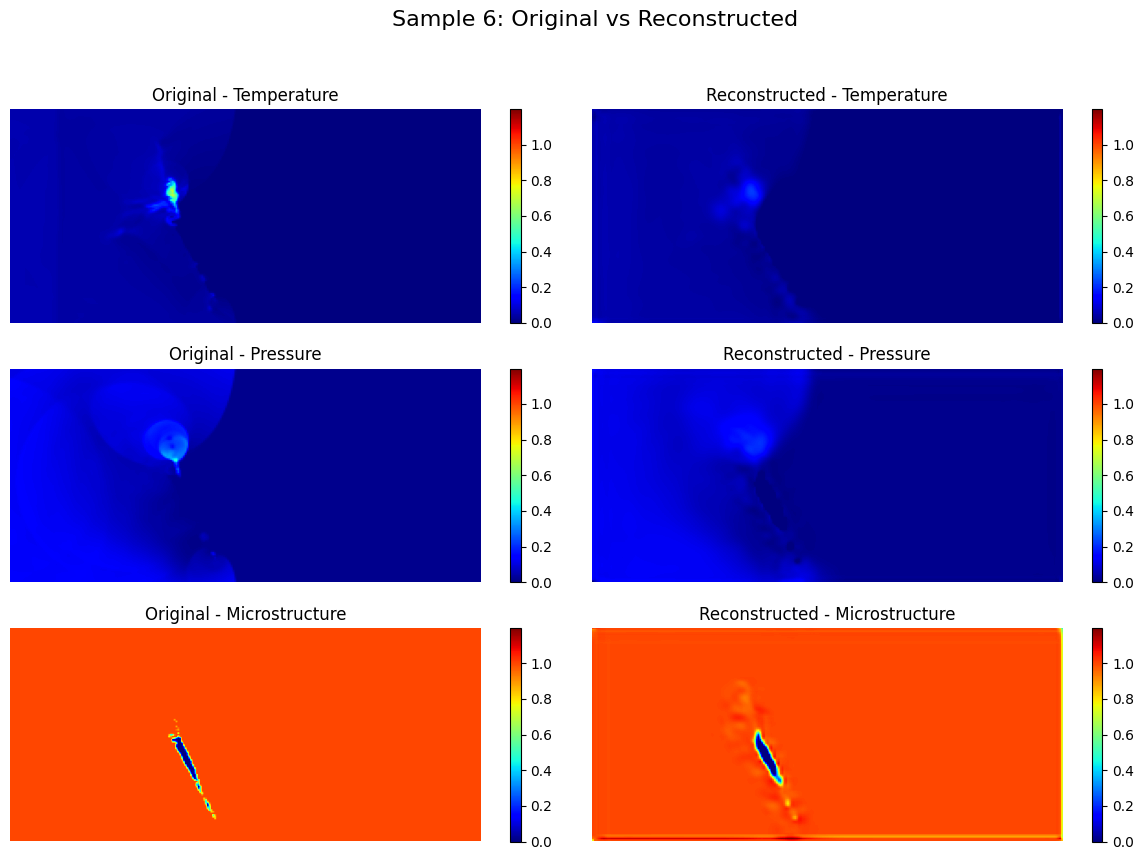

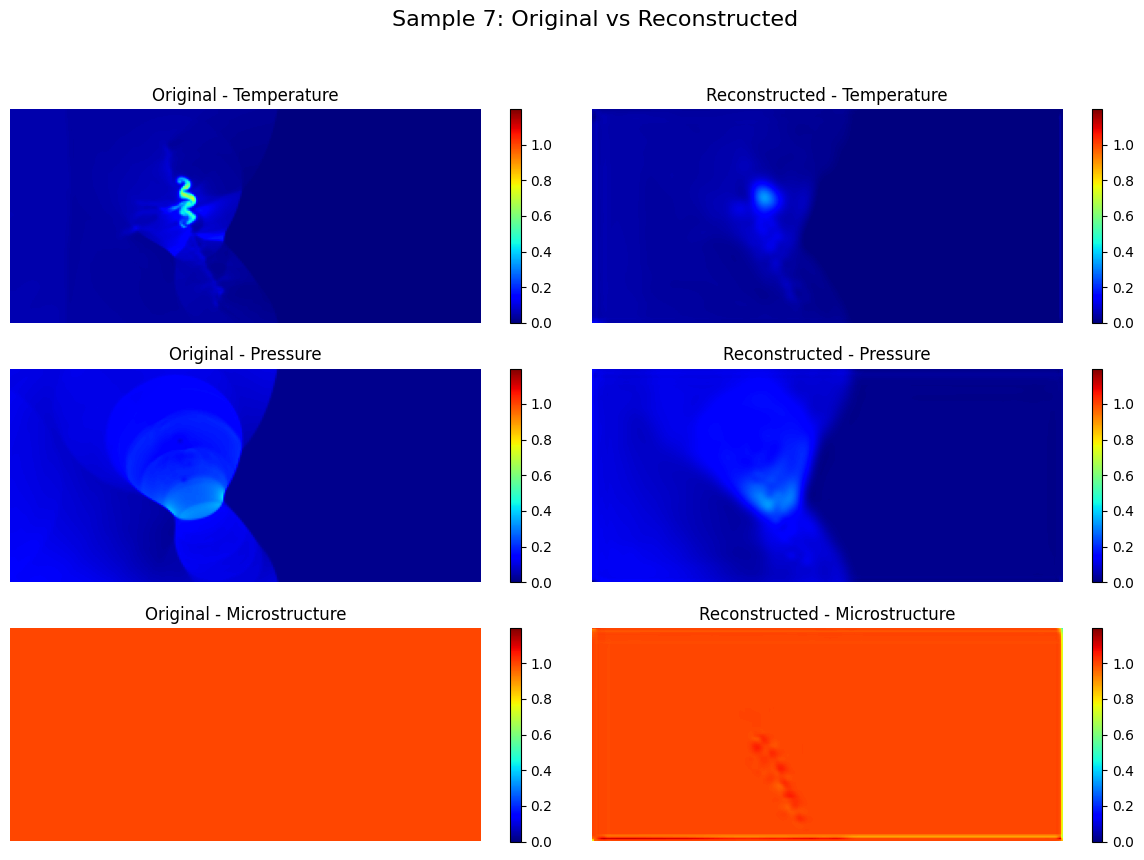

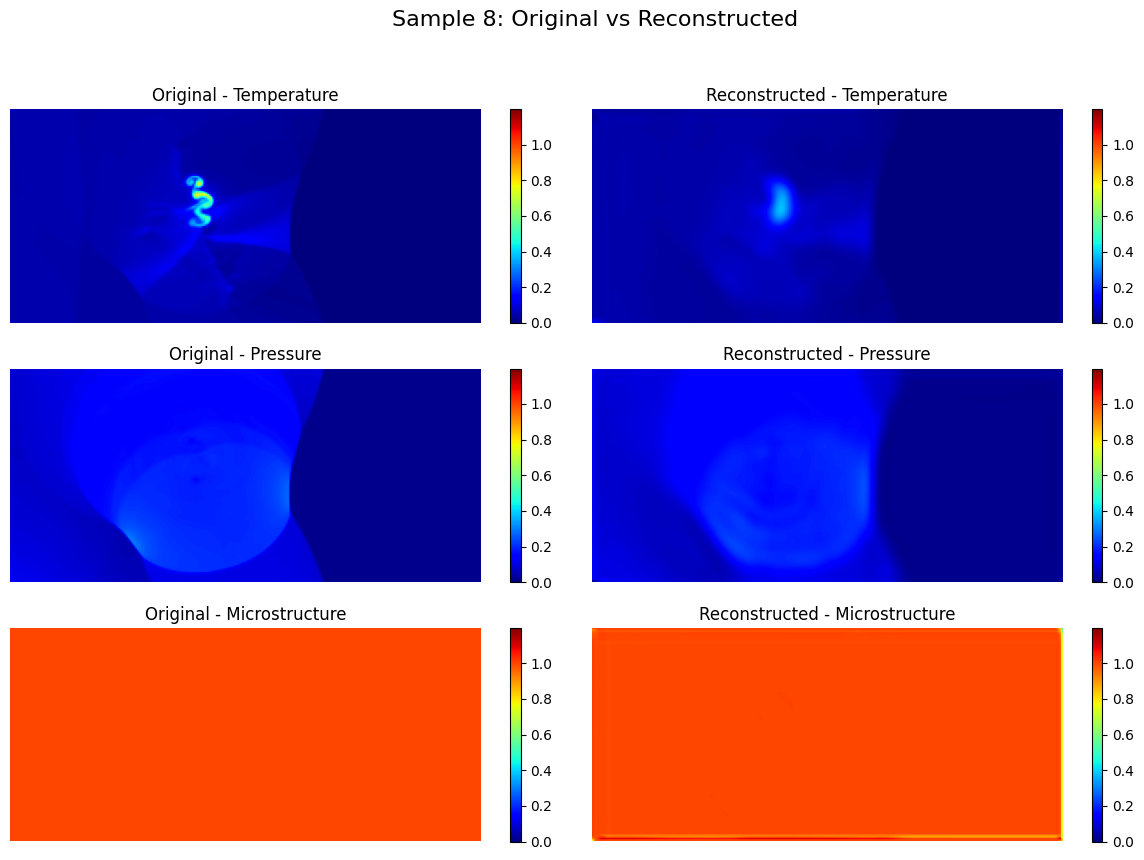

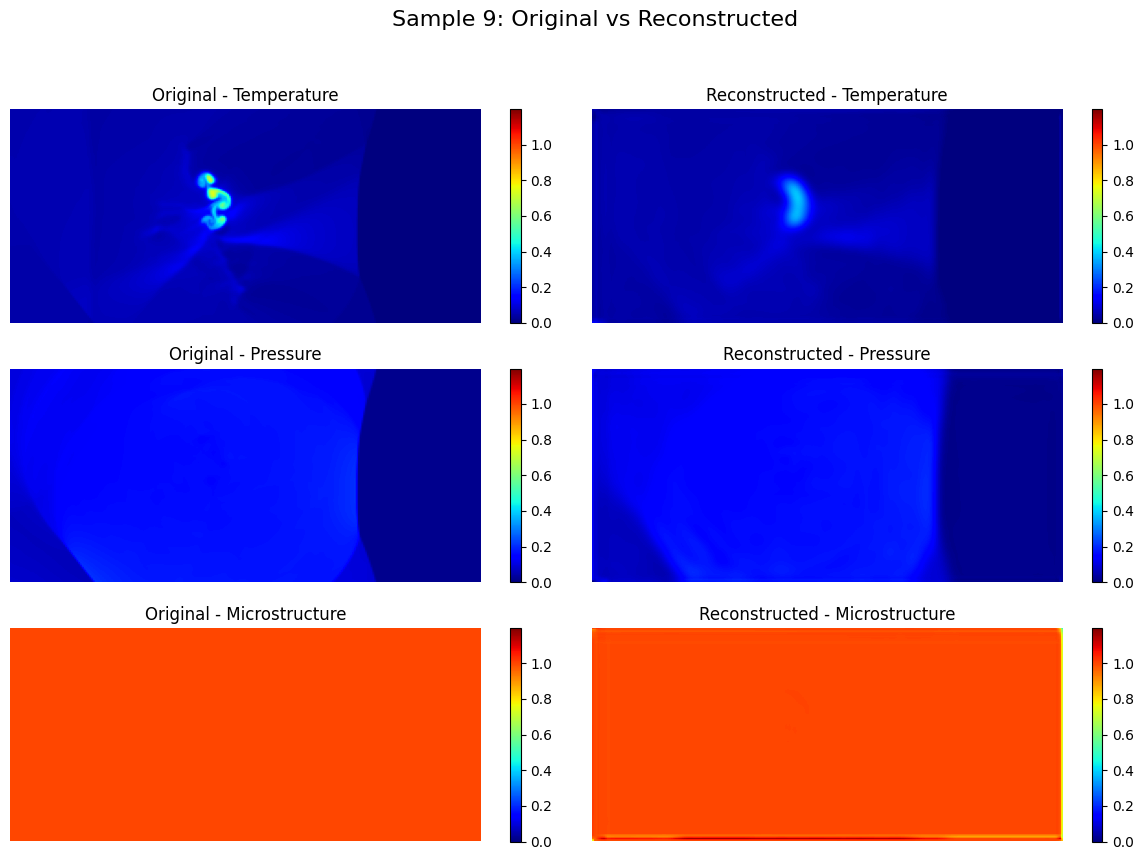

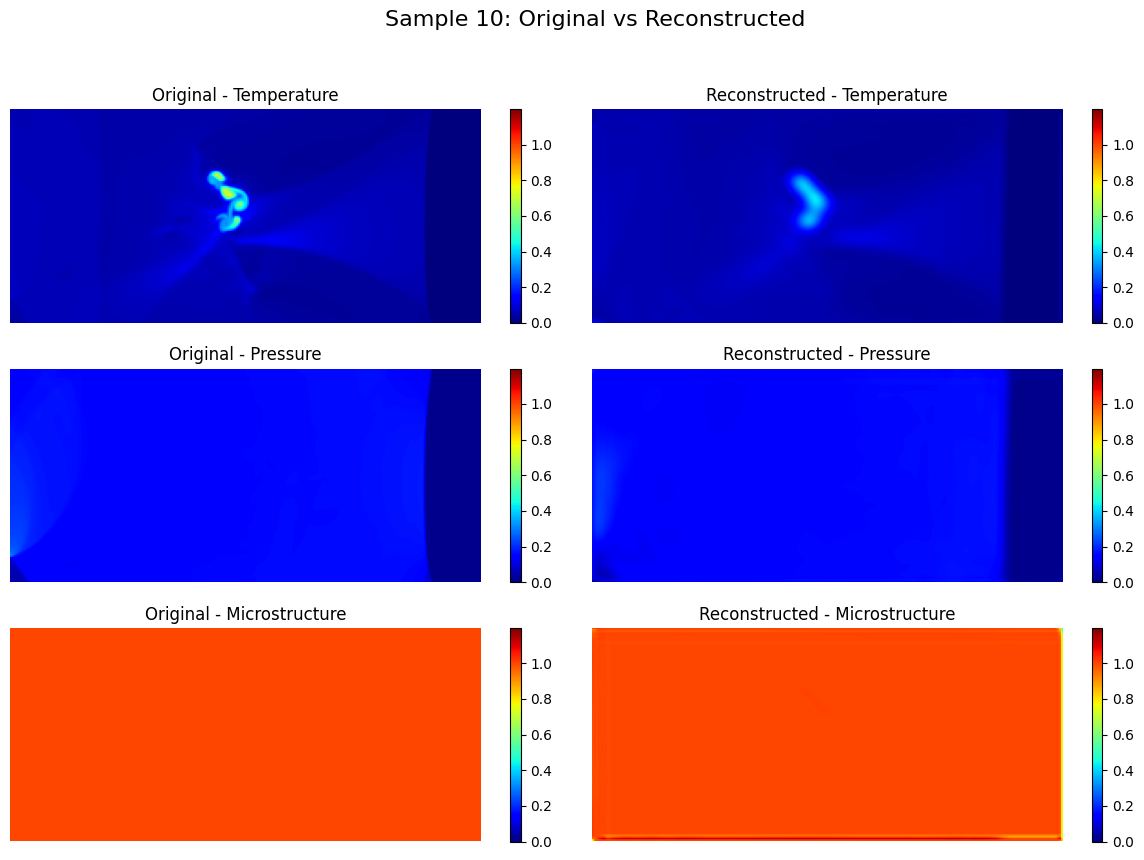

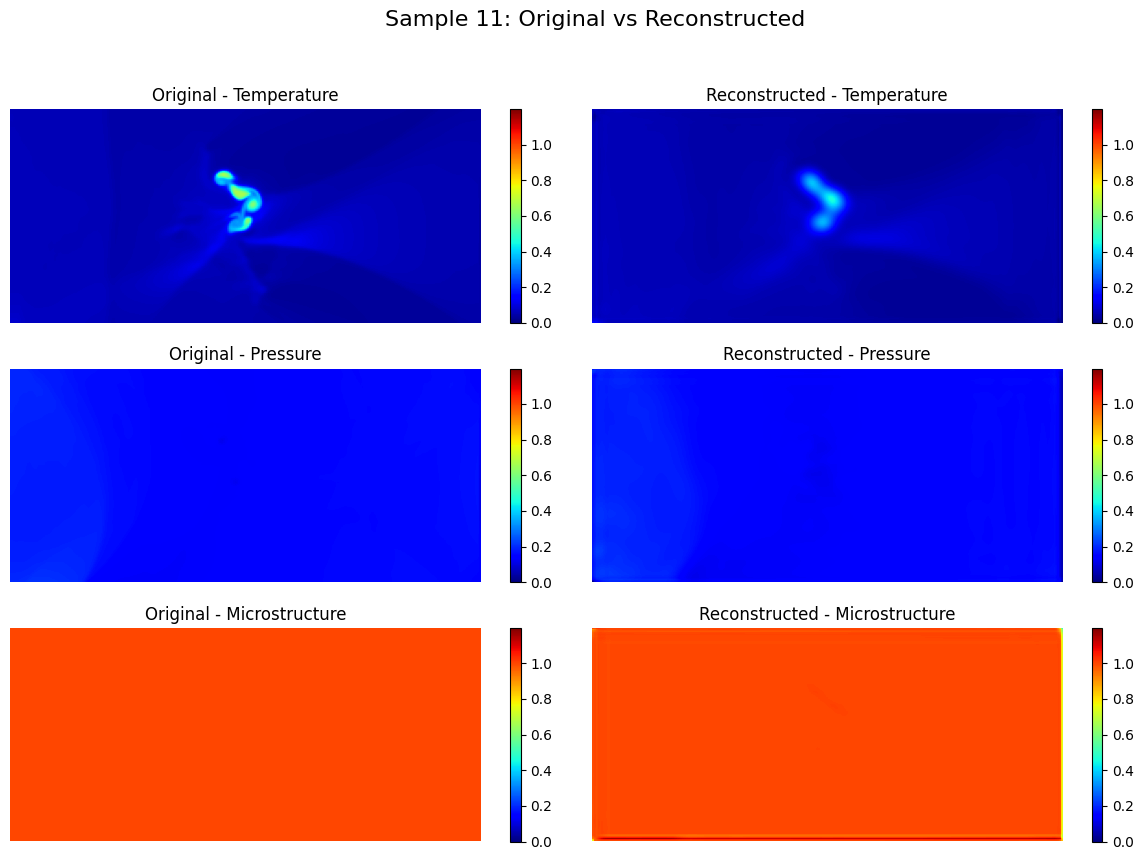

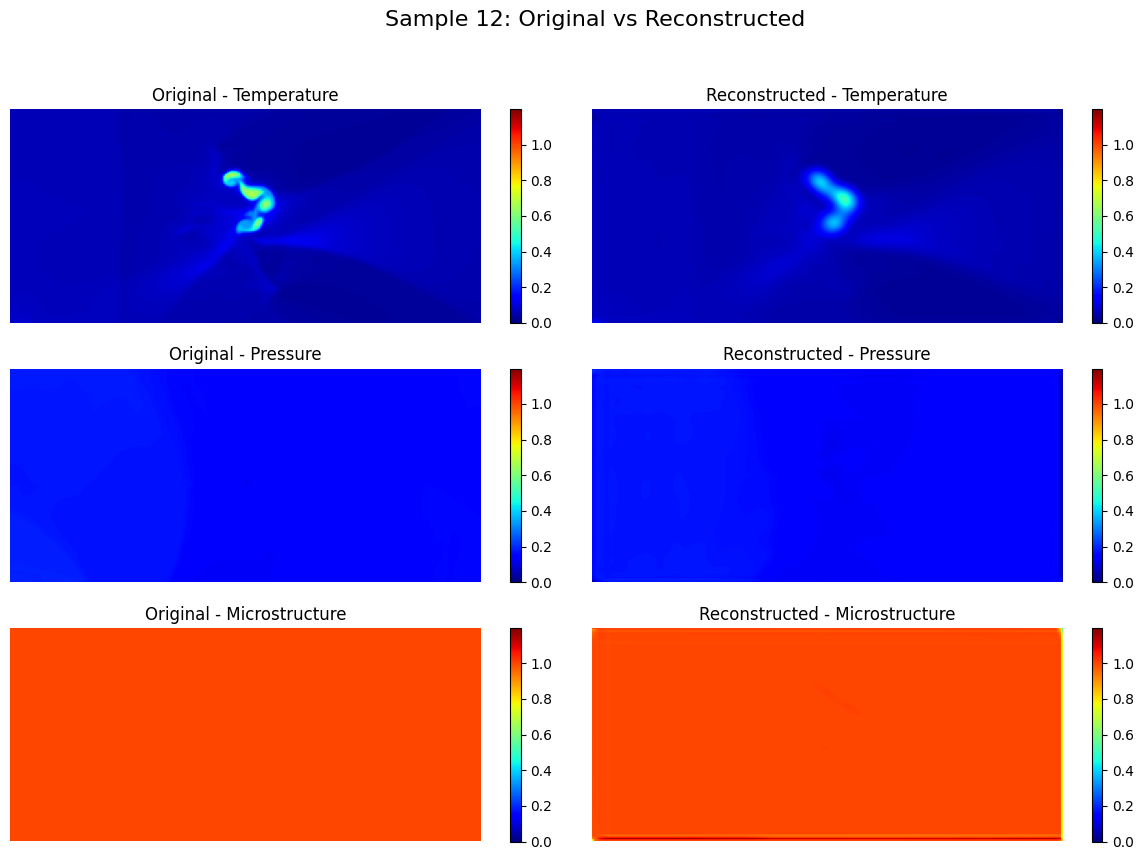

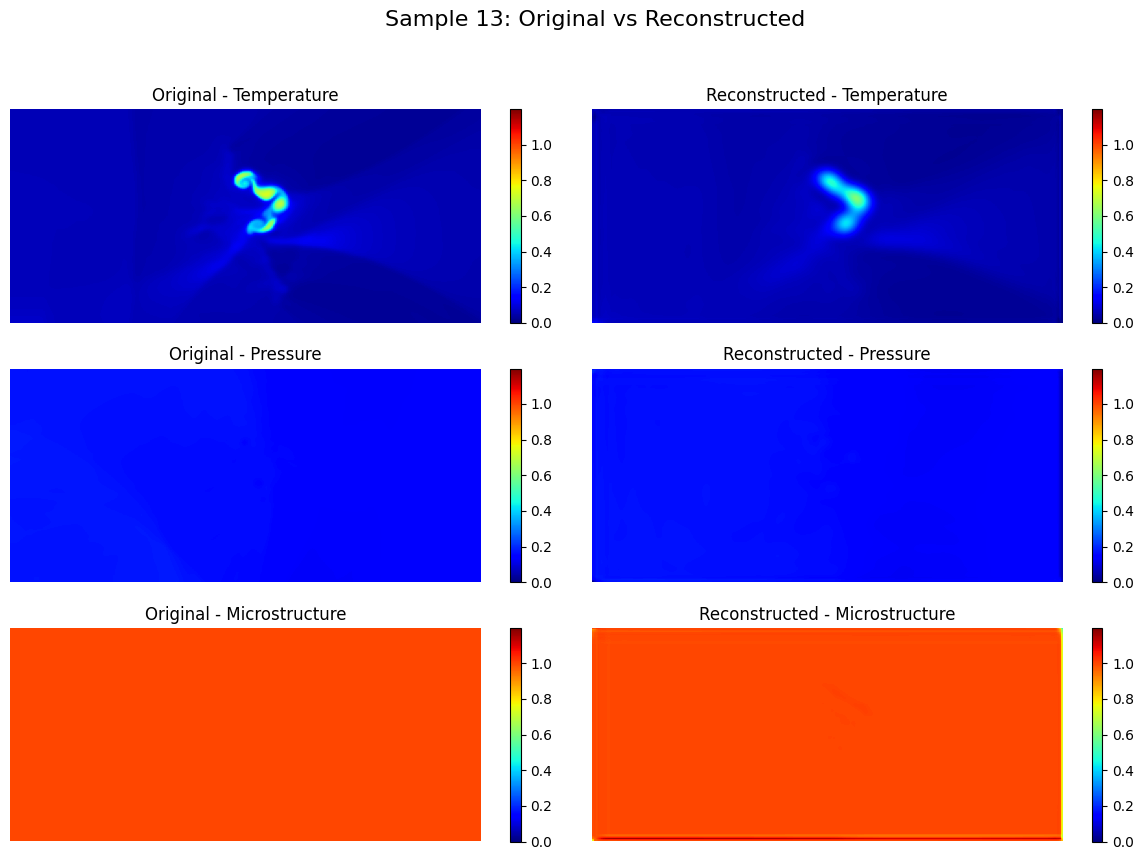

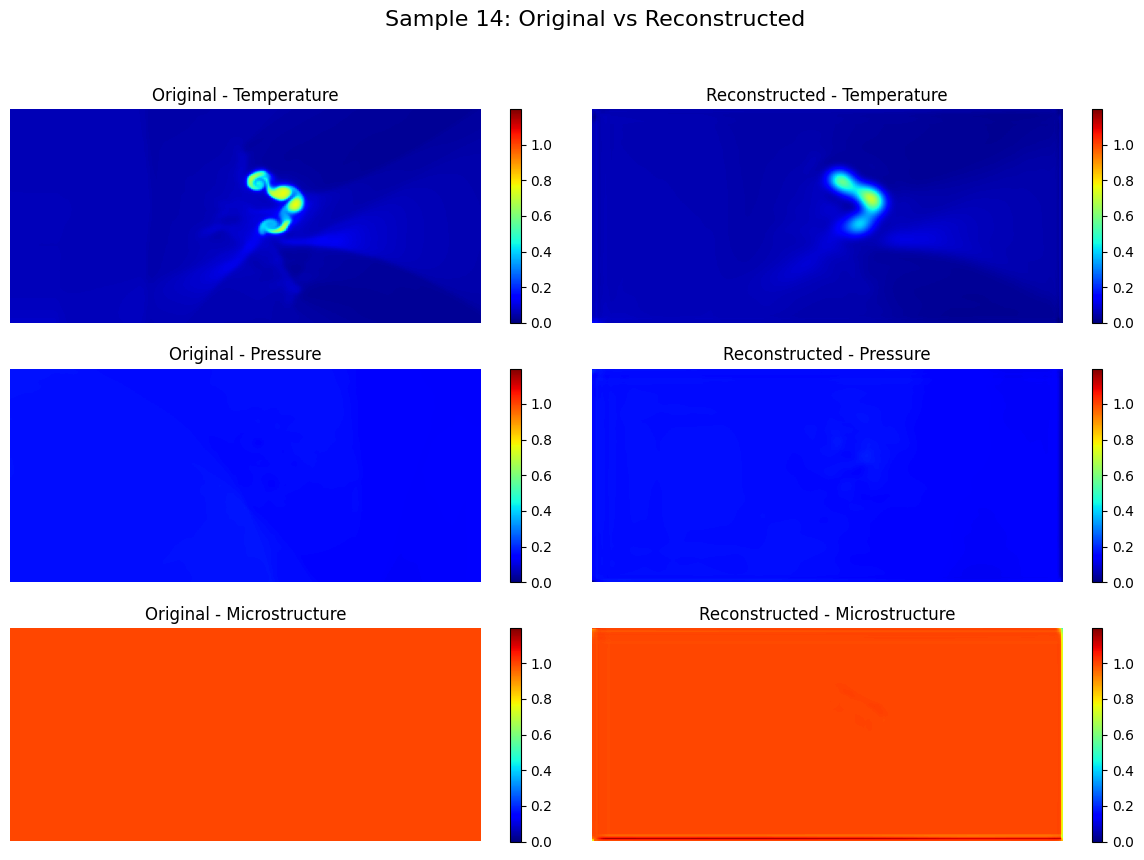

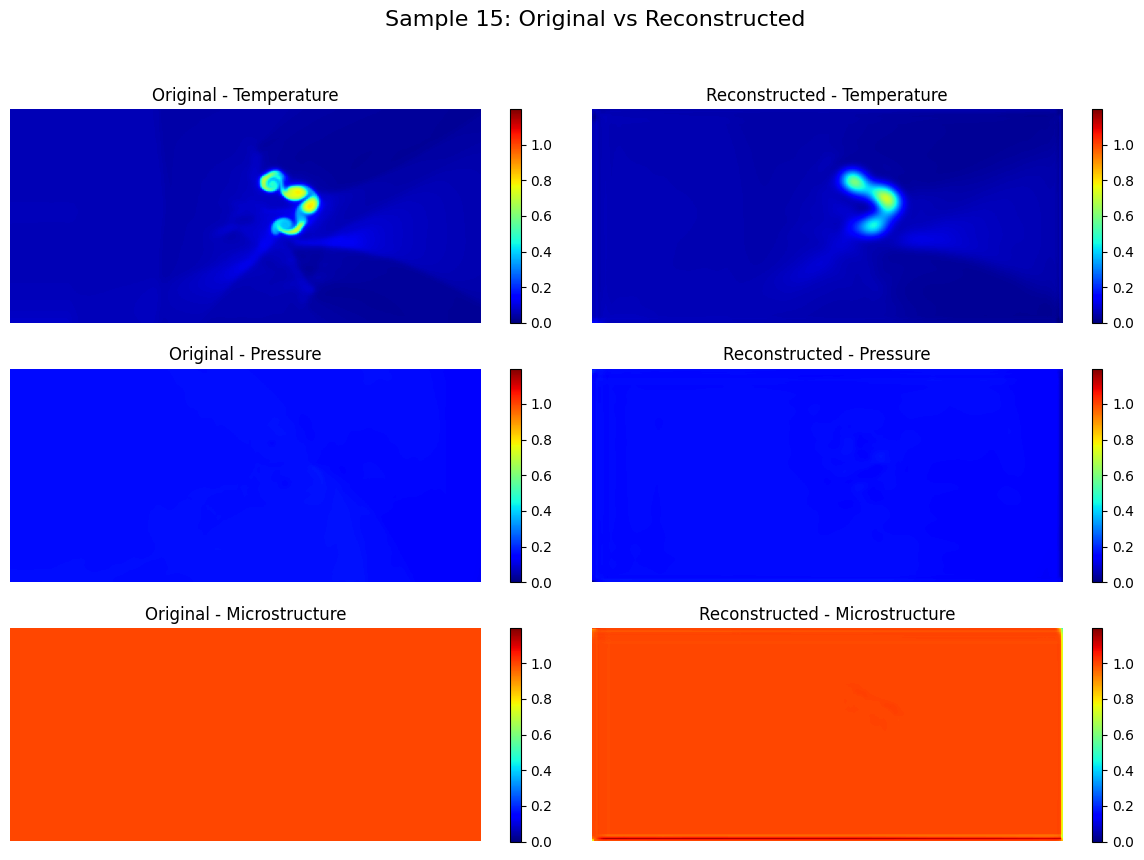

In [23]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
num_samples = n_ts
# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(X.min(), single_ts_full_reconstruction_pred.min())
global_max = max(X.max(), single_ts_full_reconstruction_pred.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = single_ts_full_reconstruction_pred[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()

### GIF

In [24]:
from PIL import Image

file_name = "2enc_1dec_layers_2_4_8_1_2_4_latent_12_single_ts_predictions"
plot_name = "Single ts Prediction, 1 Encoder 1 Decoder, no purple loss Layers 3 8, Latent Dim 16, 2 Test Samples, 3000 Epochs"

# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
# num_samples = min(28, single_ts_full_reconstruction_GT.shape[0])  # Display up to 30 samples or fewer if dataset is smaller
num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(X.min(), single_ts_full_reconstruction_pred.min())
global_max = max(X.max(), single_ts_full_reconstruction_pred.max())

frames = []  # List to store frames for GIF

# Iterate over the selected samples (each sample represents a time step)
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=150, constrained_layout=True)  # Reduced figsize and dpi for smaller GIF
    fig.suptitle(plot_name, fontsize=12)  # Reduced font size for title
    
    for channel_idx, channel_name in enumerate(channel_names):
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        reconstructed_channel = single_ts_full_reconstruction_pred[sample_idx, channel_idx, :, :].numpy()
        
        # Plot original
        ax = axes[0, channel_idx]
        ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (GT)", fontsize=10)  # Smaller title font size
        ax.axis("off")
        
        # Plot reconstructed
        ax = axes[1, channel_idx]
        ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (Pred)", fontsize=10)  # Smaller title font size
        ax.axis("off")
    
    # Convert the figure to a PIL Image and append to frames
    fig.canvas.draw()  # Draw the figure onto the canvas
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to image dimensions
    frames.append(Image.fromarray(img))

    plt.close(fig)

# Check if frames are created successfully
if len(frames) == 0:
    print("Error: No frames generated!")
else:
    # Save frames as GIF
    gif_path = file_name + ".gif"
    try:
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")
    except Exception as e:
        print(f"Error saving GIF: {e}")


/tmp/ipykernel_3225/2086072503.py:42: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to 2enc_1dec_layers_2_4_8_1_2_4_latent_12_single_ts_predictions.gif


# Rollout Preds

### External Rollout

In [25]:
n_ts = 15

ic = X[0, ...].unsqueeze(0)

pred_z = []
pred_decoded = []

for t in range(n_ts-1):
    if t==0:
        IC = ic.to(device)
    
    else:
        IC = pred_decoded[t-1].to(device)
        
    with torch.no_grad():
        # Reconstructing test images
        z_hat, x_hat = model.network(IC, n_ts=1)
    pred_z.append(z_hat.cpu())
    pred_decoded.append(x_hat.cpu())
    
pred_z = torch.cat(pred_z, dim=0)

pred_decoded = torch.cat(pred_decoded, dim=0)
pred_decoded = torch.concat((ic, pred_decoded))

In [26]:
pred_z.shape, pred_decoded.shape

(torch.Size([14, 12, 32, 64]), torch.Size([15, 3, 128, 256]))

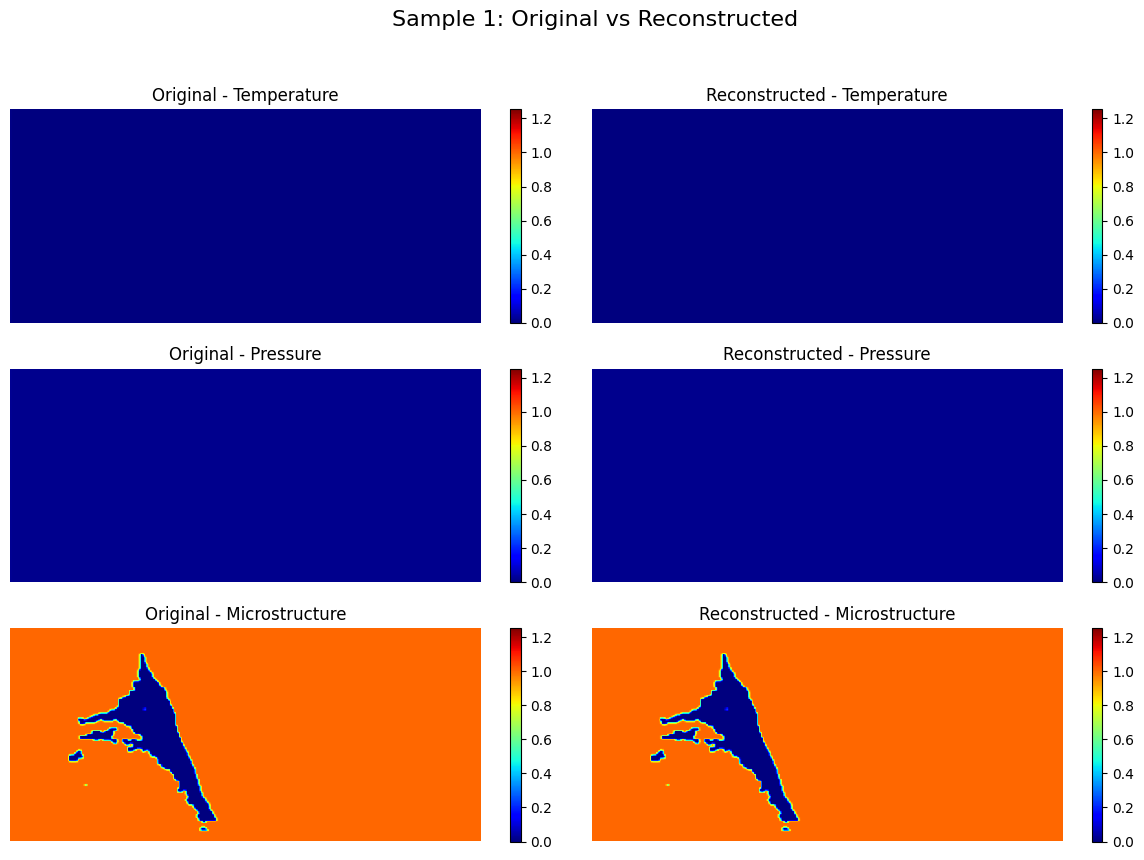

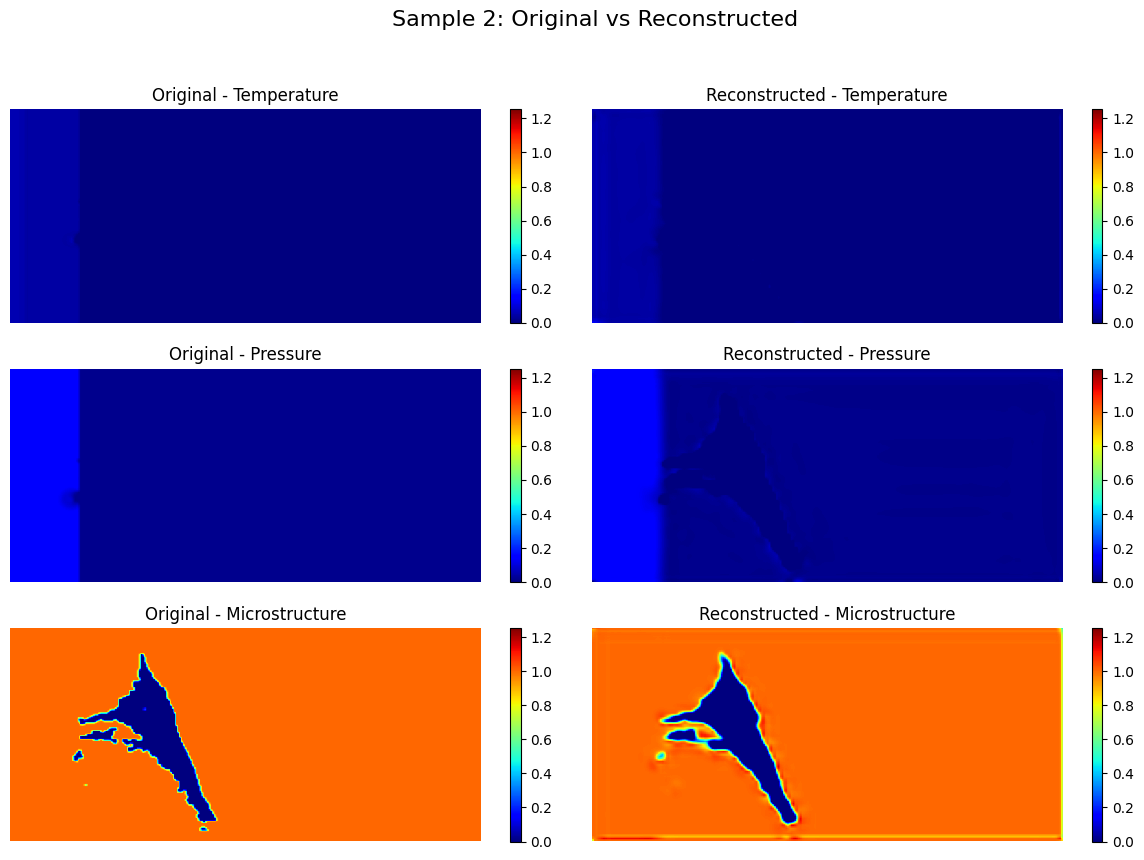

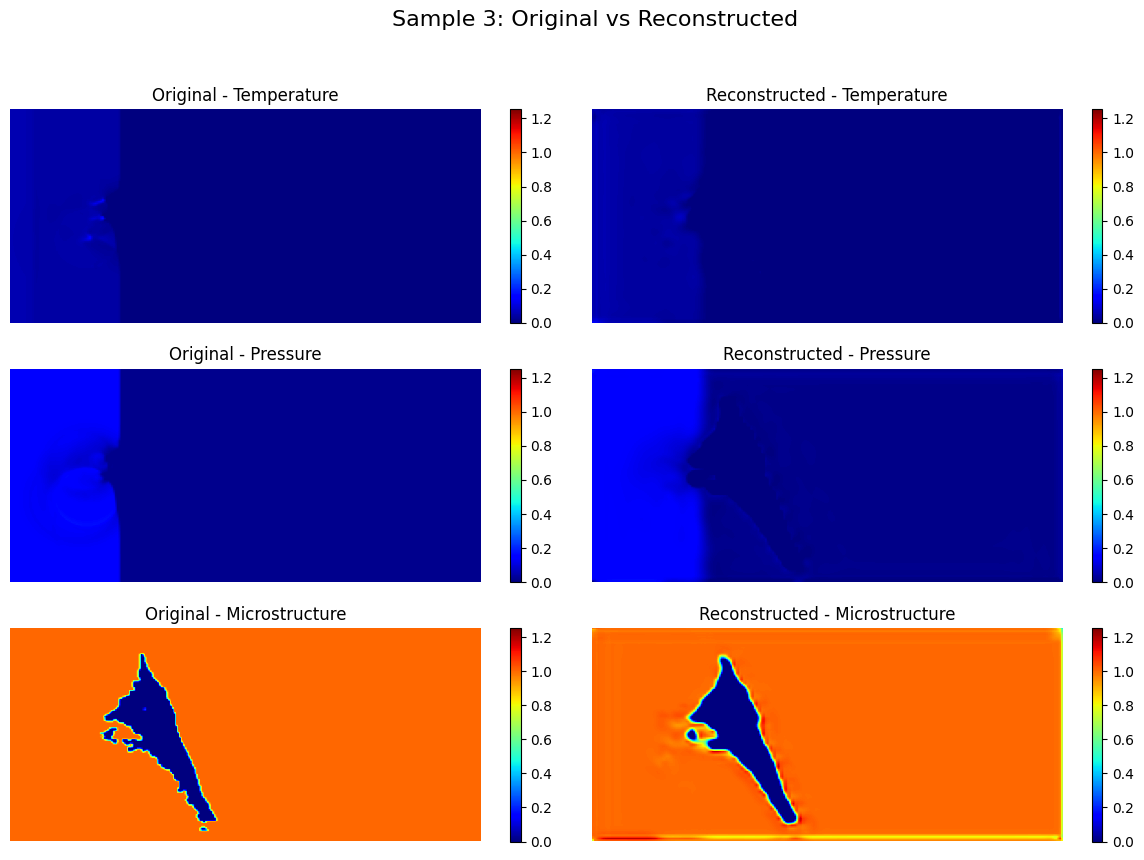

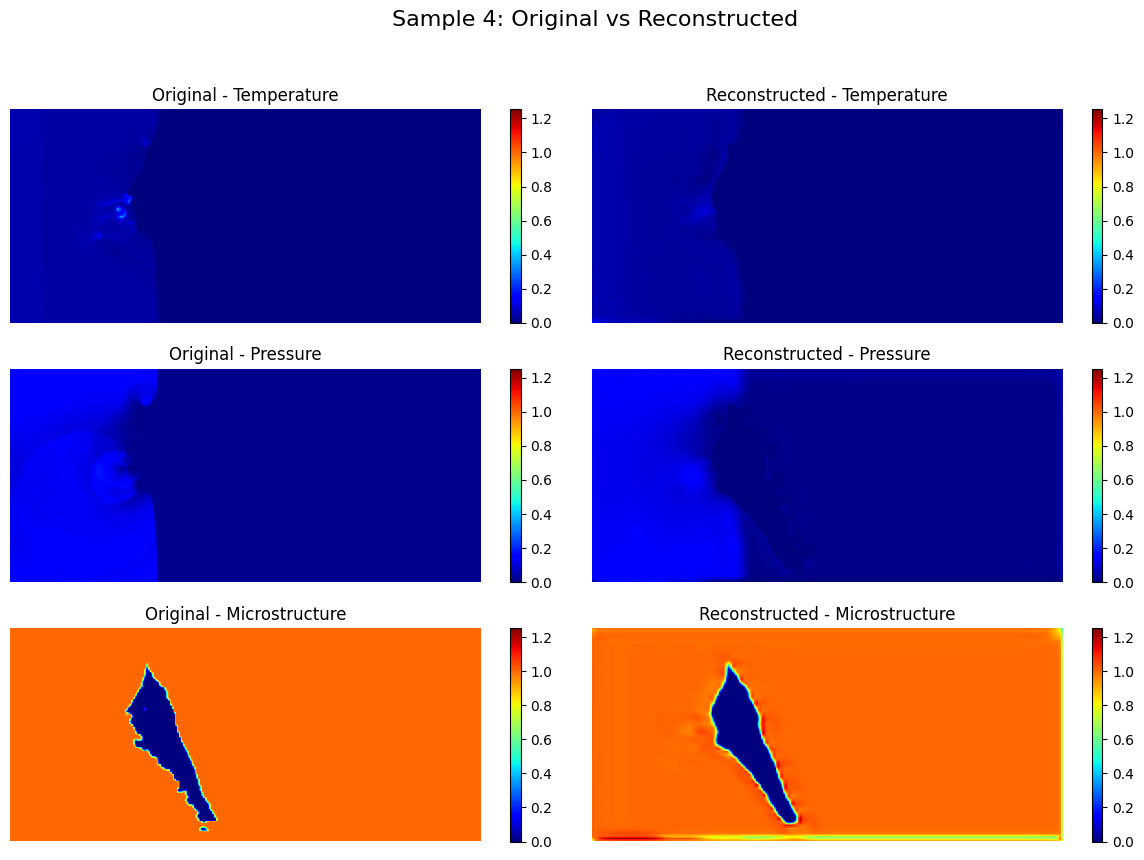

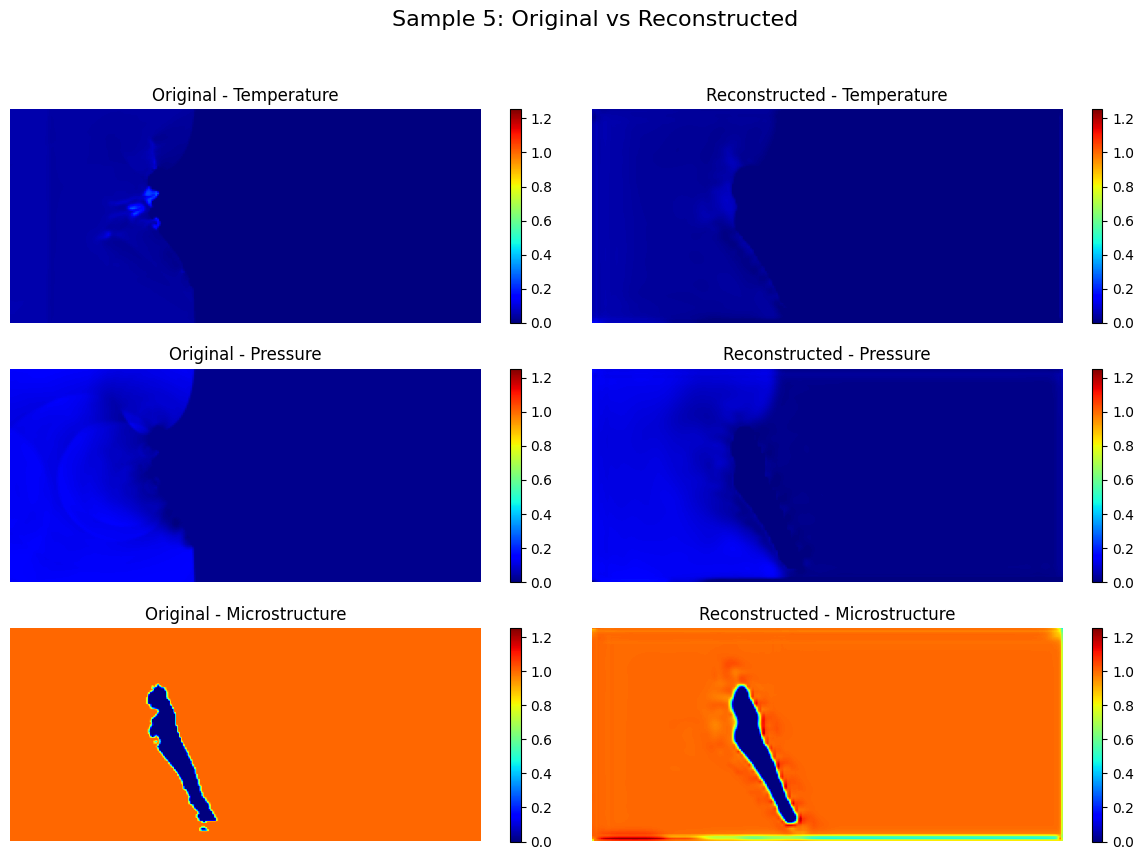

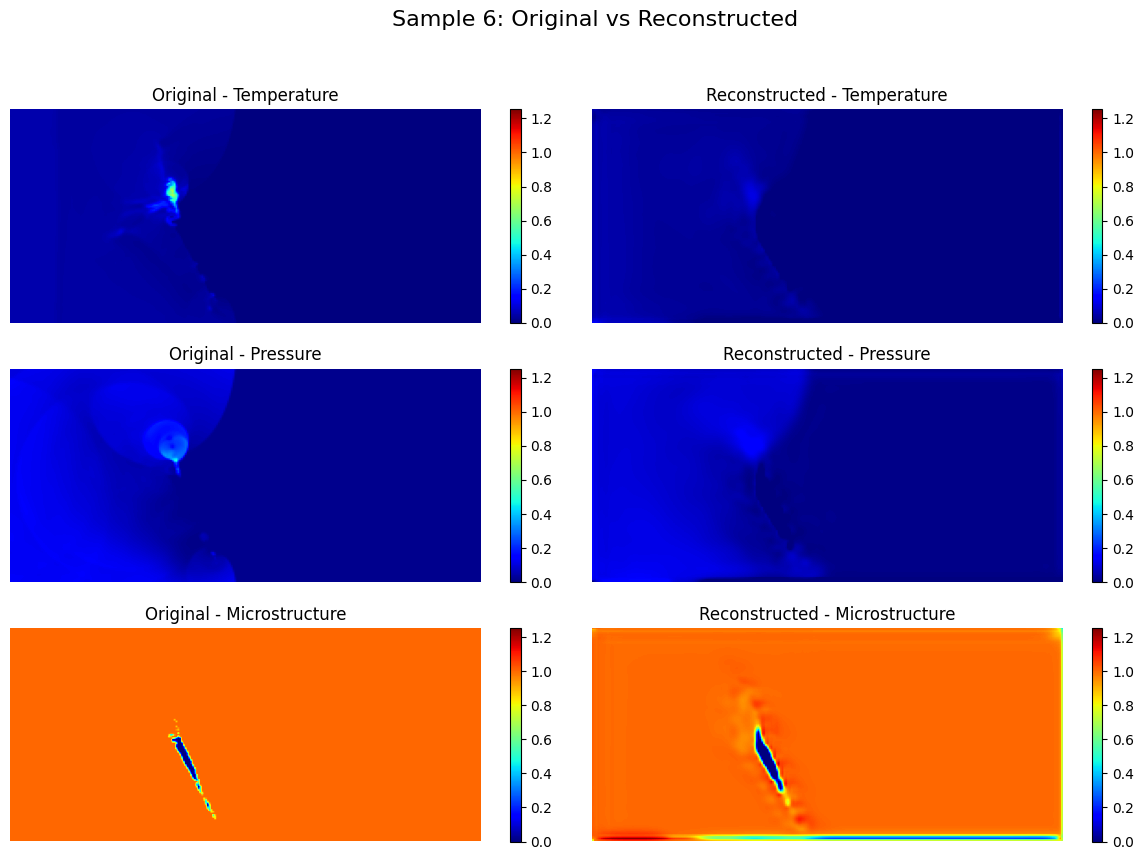

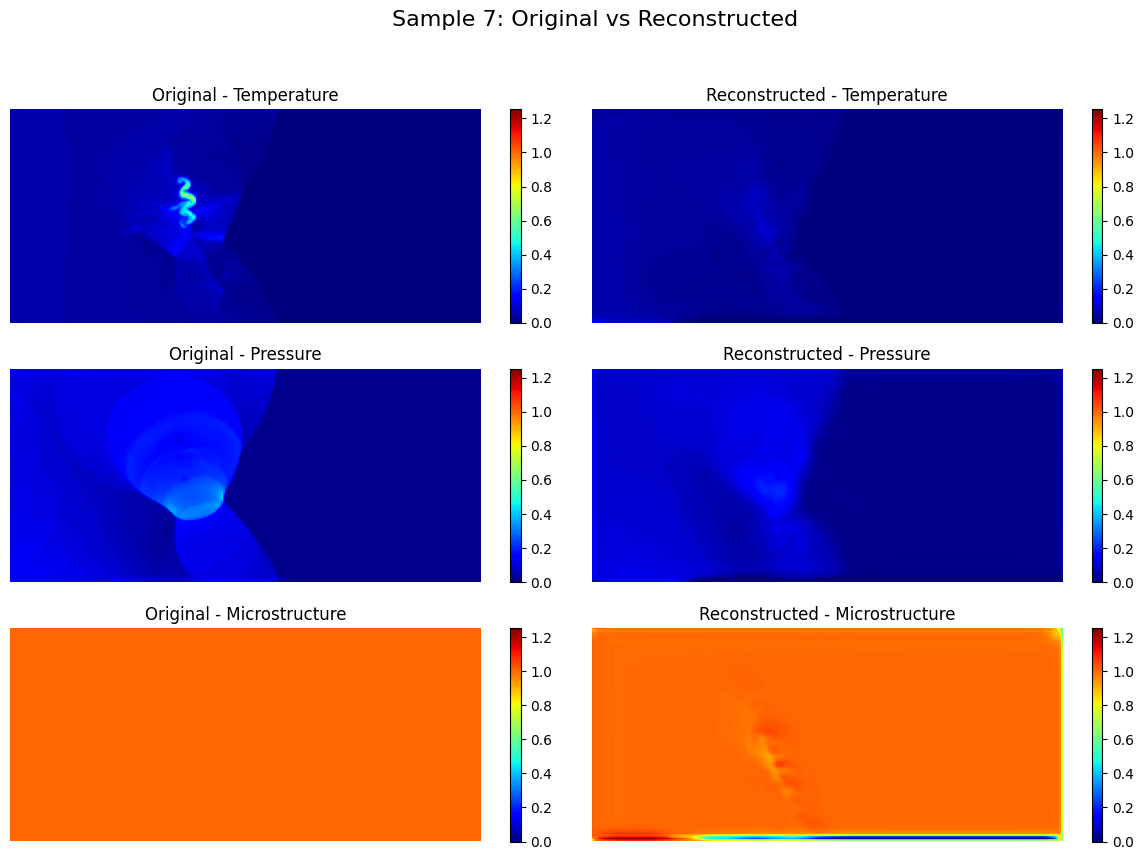

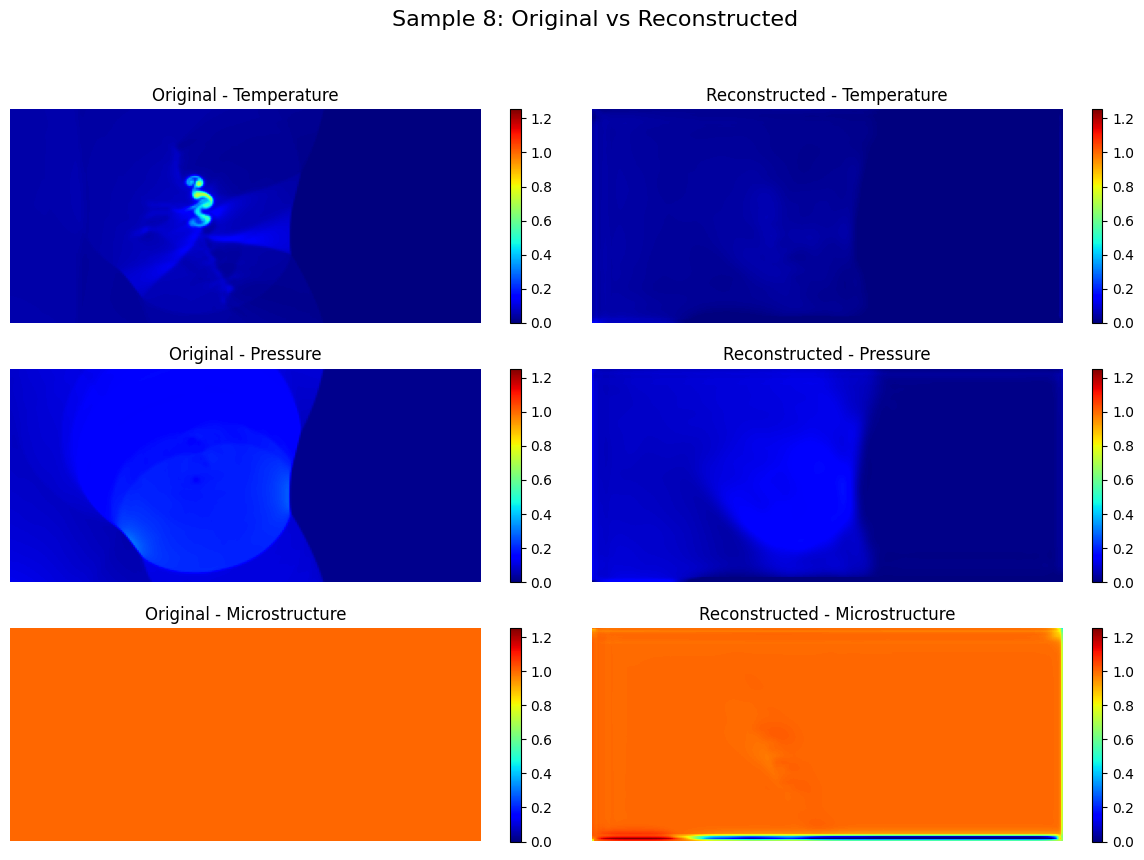

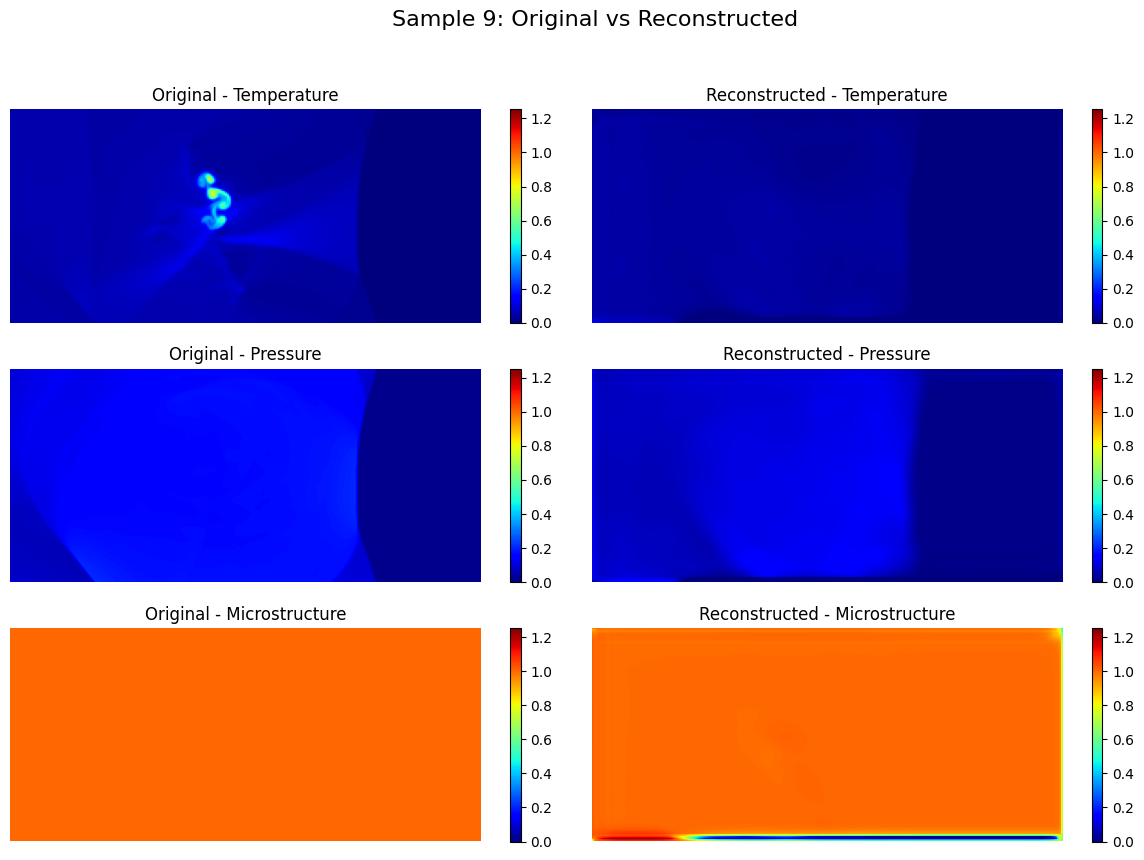

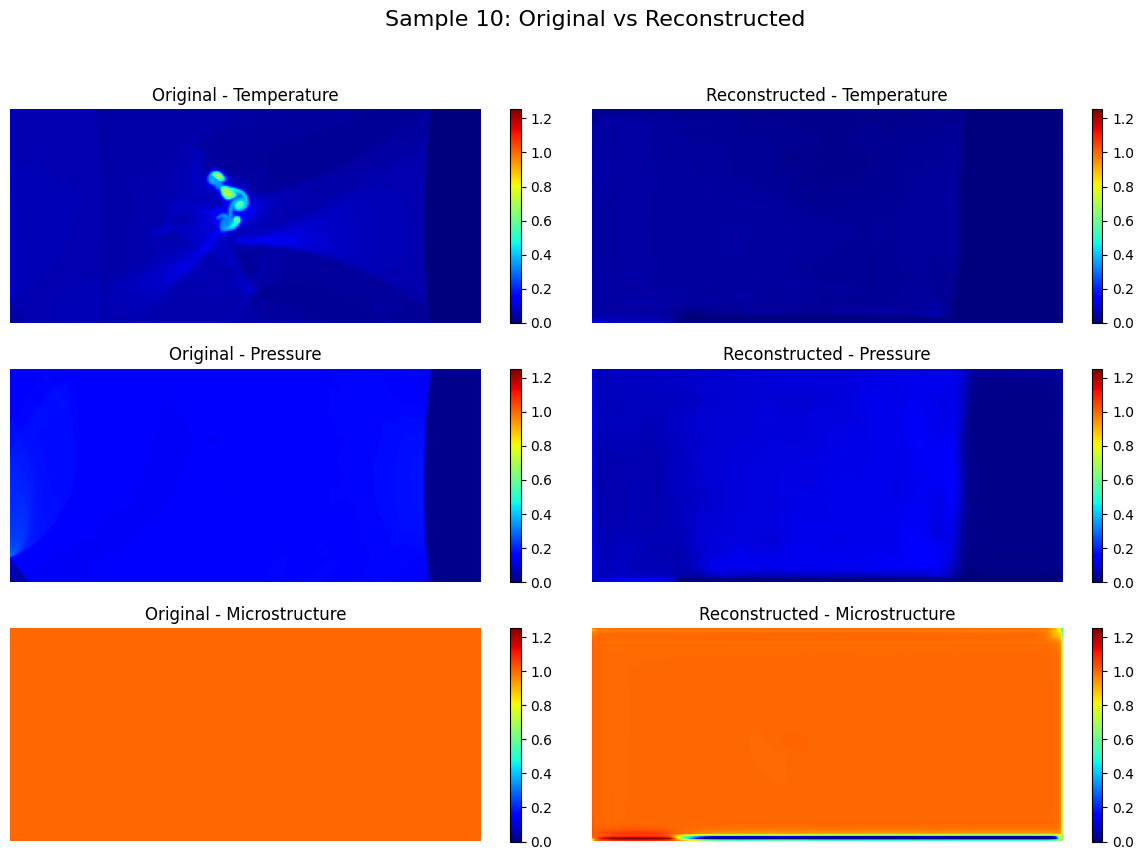

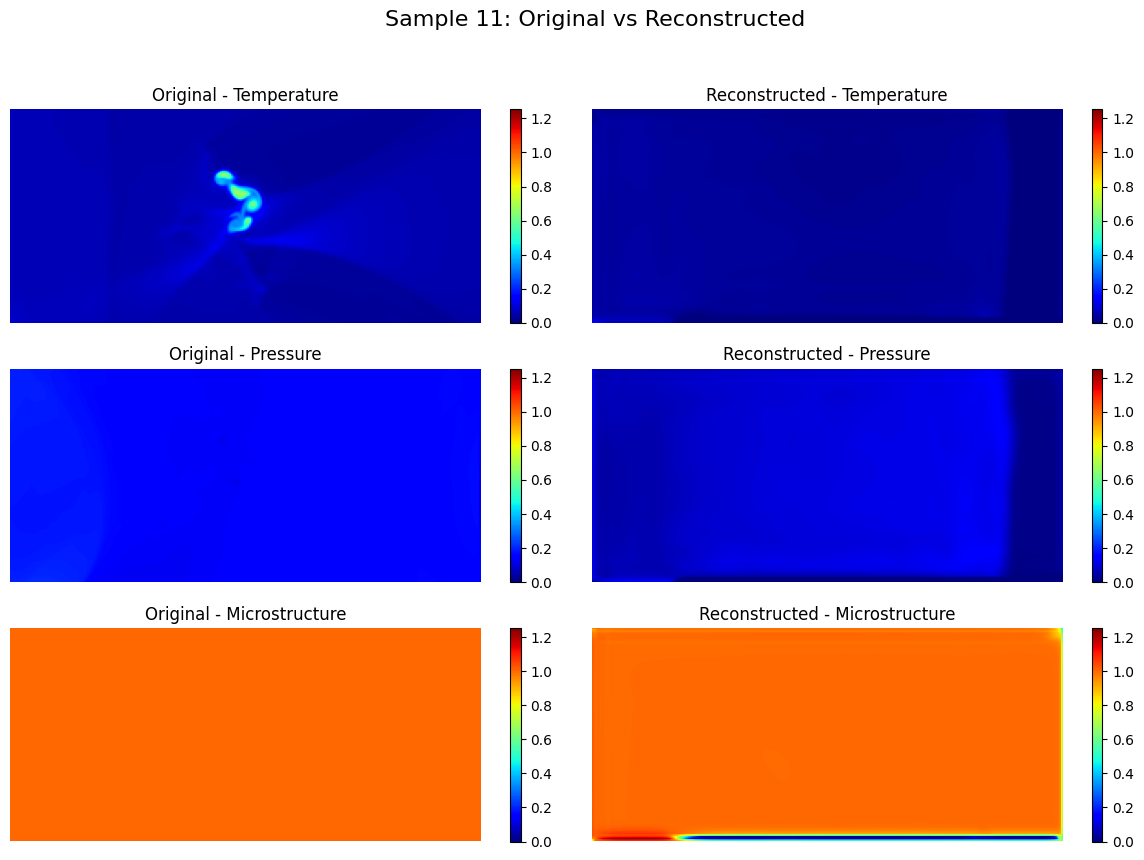

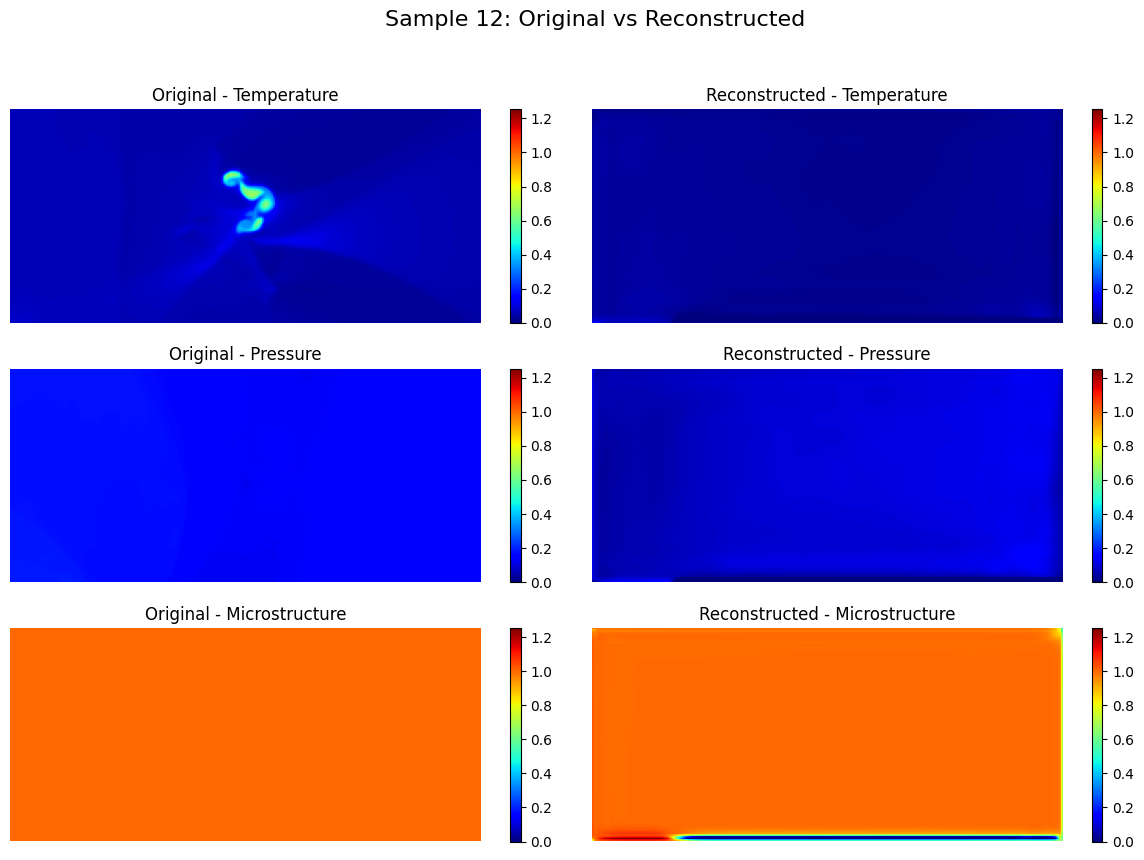

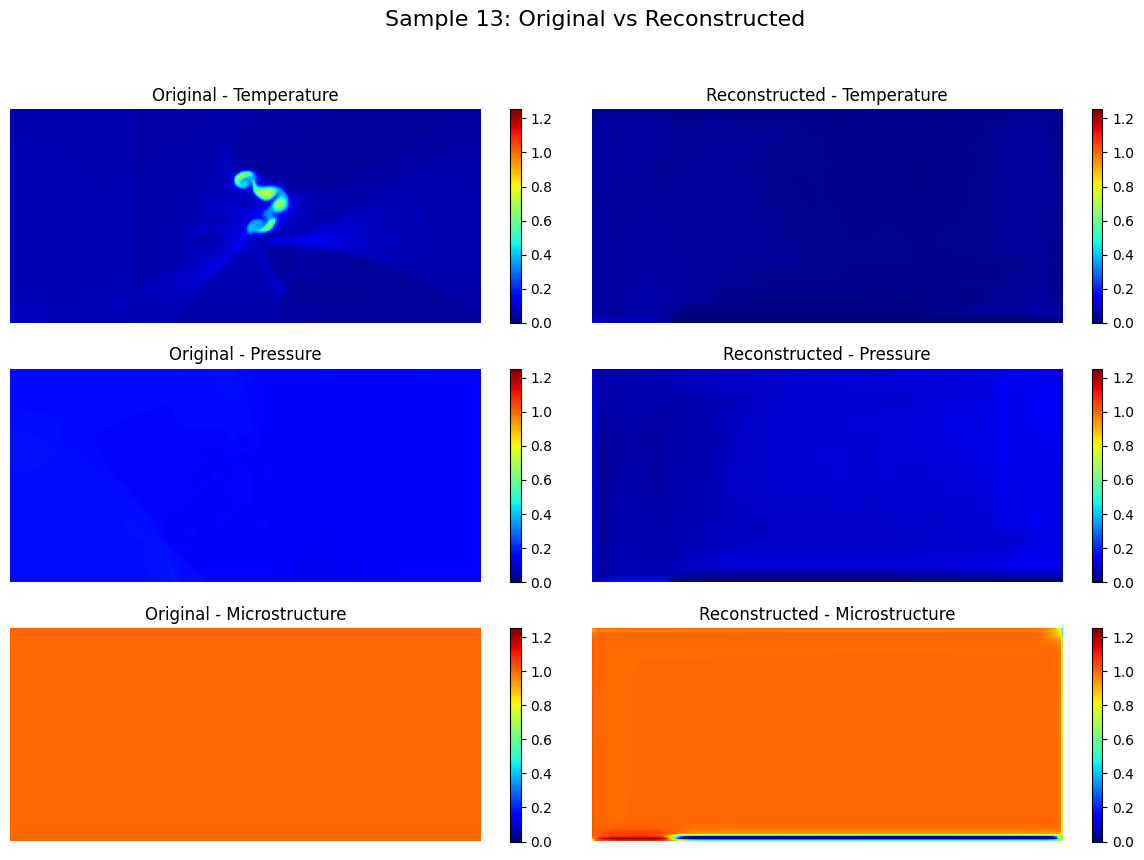

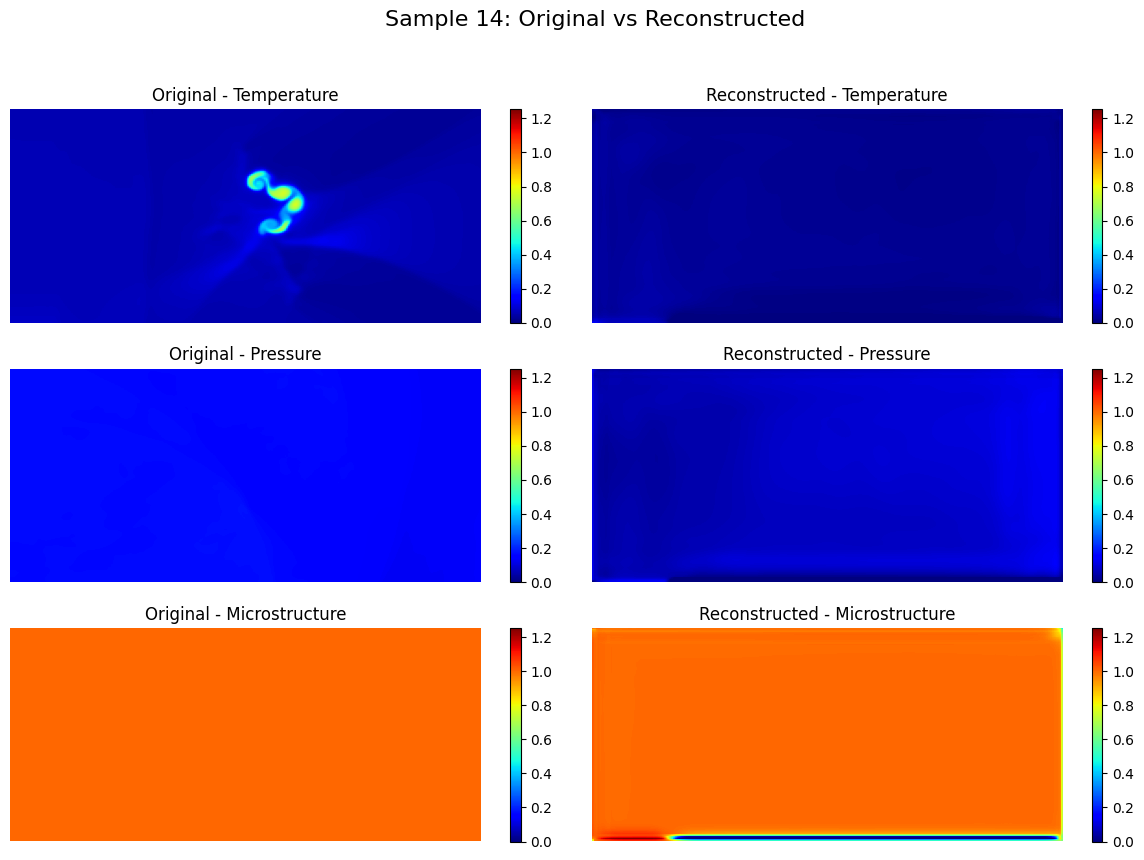

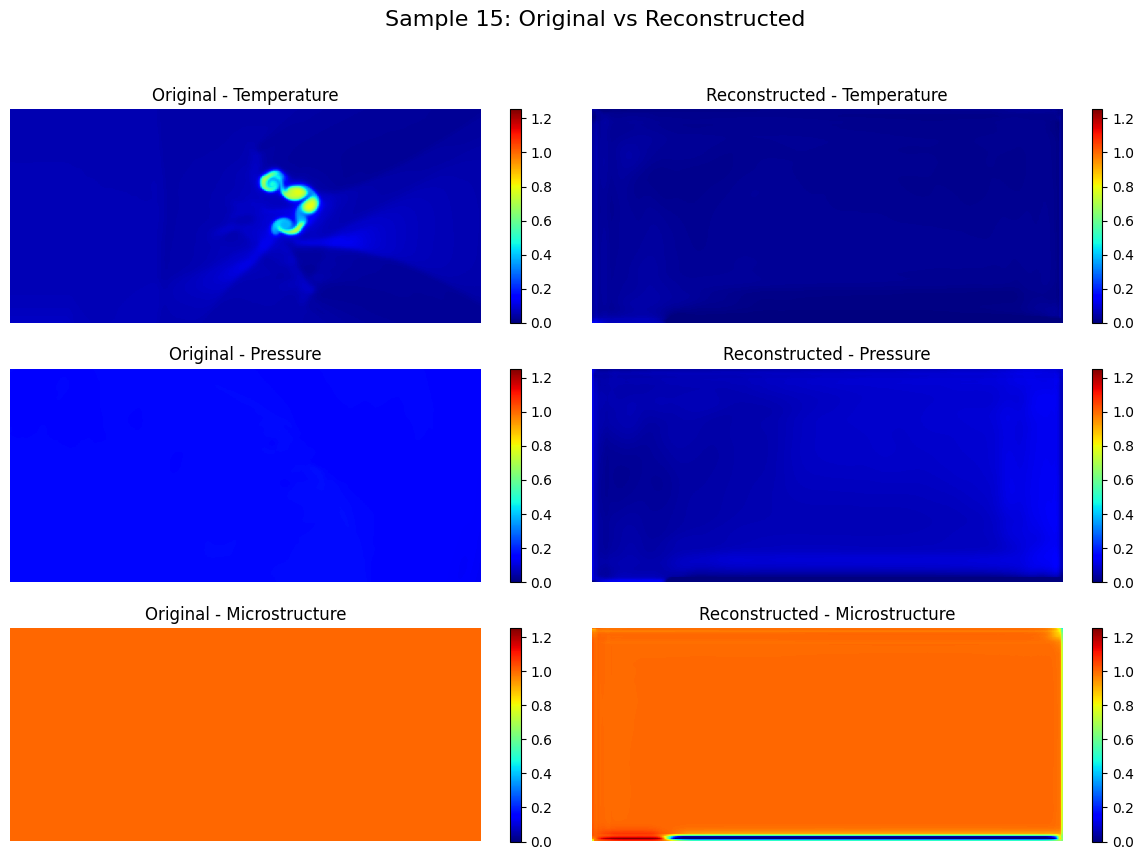

In [27]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

num_samples = 15 

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(pred_decoded.min(), X.min())
global_max = max(pred_decoded.max(), X.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = pred_decoded[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()

### GIF

In [28]:
from PIL import Image

file_name = "2enc_1dec_layers_2_4_8_1_2_4_latent_12_external_rollout"
plot_name = "Single ts Prediction, 1 Encoder 1 Decoder, no purple loss Layers 3 8, Latent Dim 16, 2 Test Samples, 3000 Epochs"

# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
# num_samples = min(28, single_ts_full_reconstruction_GT.shape[0])  # Display up to 30 samples or fewer if dataset is smaller
num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(X.min(), pred_decoded.min())
global_max = max(X.max(), pred_decoded.max())

frames = []  # List to store frames for GIF

# Iterate over the selected samples (each sample represents a time step)
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=150, constrained_layout=True)  # Reduced figsize and dpi for smaller GIF
    fig.suptitle(plot_name, fontsize=12)  # Reduced font size for title
    
    for channel_idx, channel_name in enumerate(channel_names):
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        reconstructed_channel = pred_decoded[sample_idx, channel_idx, :, :].numpy()
        
        # Plot original
        ax = axes[0, channel_idx]
        ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (GT)", fontsize=10)  # Smaller title font size
        ax.axis("off")
        
        # Plot reconstructed
        ax = axes[1, channel_idx]
        ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (Pred)", fontsize=10)  # Smaller title font size
        ax.axis("off")
    
    # Convert the figure to a PIL Image and append to frames
    fig.canvas.draw()  # Draw the figure onto the canvas
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to image dimensions
    frames.append(Image.fromarray(img))

    plt.close(fig)

# Check if frames are created successfully
if len(frames) == 0:
    print("Error: No frames generated!")
else:
    # Save frames as GIF
    gif_path = file_name + ".gif"
    try:
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")
    except Exception as e:
        print(f"Error saving GIF: {e}")


/tmp/ipykernel_3225/894658448.py:42: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to 2enc_1dec_layers_2_4_8_1_2_4_latent_12_external_rollout.gif


### z viz

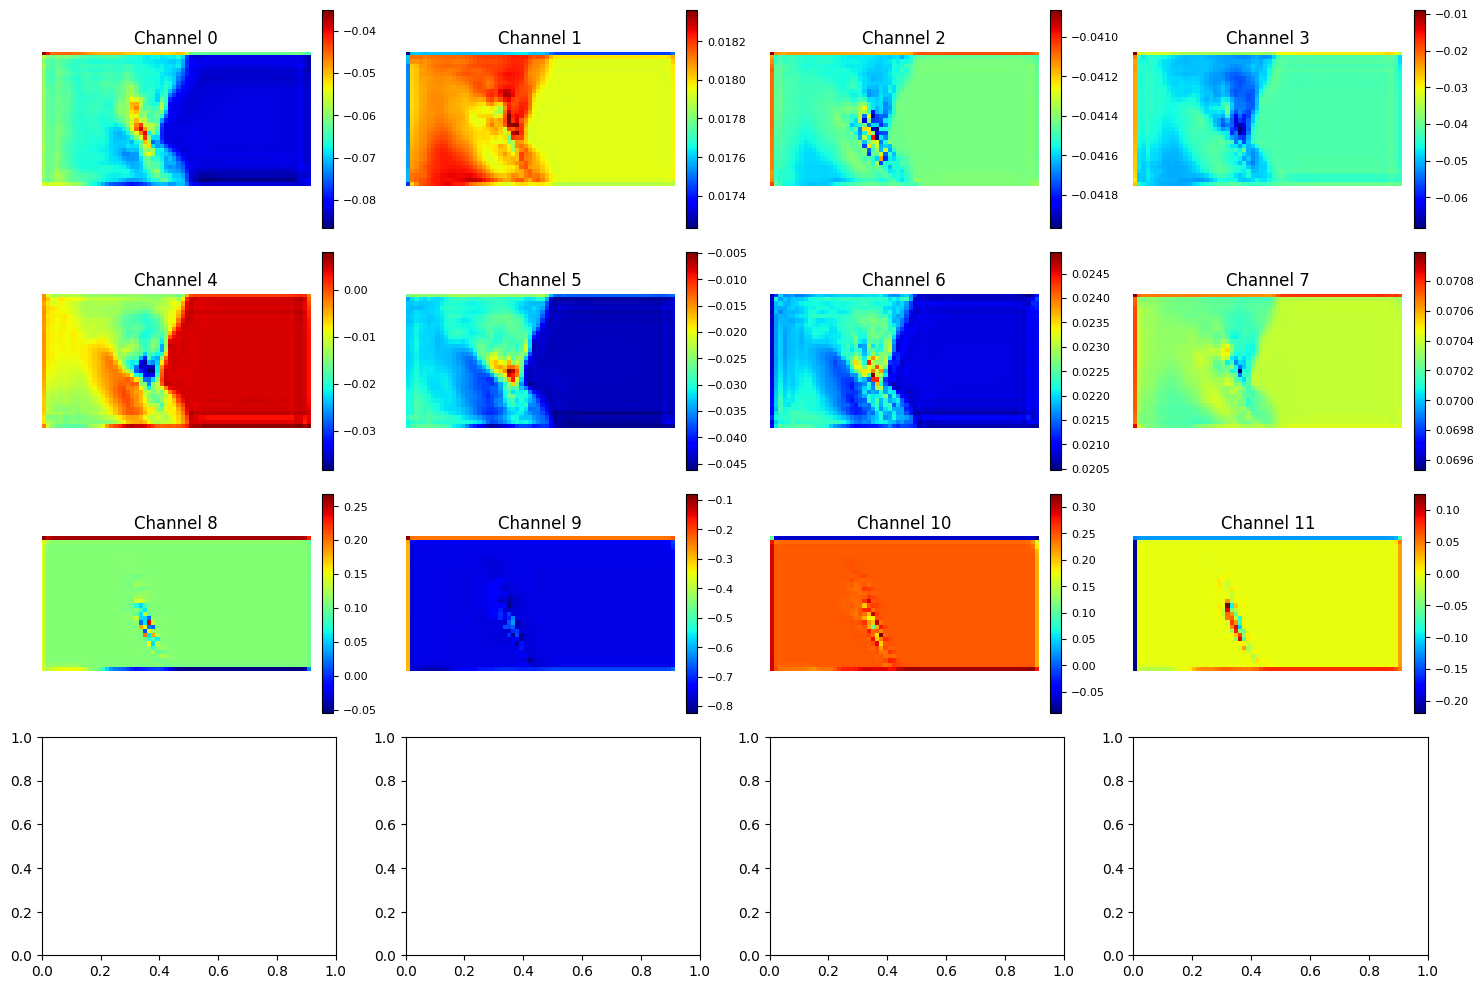

In [30]:
# select timestep to view
ts = 5
n_latent_channels = 12

# Extract the 16-channel image at timestep ts
images = pred_z[ts, ...]

# Convert to CPU and numpy for visualization
images = images.cpu().detach().numpy()

# Plot all 16 channels in a 4x4 grid with colorbars
fig, axes = plt.subplots(4, 4, figsize=(15, 10))

for idx, ax in enumerate(axes.flat):
    if idx < n_latent_channels:
        im = ax.imshow(images[idx], cmap="jet")
        ax.set_title(f"Channel {idx}")
        ax.axis("off")

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

plt.tight_layout()
plt.show()

### GIF

In [31]:
import imageio

n_latent_channels = 12

file_save_name = "2enc_1dec_layers_2_4_8_1_2_4_latent_12_external_rollout_zhat"
frames = []

# Step 1: Compute per-channel vmin and vmax across all timesteps
all_data = pred_z.cpu().detach().numpy()  # Shape: (timesteps, 16, H, W)
channel_vmin = all_data.min(axis=(0, 2, 3))  # Shape: (16,)
channel_vmax = all_data.max(axis=(0, 2, 3))  # Shape: (16,)

print("Per-channel vmin and vmax computed.")

# Step 2: Create GIF frames
for ts in range(n_ts - 1):
    images = all_data[ts]  # Shape: (16, H, W)

    fig, axes = plt.subplots(4, 4, figsize=(15, 10))

    for idx, ax in enumerate(axes.flat):
        if idx < n_latent_channels:
            im = ax.imshow(
                images[idx],
                cmap="jet",
                vmin=channel_vmin[idx],
                vmax=channel_vmax[idx]
            )
            ax.set_title(f"Channel {idx}")
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()

    # Save frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = frame[..., :3]  # Remove alpha channel
    frames.append(frame)

    plt.close(fig)

# Step 3: Save GIF with infinite loop and longer duration
imageio.mimsave(
    f'{file_save_name}.gif',
    frames,
    duration=500,
    loop=0
)

print(f"GIF saved as '{file_save_name}.gif'")

Per-channel vmin and vmax computed.
GIF saved as '2enc_1dec_layers_2_4_8_1_2_4_latent_12_external_rollout_zhat.gif'


### Rollout in Latent Space

In [32]:
n_channels = 3
n_ts = 15

GT = []
pred_latent = []
pred = []

with torch.no_grad():
    z, decoded = model_init(ic.to(device), n_ts=n_ts, mode='pred')

z = z.cpu()
decoded = torch.concat((ic, decoded.cpu()))

In [25]:
z.shape, decoded.shape

(torch.Size([14, 16, 32, 64]), torch.Size([15, 3, 128, 256]))

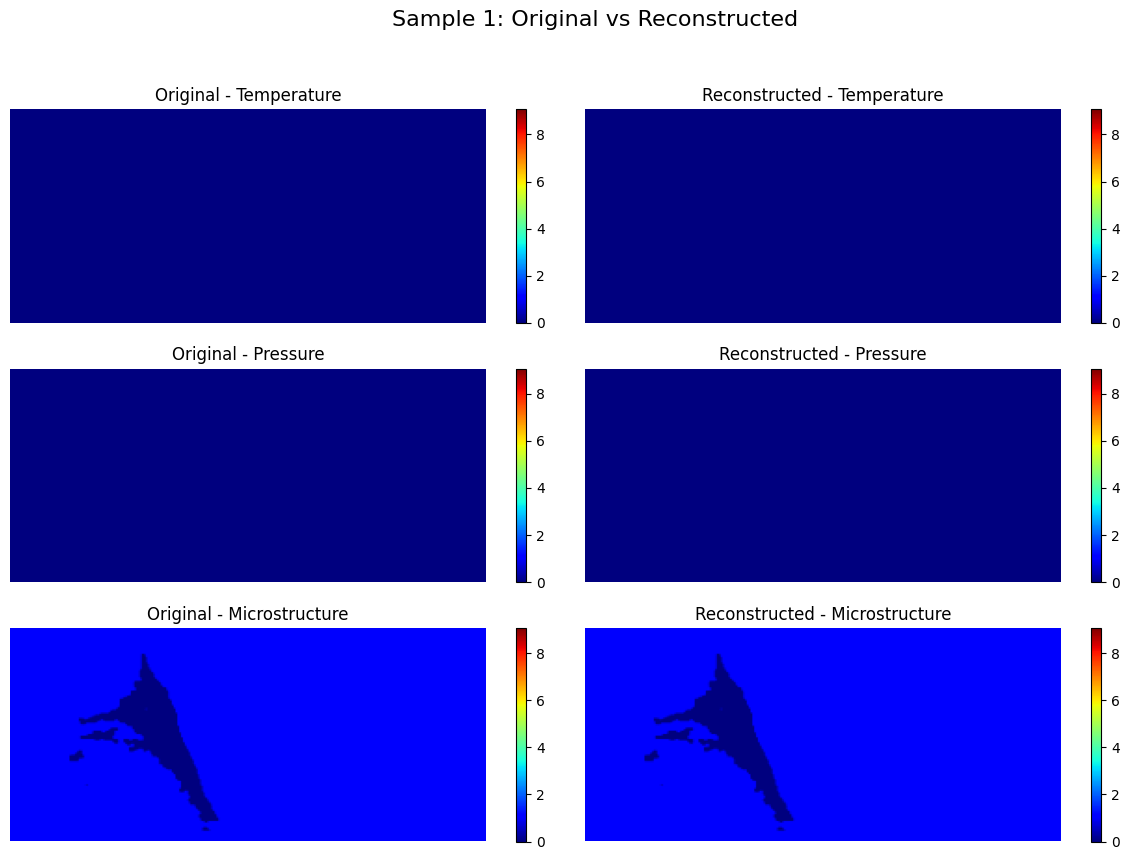

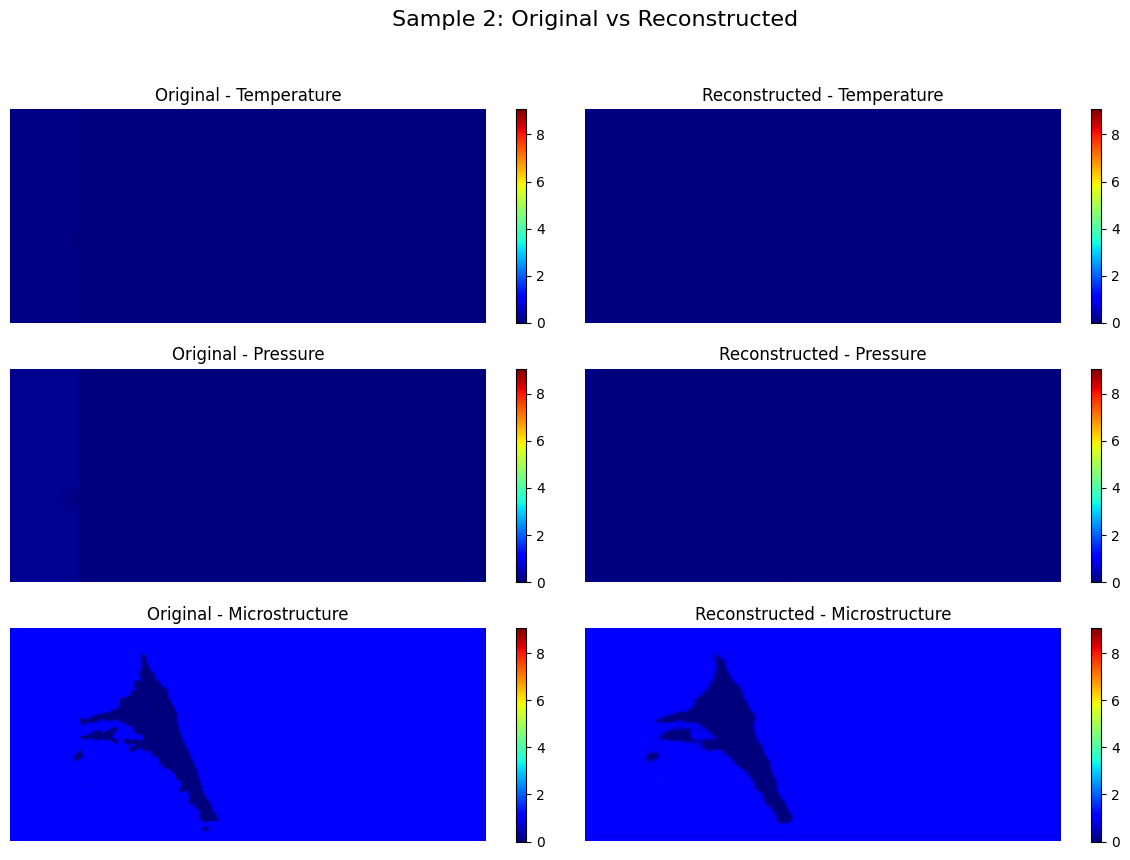

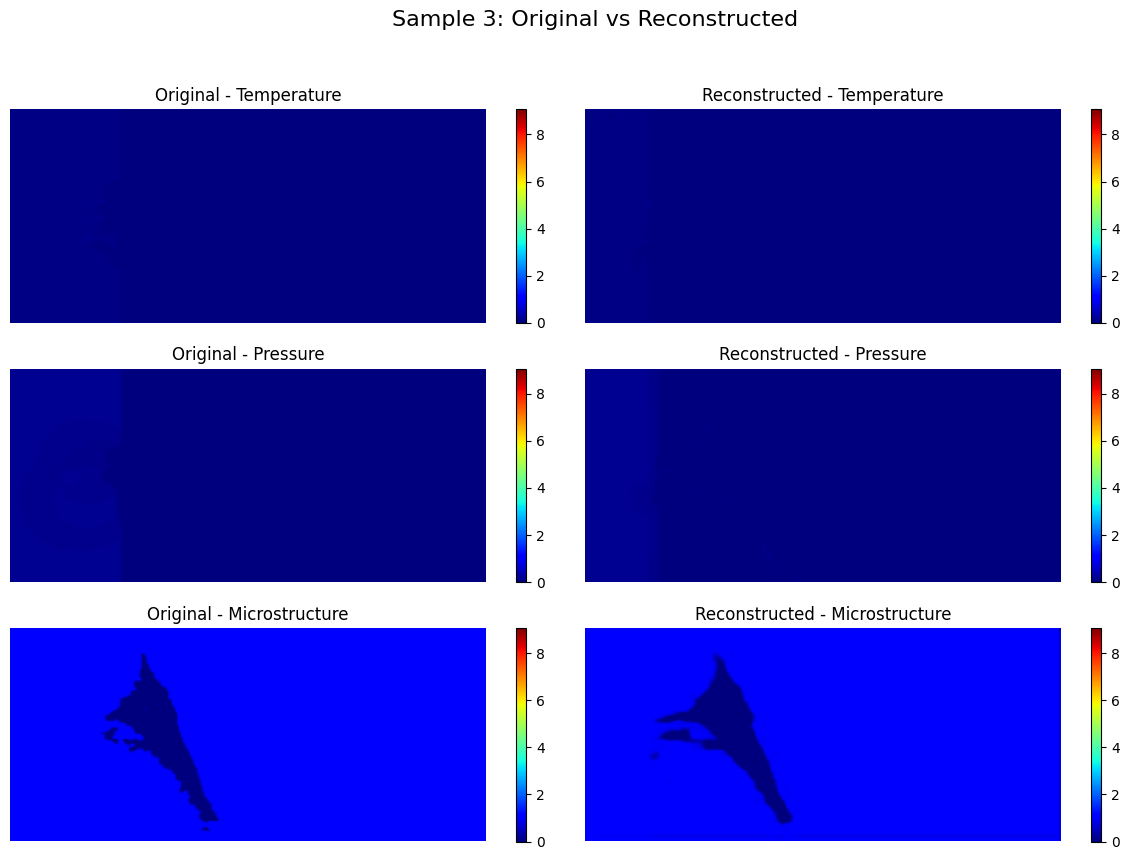

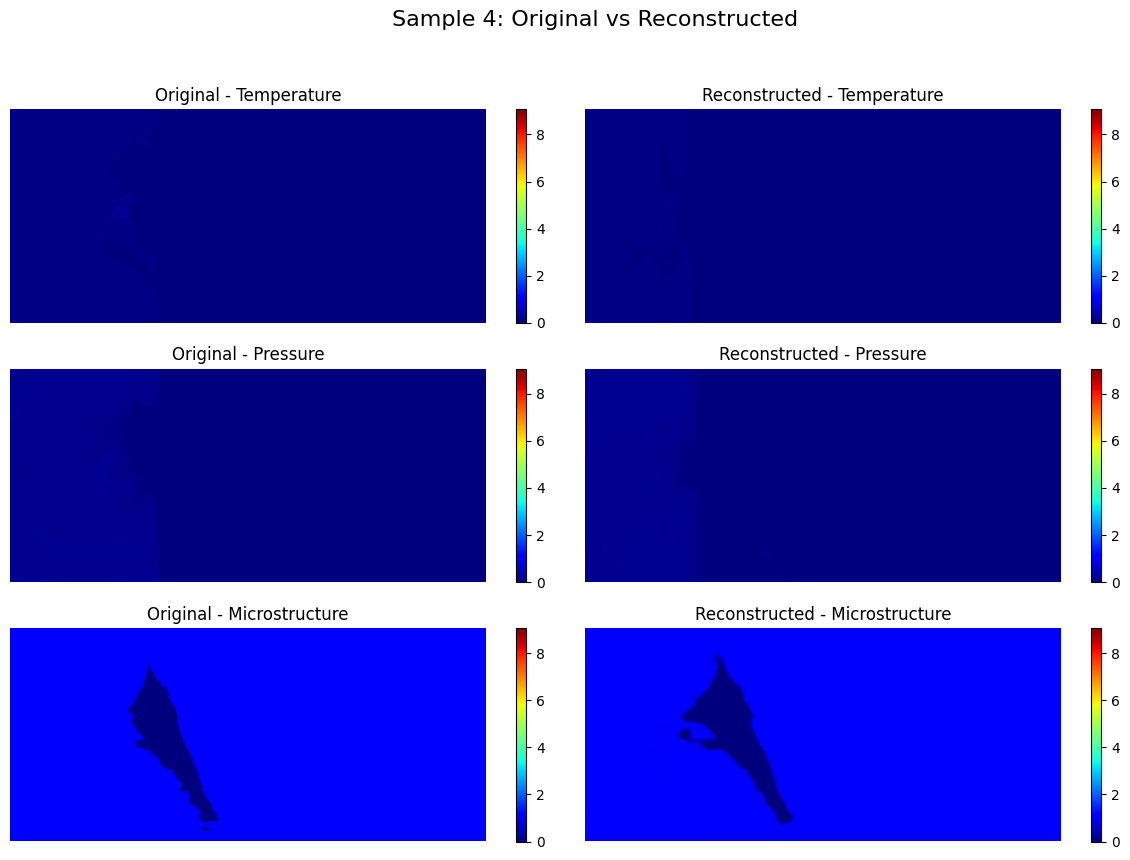

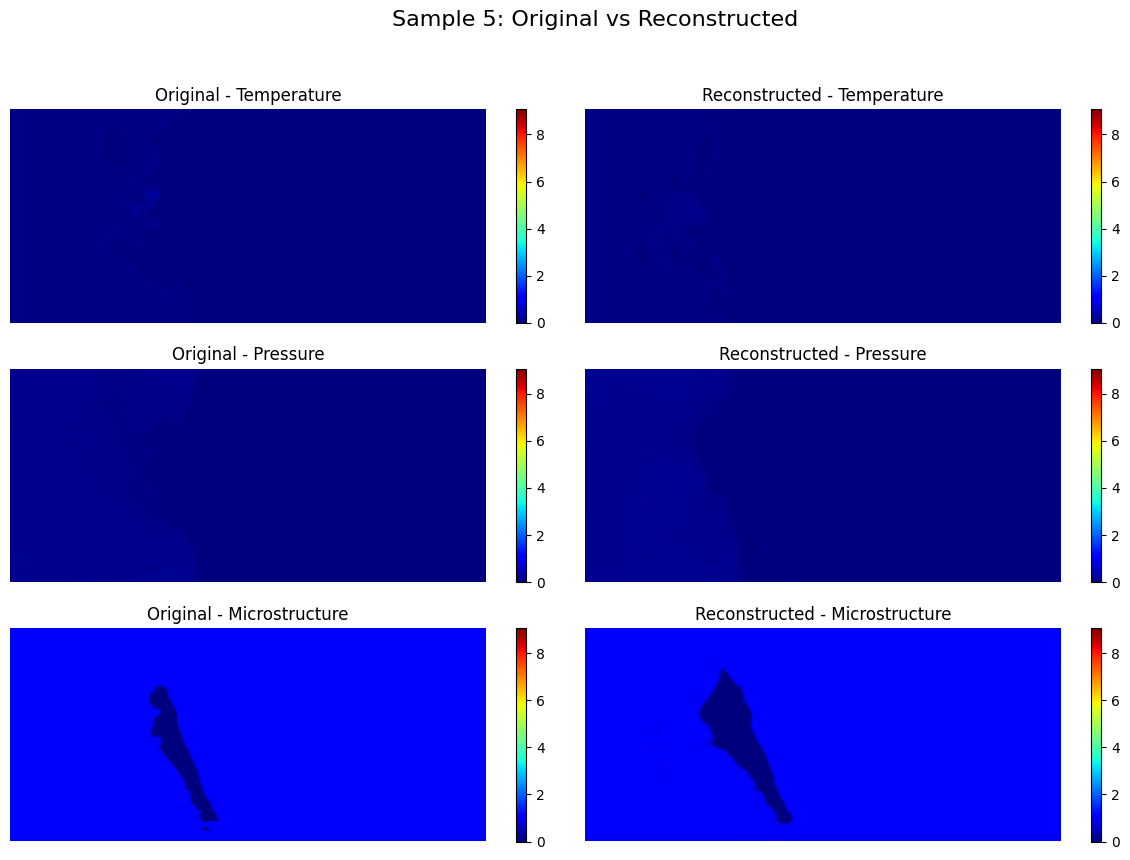

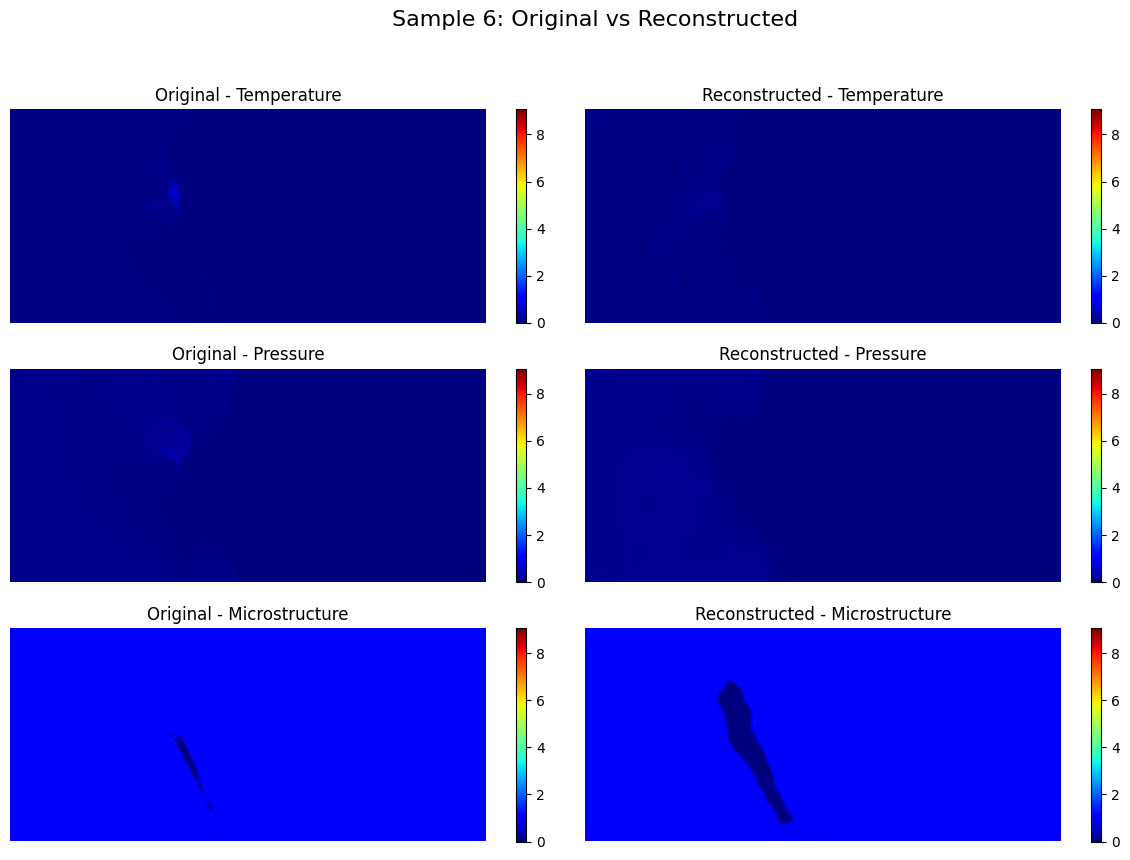

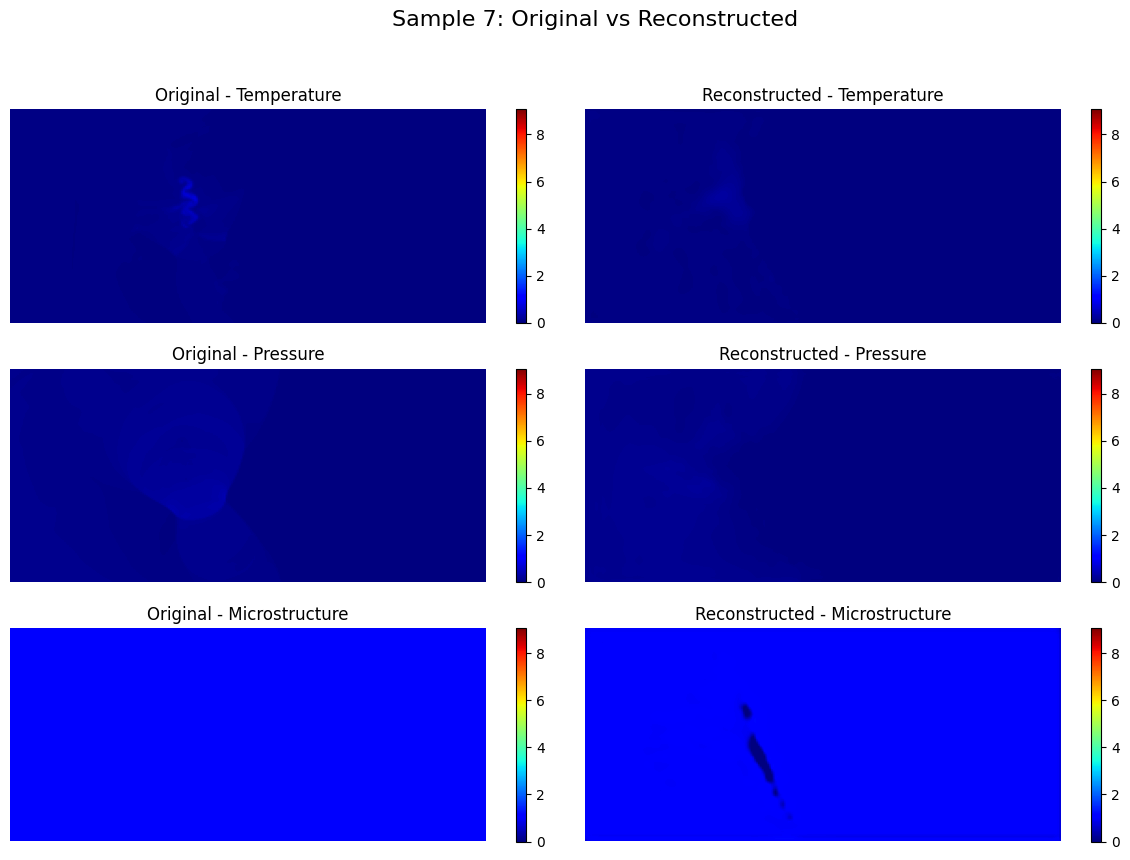

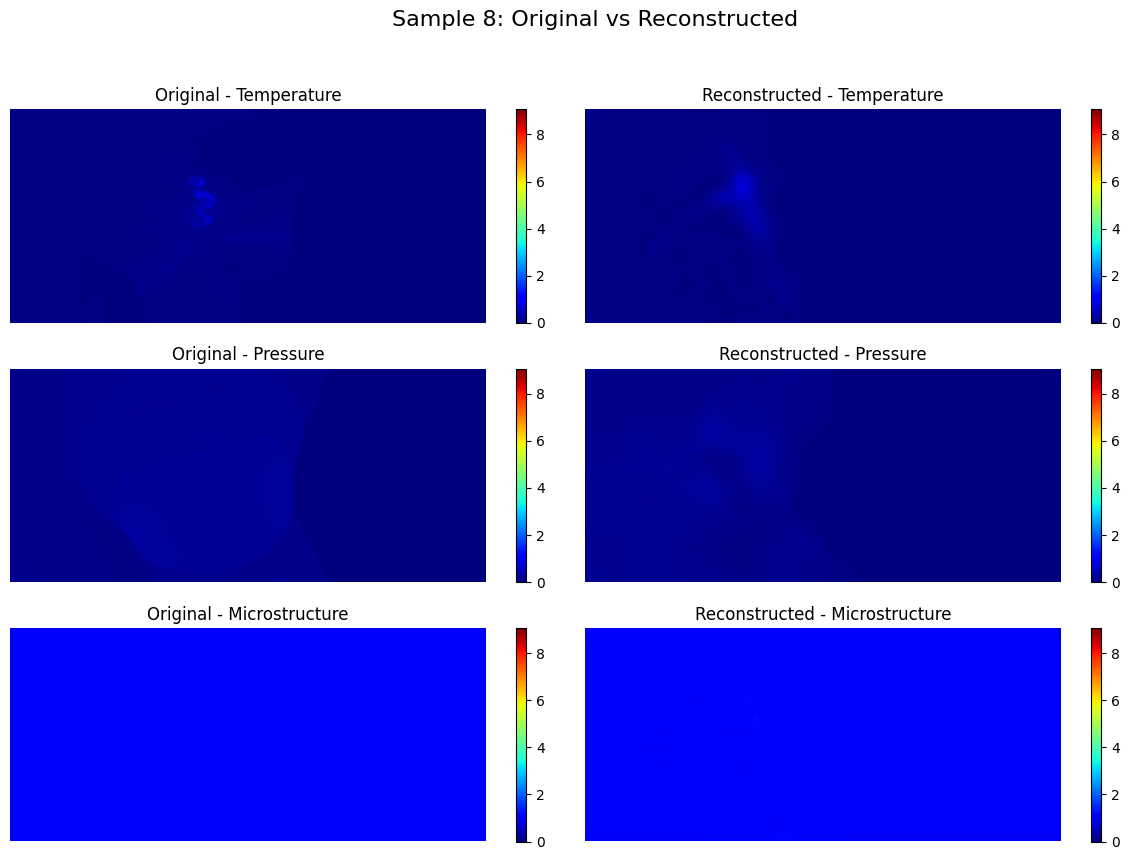

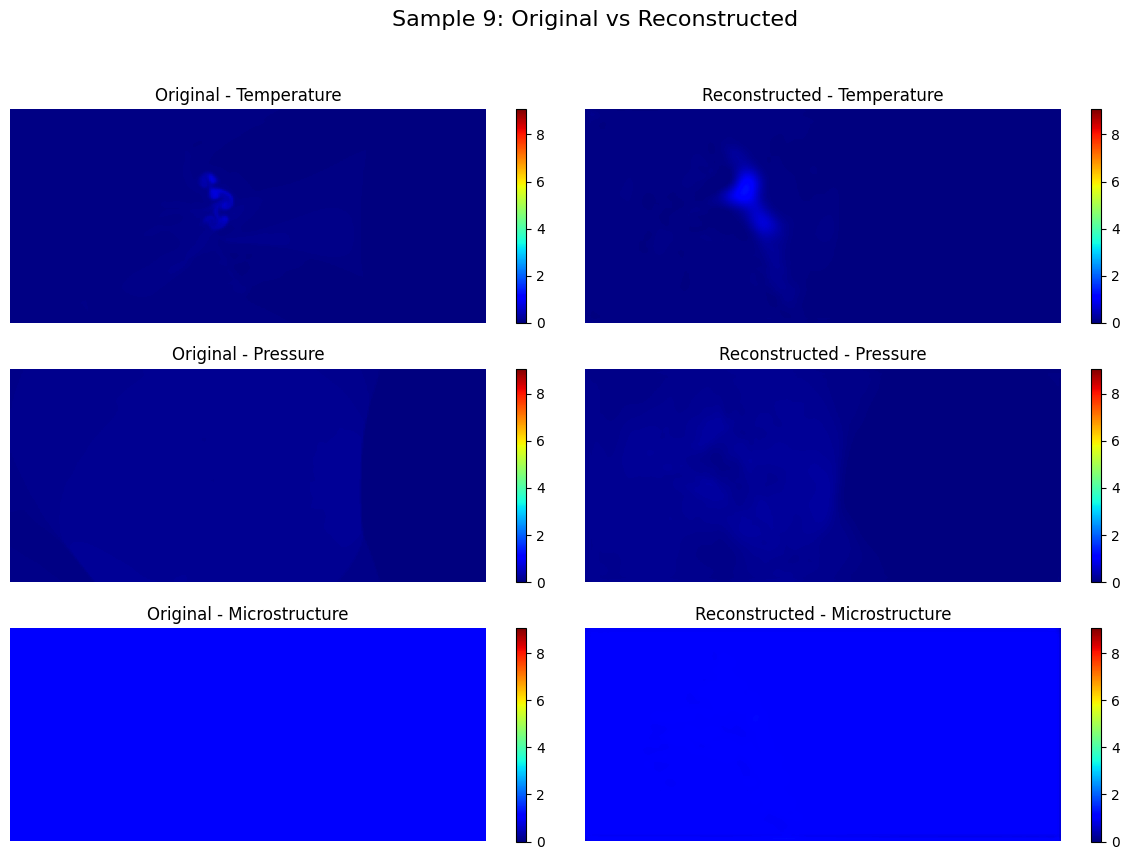

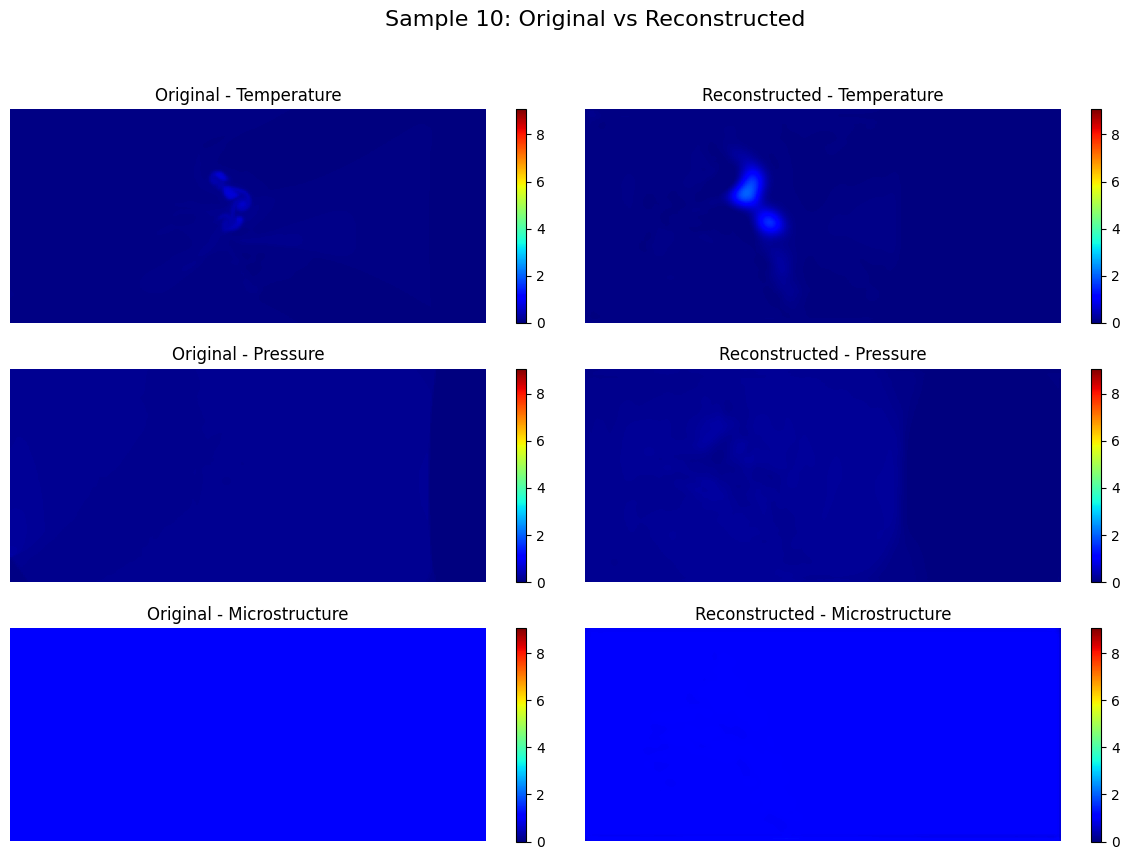

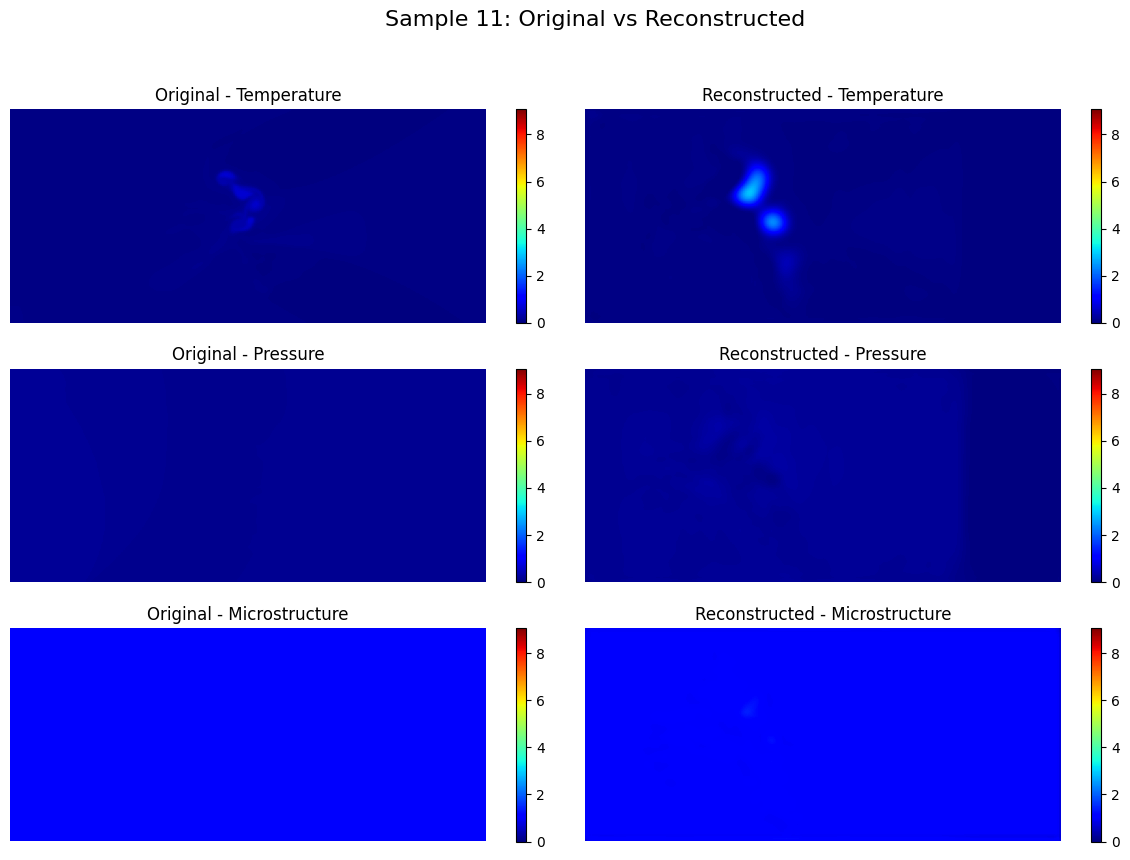

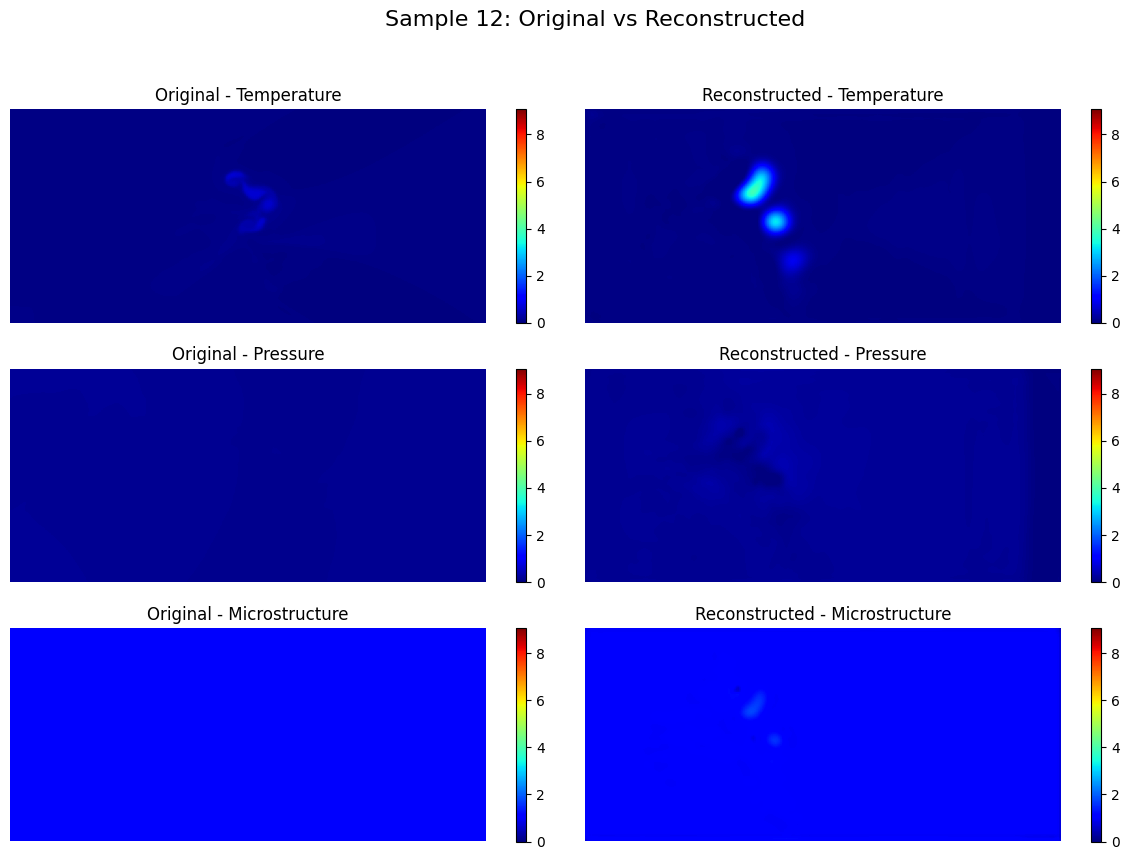

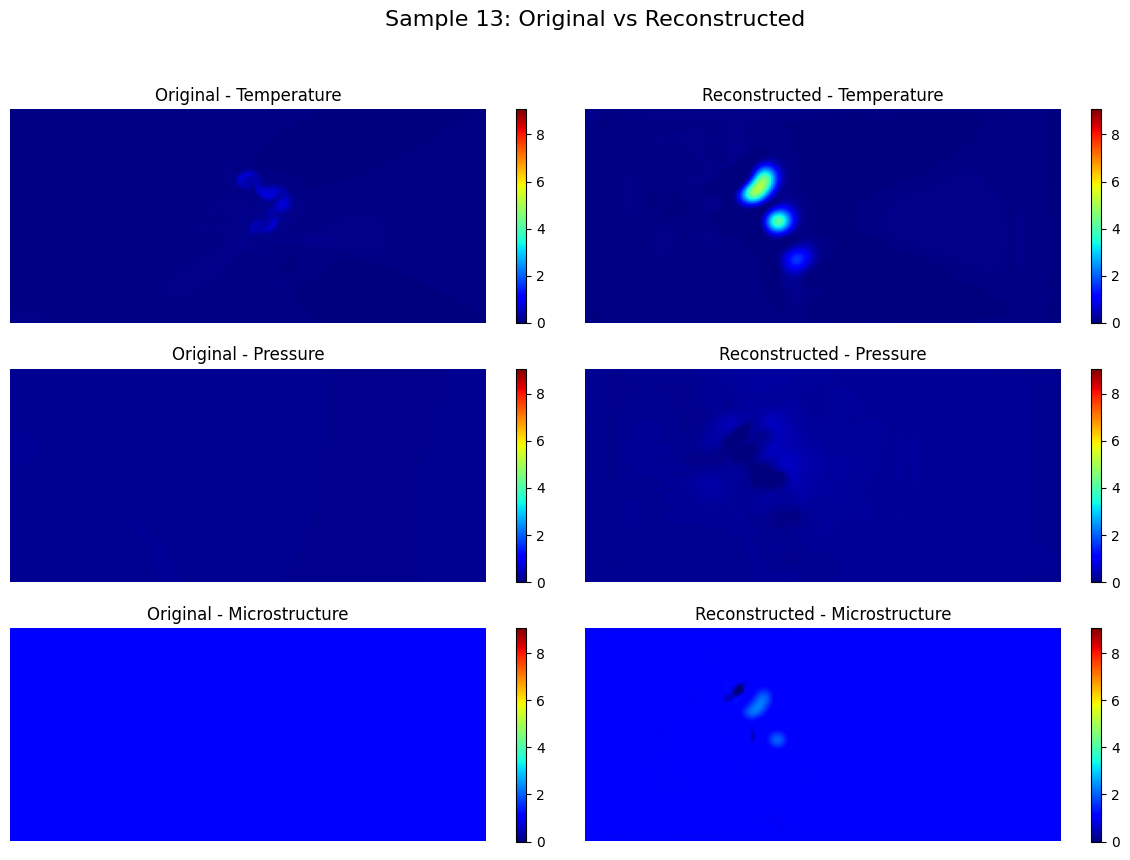

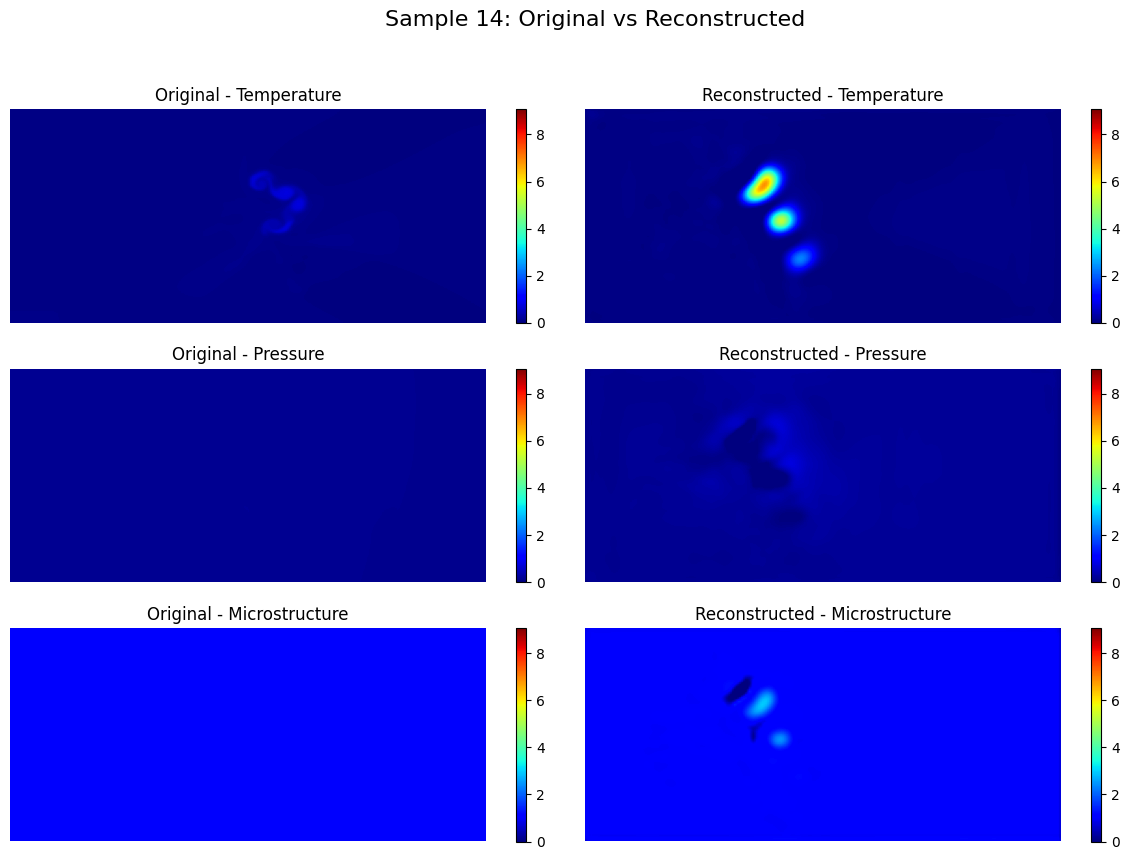

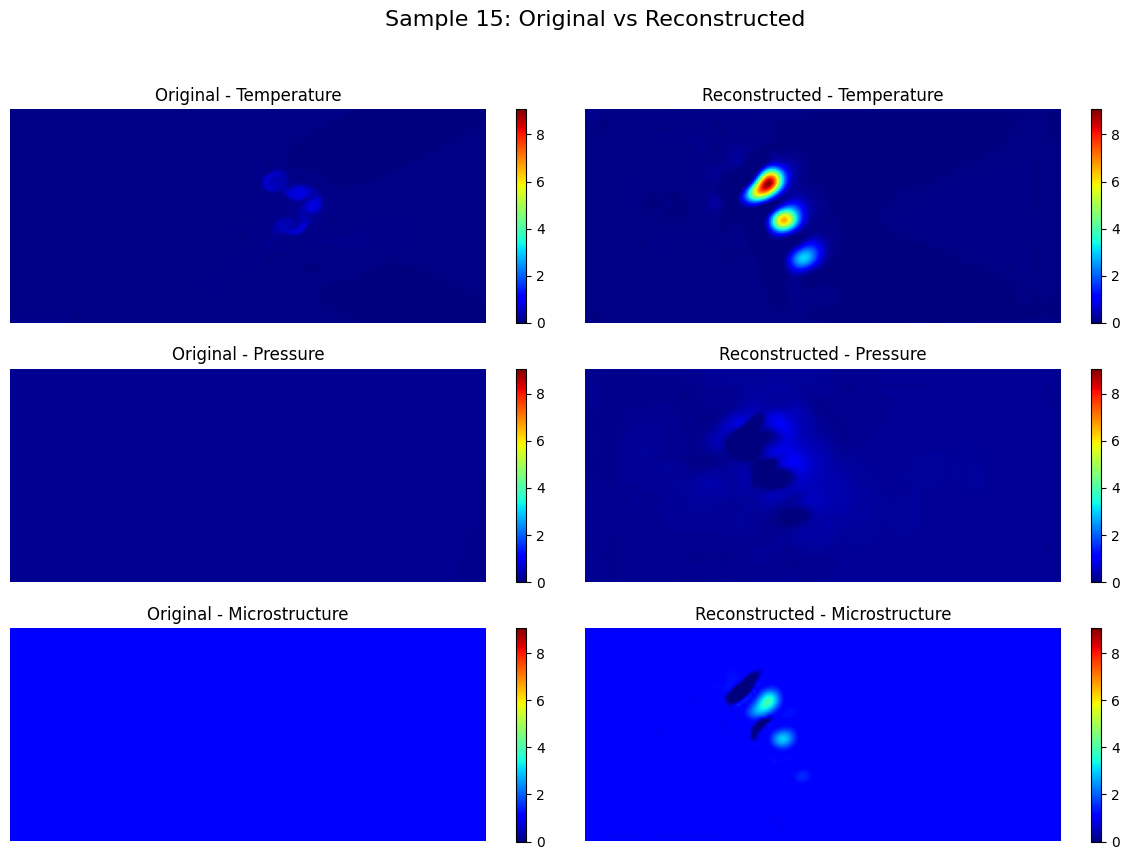

In [33]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

num_samples = 15 

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(decoded.min(), X.min())
global_max = max(decoded.max(), X.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = decoded[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()

### GIF

In [34]:
from PIL import Image

file_name = "2enc_1dec_layers_2_4_8_1_2_4_latent_12_latent_rollout"
plot_name = "Single ts Prediction, 1 Encoder 1 Decoder, no purple loss Layers 3 8, Latent Dim 16, 2 Test Samples, 3000 Epochs"

# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
# num_samples = min(28, single_ts_full_reconstruction_GT.shape[0])  # Display up to 30 samples or fewer if dataset is smaller
num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(X.min(), decoded.min())
global_max = max(X.max(), decoded.max())

frames = []  # List to store frames for GIF

# Iterate over the selected samples (each sample represents a time step)
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=150, constrained_layout=True)  # Reduced figsize and dpi for smaller GIF
    fig.suptitle(plot_name, fontsize=12)  # Reduced font size for title
    
    for channel_idx, channel_name in enumerate(channel_names):
        original_channel = X[sample_idx, channel_idx, :, :].numpy()
        reconstructed_channel = decoded[sample_idx, channel_idx, :, :].numpy()
        
        # Plot original
        ax = axes[0, channel_idx]
        ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (GT)", fontsize=10)  # Smaller title font size
        ax.axis("off")
        
        # Plot reconstructed
        ax = axes[1, channel_idx]
        ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (Pred)", fontsize=10)  # Smaller title font size
        ax.axis("off")
    
    # Convert the figure to a PIL Image and append to frames
    fig.canvas.draw()  # Draw the figure onto the canvas
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to image dimensions
    frames.append(Image.fromarray(img))

    plt.close(fig)

# Check if frames are created successfully
if len(frames) == 0:
    print("Error: No frames generated!")
else:
    # Save frames as GIF
    gif_path = file_name + ".gif"
    try:
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")
    except Exception as e:
        print(f"Error saving GIF: {e}")


/tmp/ipykernel_3225/3101916148.py:42: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to 2enc_1dec_layers_2_4_8_1_2_4_latent_12_latent_rollout.gif


### z viz

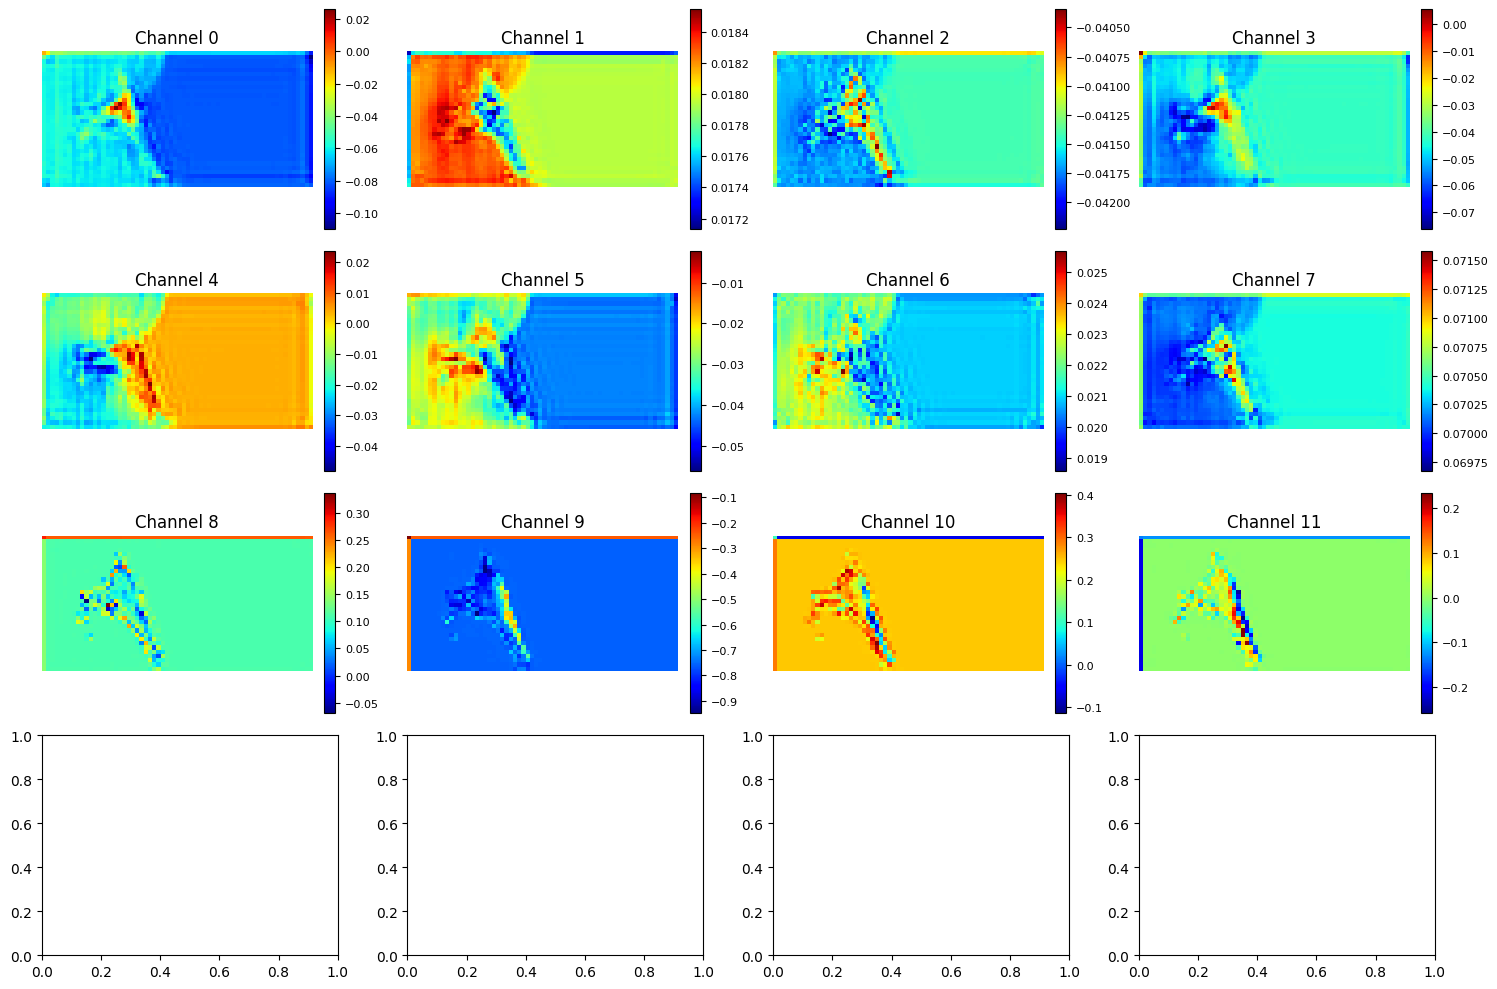

In [36]:
# select timestep to view
ts = 5

# Extract the 16-channel image at timestep ts
images = z[ts, ...]

# Convert to CPU and numpy for visualization
images = images.cpu().detach().numpy()

# Plot all 16 channels in a 4x4 grid with colorbars
fig, axes = plt.subplots(4, 4, figsize=(15, 10))

for idx, ax in enumerate(axes.flat):
    if idx < n_latent_channels:
        im = ax.imshow(images[idx], cmap="jet")
        ax.set_title(f"Channel {idx}")
        ax.axis("off")

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)  # Adjust tick label size

plt.tight_layout()
plt.show()

### GIF

In [37]:
import imageio

file_save_name = "2enc_1dec_layers_2_4_8_1_2_4_latent_12_latent_rollout_zhat"
frames = []

# Step 1: Compute per-channel vmin and vmax across all timesteps
all_data = z.cpu().detach().numpy()  # Shape: (timesteps, 16, H, W)
channel_vmin = all_data.min(axis=(0, 2, 3))  # Shape: (16,)
channel_vmax = all_data.max(axis=(0, 2, 3))  # Shape: (16,)

print("Per-channel vmin and vmax computed.")

# Step 2: Create GIF frames
for ts in range(n_ts - 1):
    images = all_data[ts]  # Shape: (16, H, W)

    fig, axes = plt.subplots(4, 4, figsize=(15, 10))

    for idx, ax in enumerate(axes.flat):
        if idx < n_latent_channels:
            im = ax.imshow(
                images[idx],
                cmap="jet",
                vmin=channel_vmin[idx],
                vmax=channel_vmax[idx]
            )
            ax.set_title(f"Channel {idx}")
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()

    # Save frame
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = frame[..., :3]  # Remove alpha channel
    frames.append(frame)

    plt.close(fig)

# Step 3: Save GIF with infinite loop and longer duration
imageio.mimsave(
    f'{file_save_name}.gif',
    frames,
    duration=500,
    loop=0
)

print(f"GIF saved as '{file_save_name}.gif'")

Per-channel vmin and vmax computed.
GIF saved as '2enc_1dec_layers_2_4_8_1_2_4_latent_12_latent_rollout_zhat.gif'


# Loss Plots

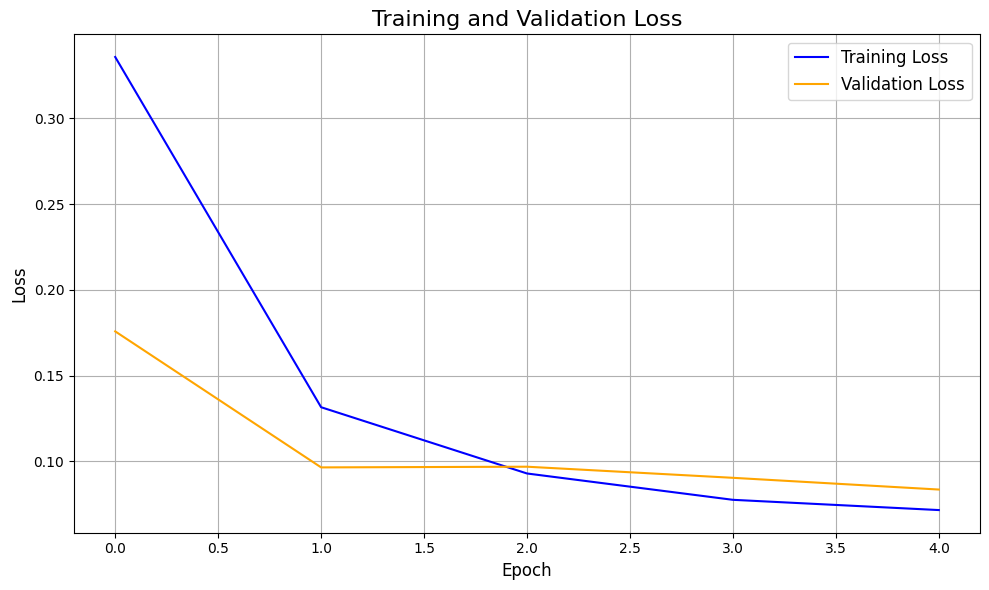

In [16]:
# Path to the JSON log file
log_file_path = "test_5.json"

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
training_loss = log_dict['training_loss_per_epoch']
validation_loss = log_dict['validation_loss_per_epoch']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

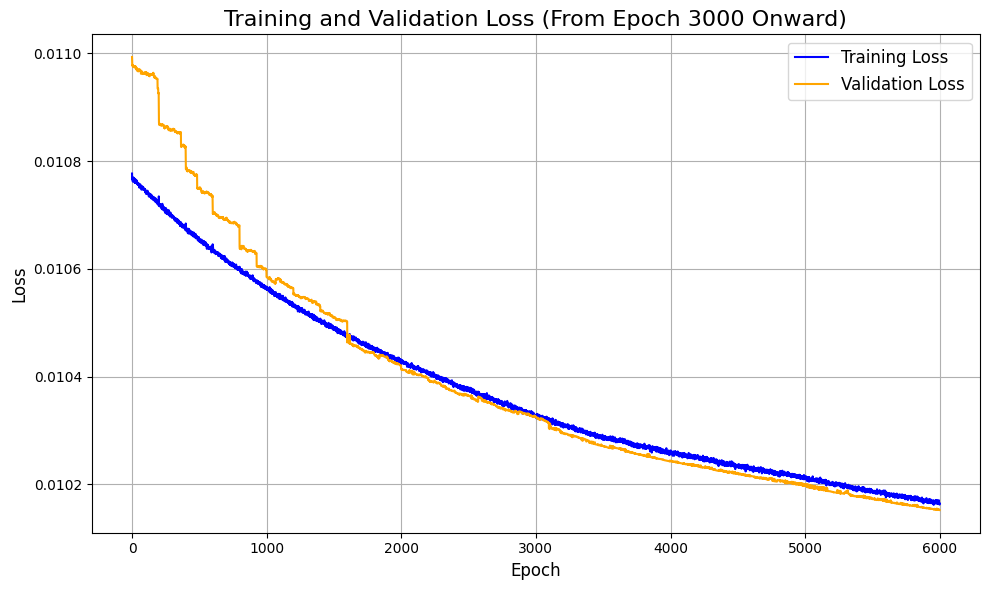

In [19]:
# Starting from the 50th epoch (index 49, since indexing starts at 0)
start_epoch = 4000

# Slice the data from the 50th epoch onward
training_loss = training_loss[start_epoch:]
validation_loss = validation_loss[start_epoch:]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss (From Epoch 3000 Onward)", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
